In [12]:
# Import packages
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy import ndimage
import scipy.io as sio
from scipy.signal import butter, sosfilt

In [ ]:
background_path = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3\\Fig3_ver04_221110_data119.cathodic_picture.txt'

img_data = []
with open(background_path) as file:
    for (i, line) in enumerate(file):
        row_data = np.expand_dims(np.array(line.split(',')[:-1]).astype('float64'), axis=0)
        if i == 0:
            img_data = row_data
        else:
            img_data = np.concatenate([img_data, row_data], axis=0)

plt.imshow(img_data, cmap='gray')
plt.axis('off')
plt.show()

In [13]:
# Check data
base_dir = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence'

data_dir = os.path.join(base_dir, 'data')
fig_dir = os.path.join(data_dir, 'Fig3')

data_path = os.path.join(fig_dir, 'Fig3_ver01_221025_data119.cathodic.dF.dFF')

test = sio.loadmat(data_path)
test

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Oct 25 18:34:27 2022',
 '__version__': '1.0',
 '__globals__': [],
 'data119_cathodic_dF': array([[[-144.8, -130.8, -154.8, ..., -210.8, -228.8, -228.8],
         [-165.2, -145.2, -137.2, ..., -295.2, -283.2, -289.2],
         [-148.8, -100.8, -144.8, ..., -196.8, -268.8, -274.8],
         ...,
         [-118. ,  -90. , -112. , ..., -150. , -192. , -190. ],
         [-116. , -150. , -124. , ..., -212. , -218. , -216. ],
         [-144.8, -148.8, -150.8, ..., -198.8, -194.8, -216.8]],
 
        [[-124.4, -126.4, -156.4, ..., -206.4, -204.4, -198.4],
         [-131.2, -133.2, -129.2, ..., -243.2, -225.2, -245.2],
         [-123.6, -121.6, -151.6, ..., -179.6, -251.6, -245.6],
         ...,
         [-134. , -148. , -142. , ..., -158. , -196. , -218. ],
         [-149.2, -161.2, -129.2, ..., -217.2, -231.2, -223.2],
         [-142.4, -150.4, -148.4, ..., -176.4, -188.4, -188.4]],
 
        [[-157.2, -145.2, -159.2, ..

In [14]:
# Check keys
test.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data119_cathodic_dF', 'data119_cathodic_dFF'])

In [15]:
# Print out shapes, min and max values
print(test['data119_cathodic_dF'].shape)

print(test['data119_cathodic_dF'].min())
print(test['data119_cathodic_dF'].max())

print(test['data119_cathodic_dFF'].shape)

print(test['data119_cathodic_dFF'].min())
print(test['data119_cathodic_dFF'].max())

(80, 80, 5000)
-456.0
-16.799999999999955
(80, 80, 5000)
-0.329004329004329
-0.014856738592147112


In [70]:
# The F0 value will be somewhere between these two below values.
print(test['data119_cathodic_dF'].max() / test['data119_cathodic_dFF'].min())
print(test['data119_cathodic_dF'].min() / test['data119_cathodic_dFF'].max())

51.063157894736705
30693.14285714294


In [71]:
# Temporal processing

## Low-pass filtering (10 hz)
lowcut = 10.
fs = 1000.
sos = butter(5, [lowcut], 'low', fs=fs, output='sos')
temp_data = sosfilt(sos, test['data119_cathodic_dFF'][:, :, 100:4900])

print(temp_data.shape)
print(temp_data.min())
print(temp_data.max())

(80, 80, 4800)
-0.16887438860122345
-1.2316899464003446e-09


In [106]:
# Spatial processing

## Movie scaling
space_data1_temp = np.swapaxes(temp_data, 0, -1)
space_data1 = (space_data1_temp - space_data1_temp.min(axis=0)) / (space_data1_temp.max(axis=0) - space_data1_temp.min(axis=0))
space_data1 *= 255

## Low-pass filtering (3x3 mean)
iter_num = 3
kernel = np.array([[1, 1, 1],
                   [1, 1, 1],
                   [1, 1, 1]]) 
space_data2 = np.zeros(space_data1.shape)
for frame_num in range(space_data2.shape[0]):
    space_data2[frame_num, :, :] = ndimage.convolve(space_data1[frame_num, :, :], kernel)
    for i in range(iter_num-1):
        space_data2[frame_num, :, :] = ndimage.convolve(space_data2[frame_num, :, :], kernel)

## Coloring
level_num = 4.
space_data3 = np.zeros(space_data2.shape)
for frame_num in range(space_data3.shape[0]):
    if np.unique(space_data2[frame_num, :, :]).shape[0] == 1:
        space_data3[frame_num, :, :] = np.zeros(space_data2[frame_num, :, :].shape)
    else:
        min = space_data2[frame_num, :, :].min()
        max = space_data2[frame_num, :, :].max()
        one_interval = (max - min) / level_num

        space_data3[frame_num, :, :] = (space_data2[frame_num, :, :] - min) / one_interval
        space_data3[frame_num, :, :] = np.floor(space_data3[frame_num, :, :])
        space_data3[frame_num, :, :][space_data3[frame_num, :, :] >= level_num] = level_num - 1
        space_data3[frame_num, :, :] *= one_interval
        space_data3[frame_num, :, :] += (one_interval / 2)

print(space_data1.shape)
print(space_data2.shape)
print(space_data3.shape)
print(space_data3.min())
print(space_data3.max())

(4800, 80, 80)
(4800, 80, 80)
(4800, 80, 80)
0.0
33553.18448743112


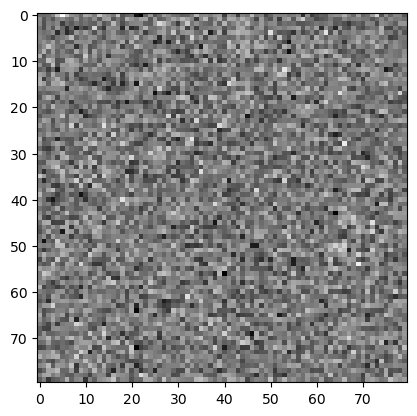

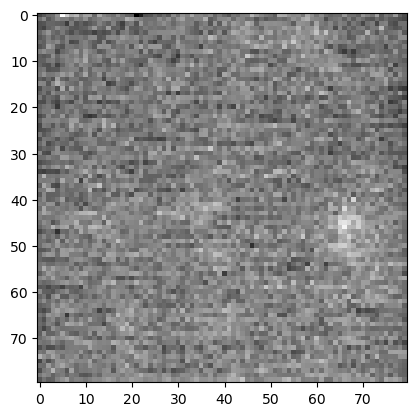

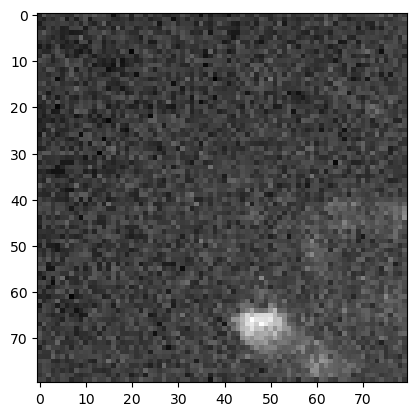

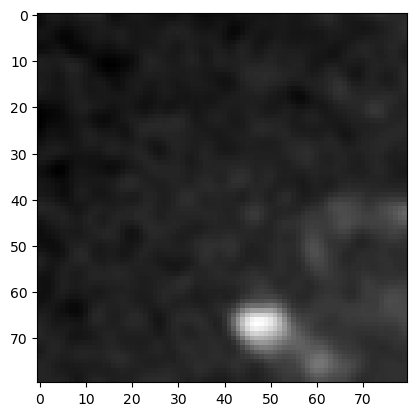

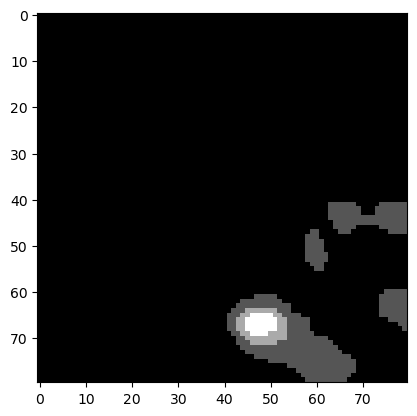

In [107]:
# Visualize one frame for full processing steps
frame_num = 1547 # 1447 or frame_num

plt.imshow(test['data119_cathodic_dF'][:, :, frame_num], cmap='gray')
plt.show()

plt.imshow(temp_data[:, :, frame_num], cmap='gray')
plt.show()

plt.imshow(space_data1[frame_num, :, :], cmap='gray')
plt.show()

plt.imshow(space_data2[frame_num, :, :], cmap='gray')
plt.show()

plt.imshow(space_data3[frame_num, :, :], cmap='gray')
plt.show()

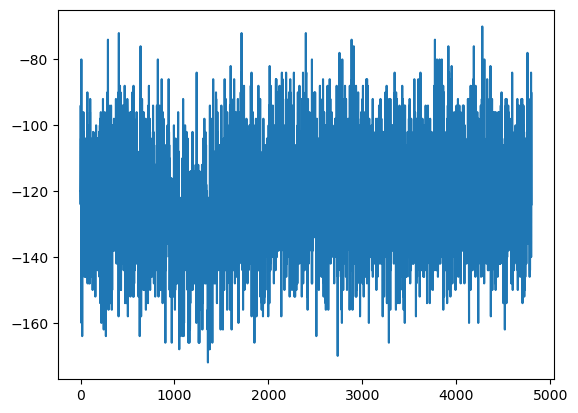

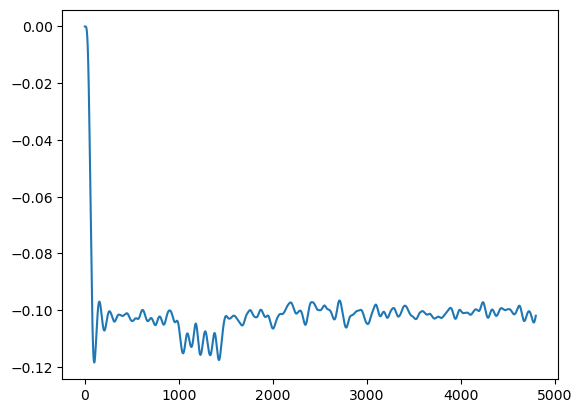

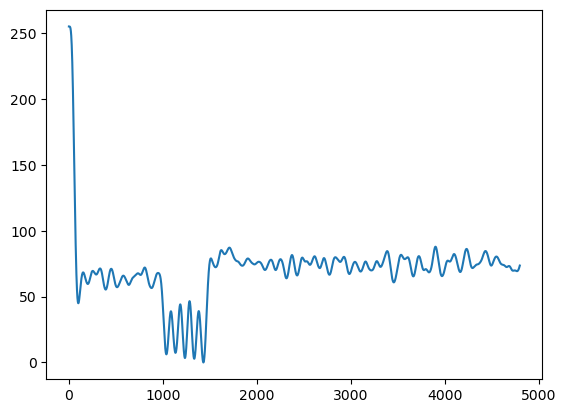

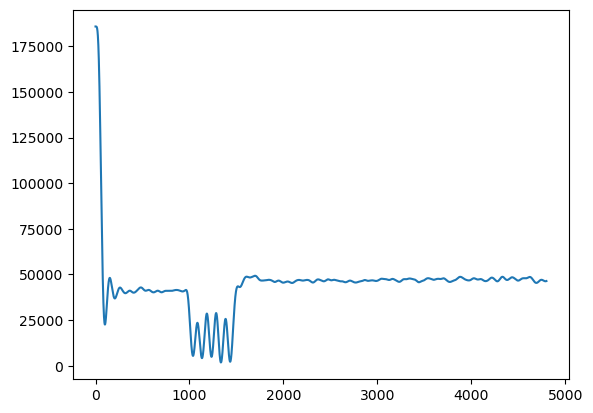

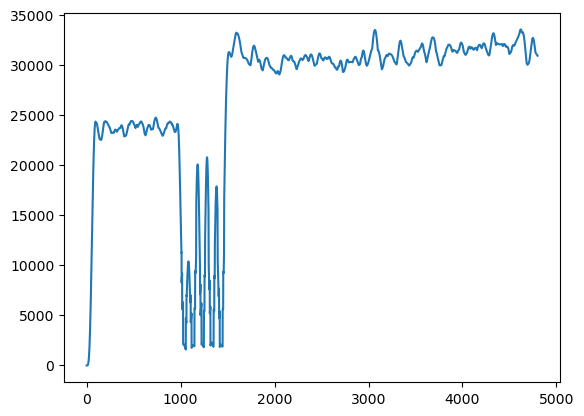

In [108]:
x_coord, y_coord = 65, 50

plt.plot(range(test['data119_cathodic_dF'].shape[-1]-200), test['data119_cathodic_dF'][x_coord, y_coord, 100:4900])
plt.show()

plt.plot(range(temp_data.shape[-1]), temp_data[x_coord, y_coord, :])
plt.show()

plt.plot(range(space_data1.shape[0]), space_data1[:, x_coord, y_coord])
plt.show()

plt.plot(range(space_data2.shape[0]), space_data2[:, x_coord, y_coord])
plt.show()

plt.plot(range(space_data3.shape[0]), space_data3[:, x_coord, y_coord])
plt.show()

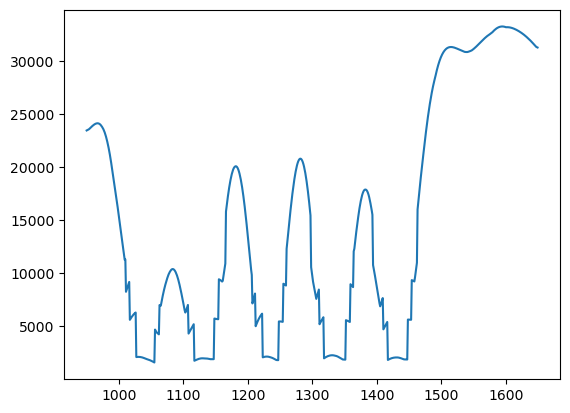

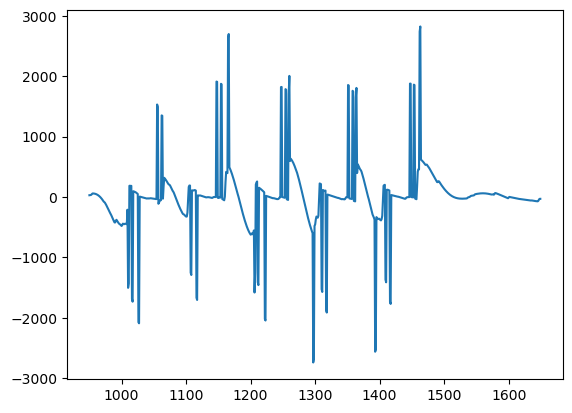

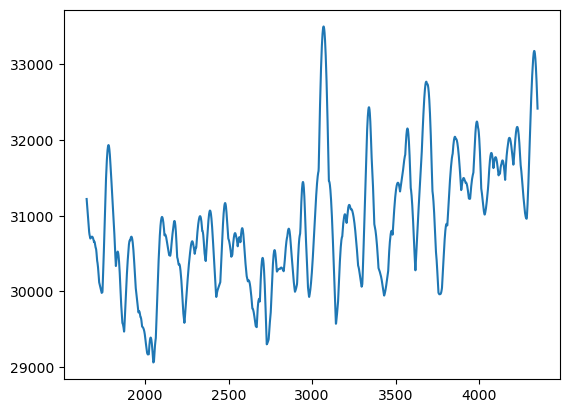

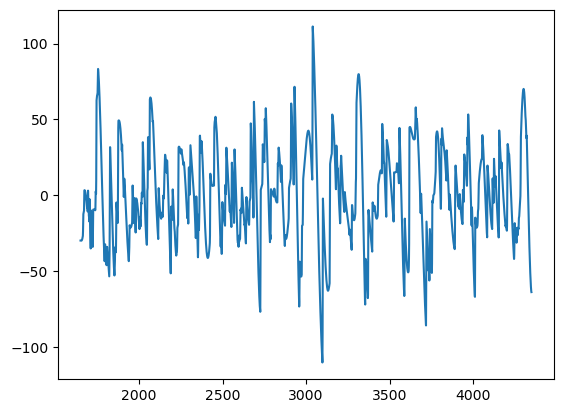

In [120]:
plt.plot(range(950, 1650), space_data3[950:1650, 65, 50])
plt.show()

plt.plot(range(950, 1650), np.gradient(space_data3[950:1650, 65, 50]))
plt.show()

plt.plot(range(1650, 4350), space_data3[1650:4350, 65, 50])
plt.show()

plt.plot(range(1650, 4350), np.gradient(space_data3[1650:4350, 65, 50]))
plt.show()

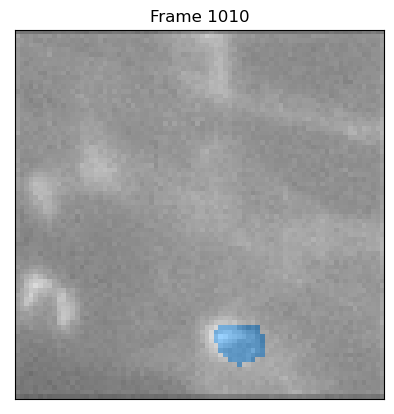

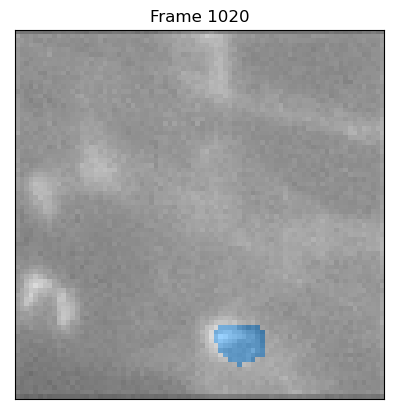

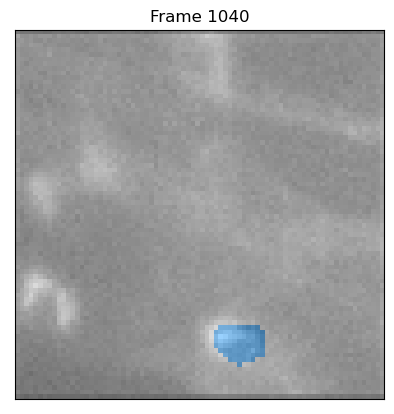

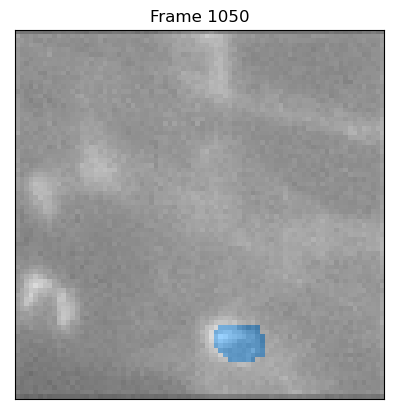

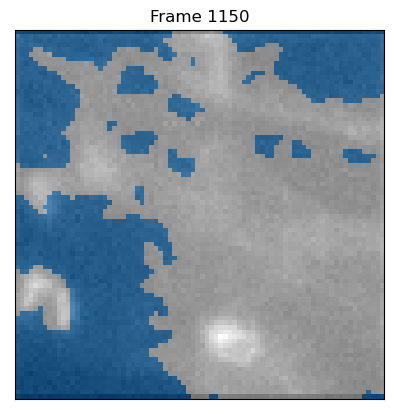

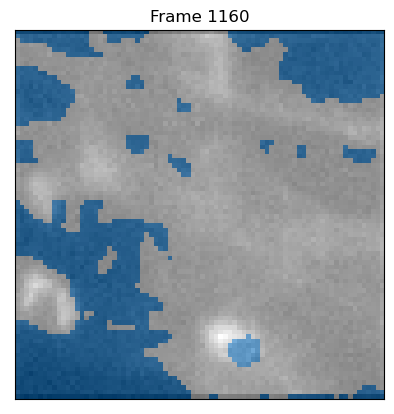

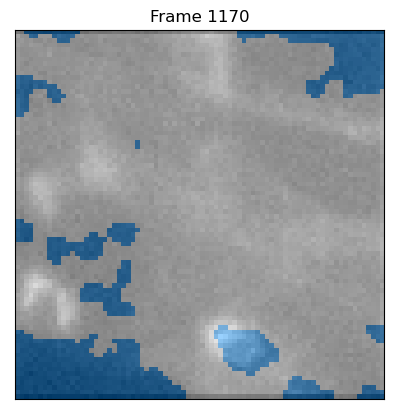

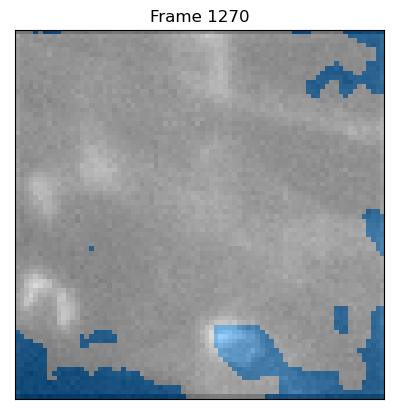

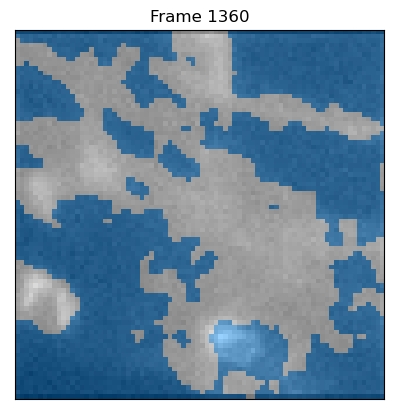

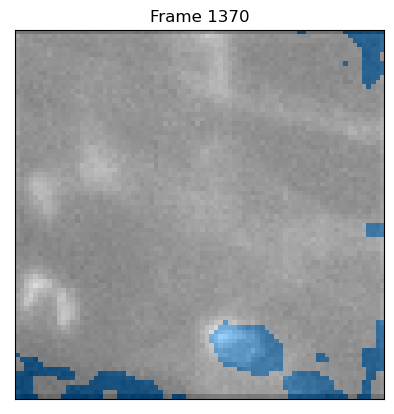

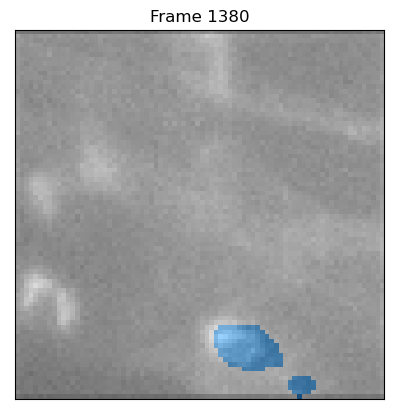

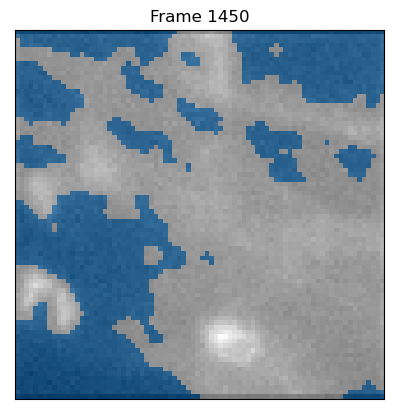

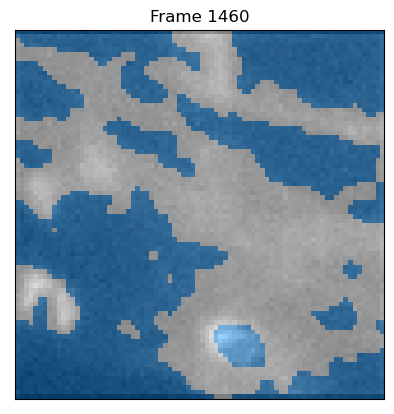

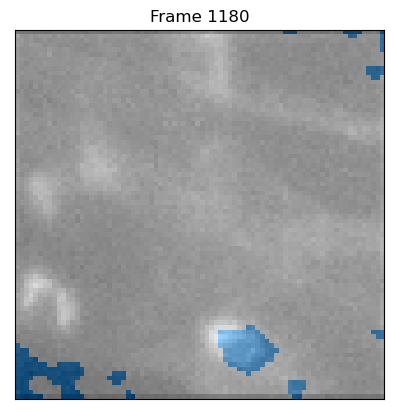

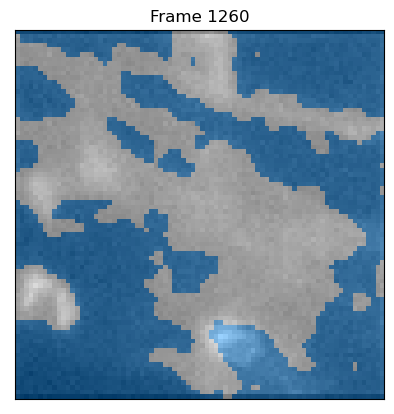

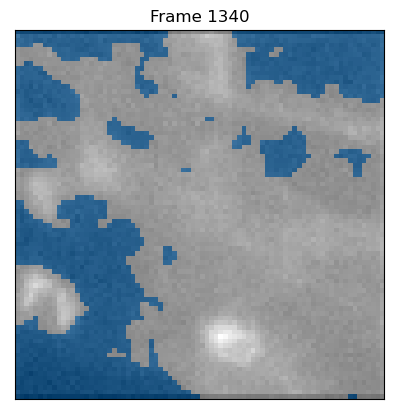

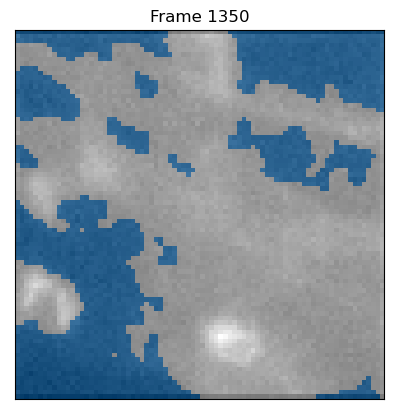

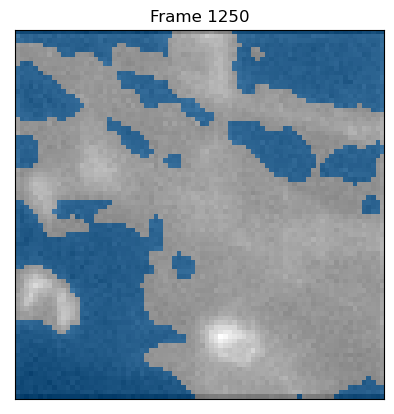

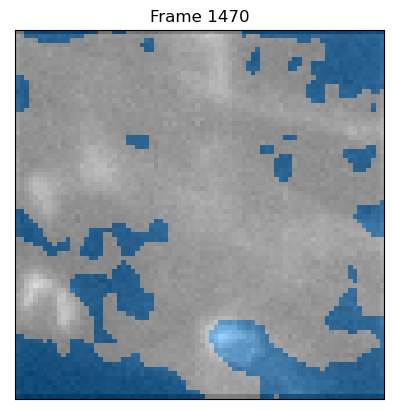

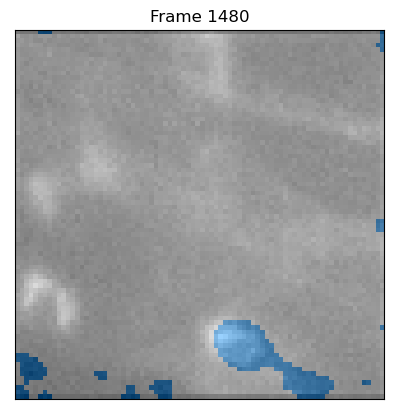

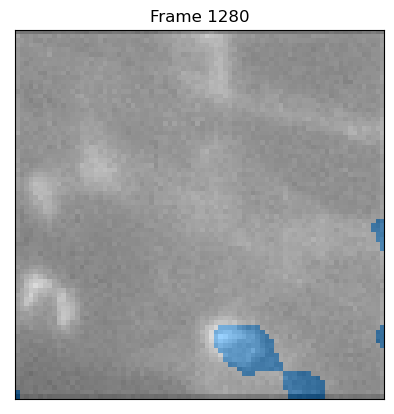

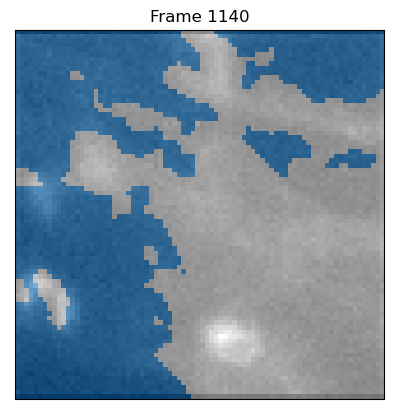

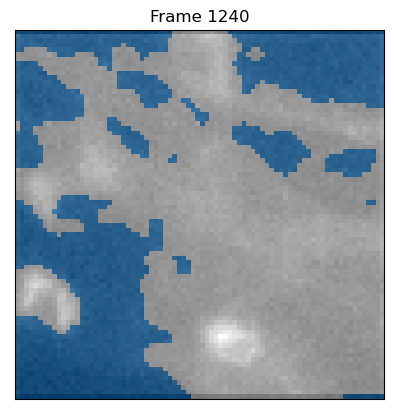

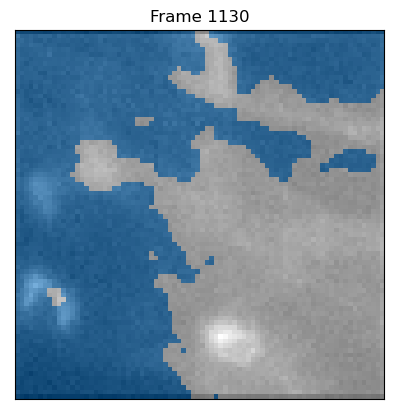

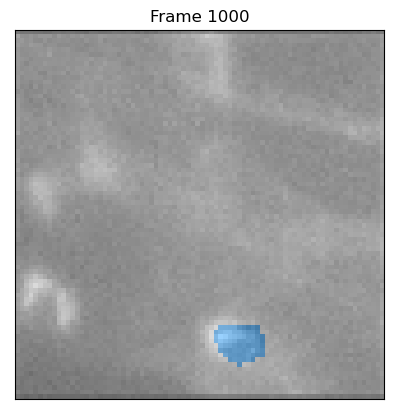

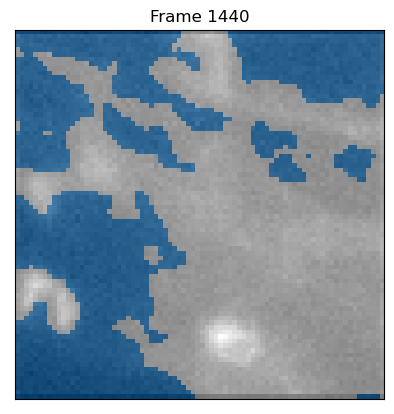

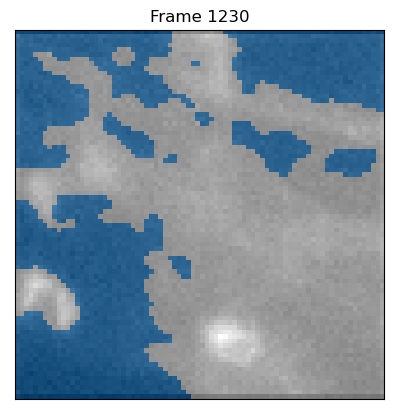

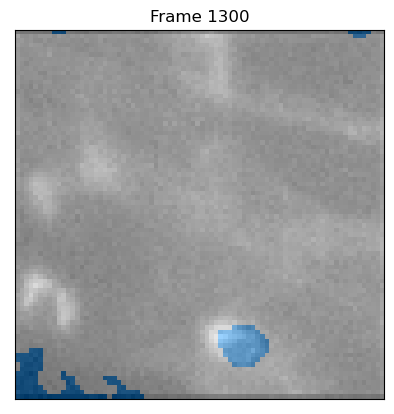

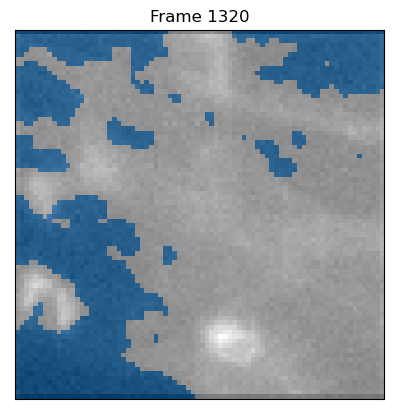

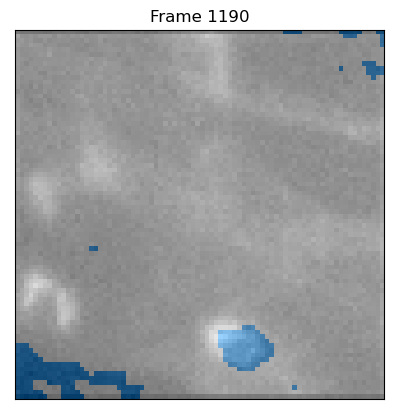

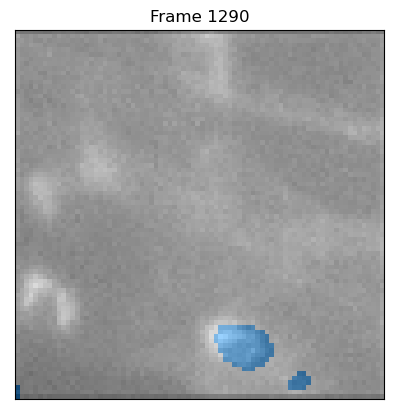

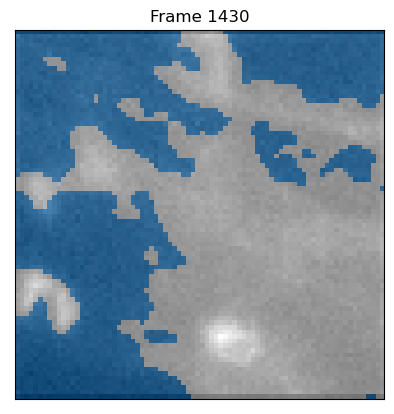

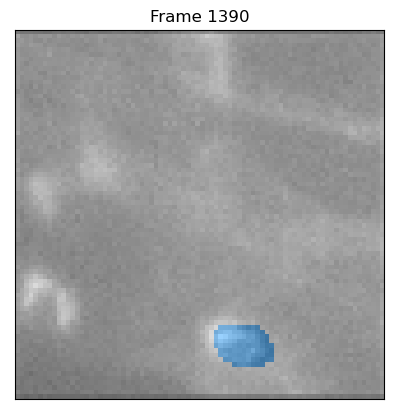

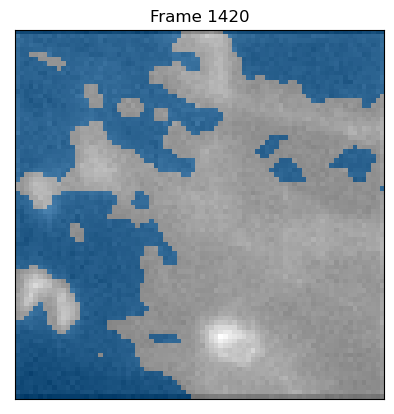

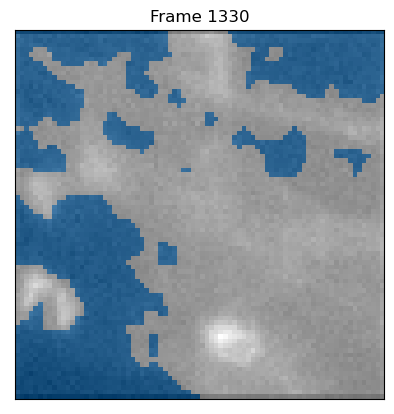

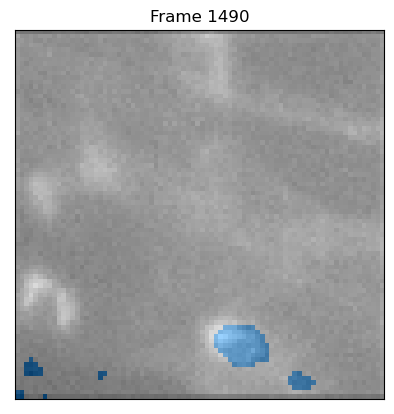

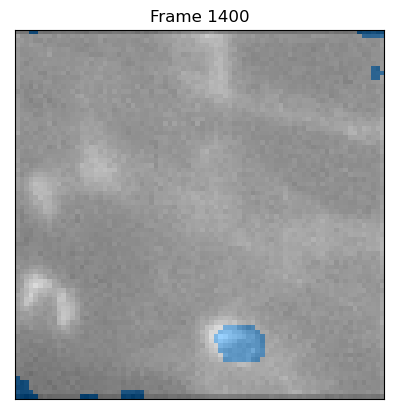

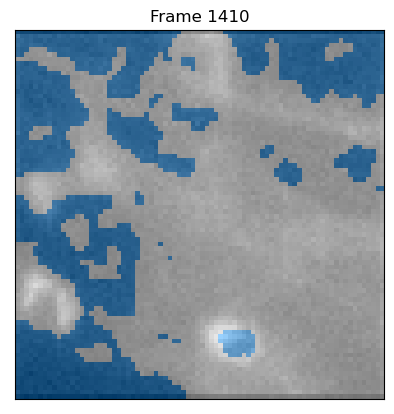

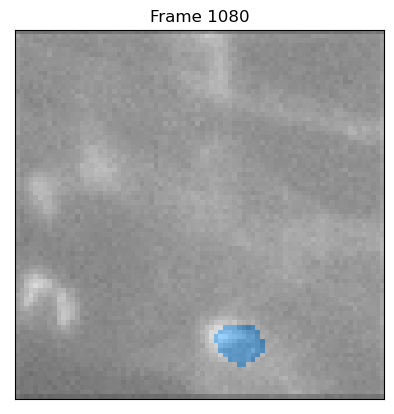

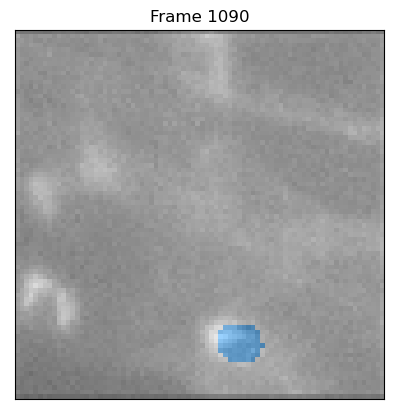

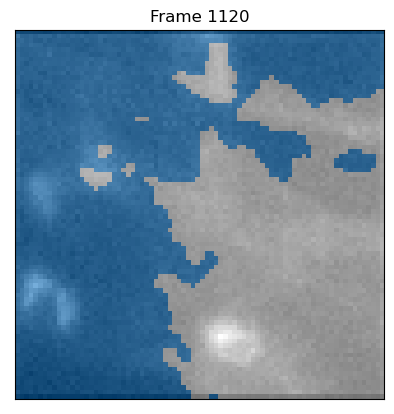

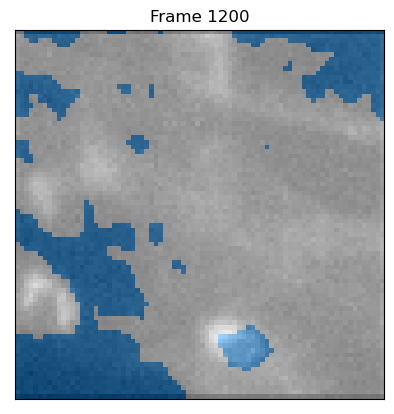

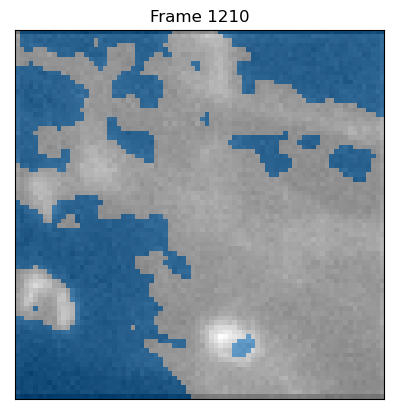

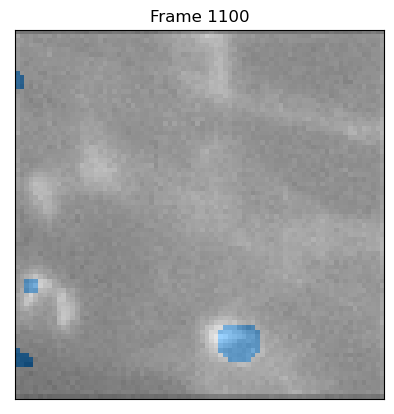

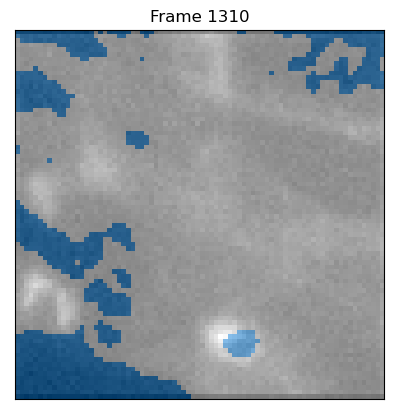

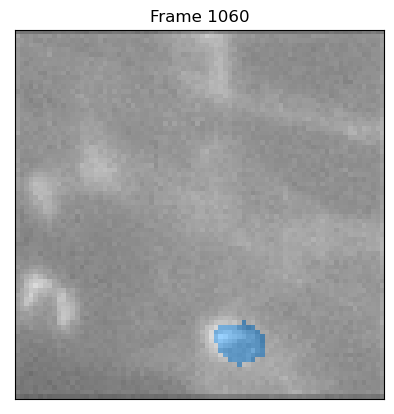

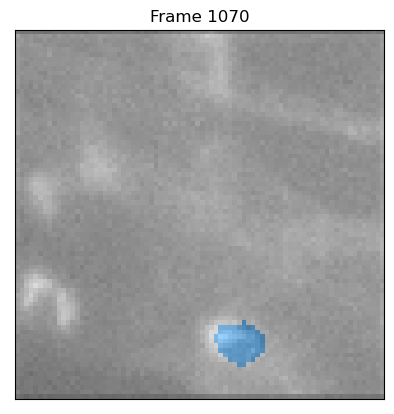

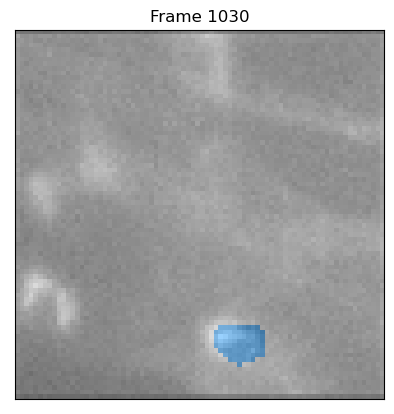

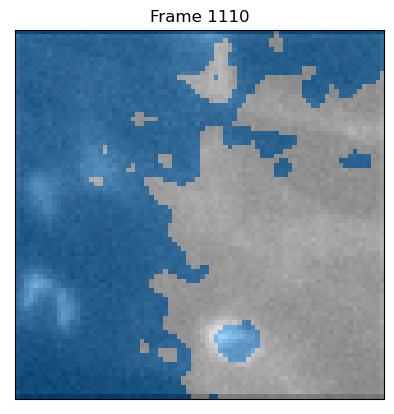

In [113]:
colors = ['#ffffff', '#008cfd']

frame_num_lst = []
for x_coord in range(space_data3.shape[1]):
    for y_coord in range(space_data3.shape[-1]):
        for frame_num in range(900, 1400, 10):

            baseline1 = np.mean(space_data3[frame_num-50:frame_num, x_coord, y_coord])
            baseline2 = np.mean(space_data3[frame_num:frame_num+50, x_coord, y_coord])
            signal_pnt = space_data3[frame_num, x_coord, y_coord]

            # Detect depolarization
            if (baseline1 > signal_pnt) and (signal_pnt > baseline2):
                if frame_num not in frame_num_lst:
                    frame_num_lst.append(frame_num)
                    if np.unique(space_data3[frame_num, :, :]).shape[0] > 1:
                        fig, ax = plt.subplots(1)
                        ax.imshow(img_data[:, :], cmap='gray')
                        ax.imshow(space_data3[frame_num, :, :], cmap=matplotlib.colors.ListedColormap(colors), alpha=0.4)
                        ax.set_xticks([])
                        ax.set_yticks([])
                        plt.title(f'Frame {frame_num+100}')
                        plt.savefig(f'c:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\figures\\Fig3\\Results\\{frame_num+100}.png')
                        plt.show()

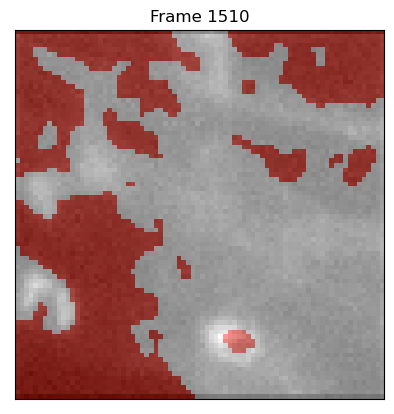

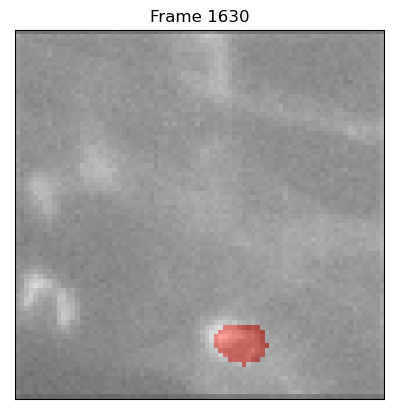

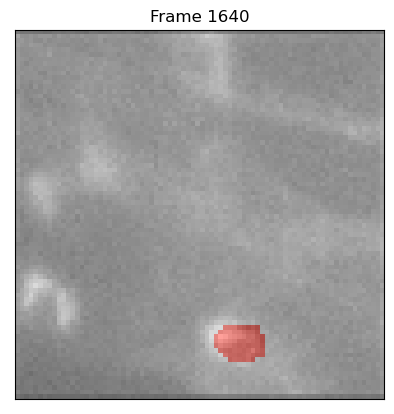

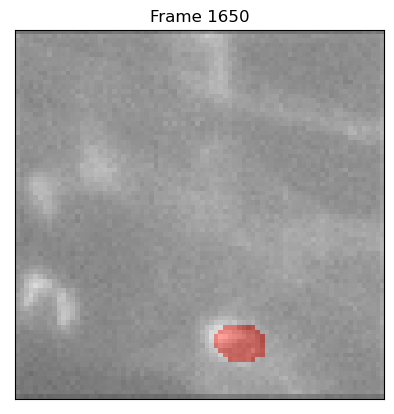

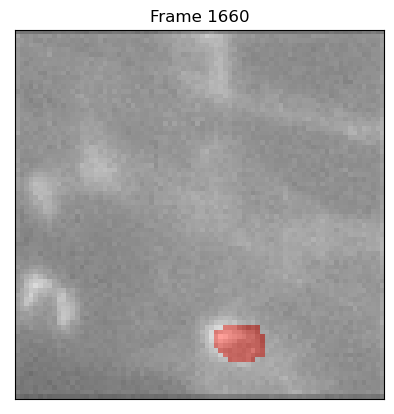

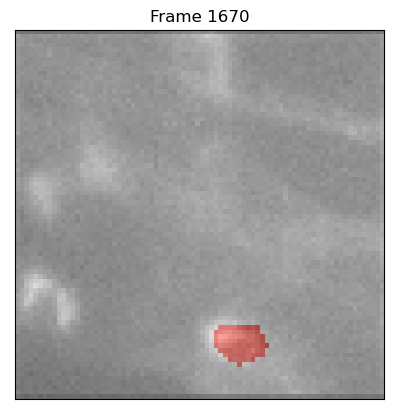

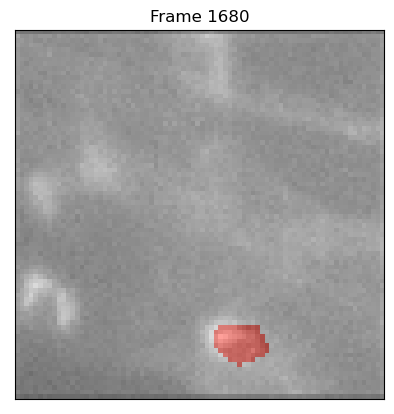

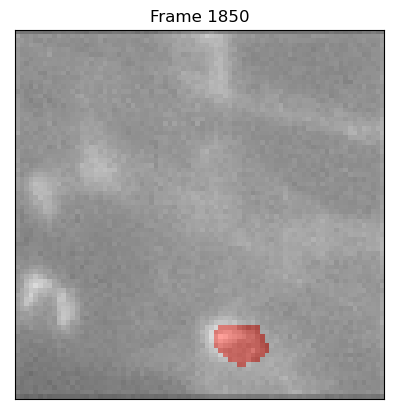

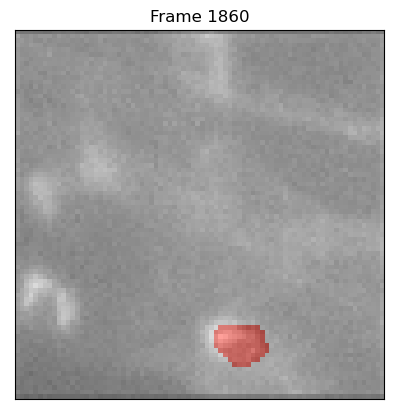

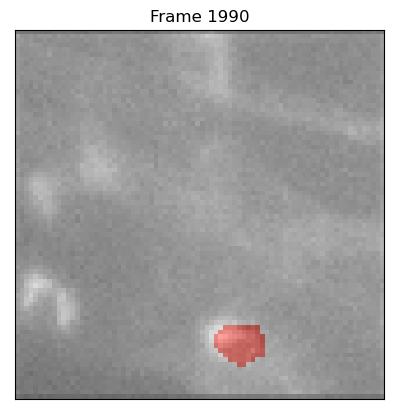

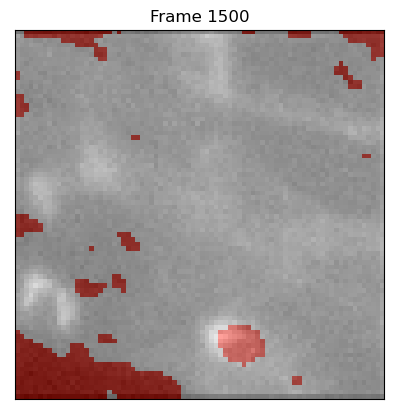

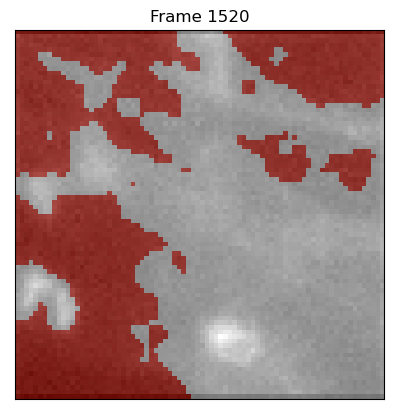

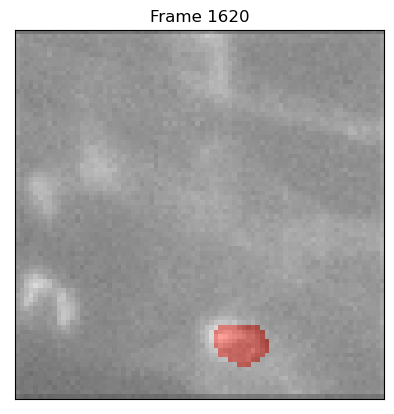

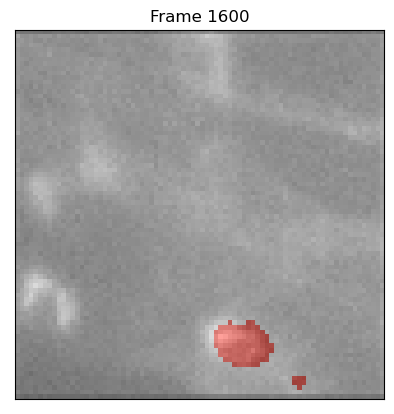

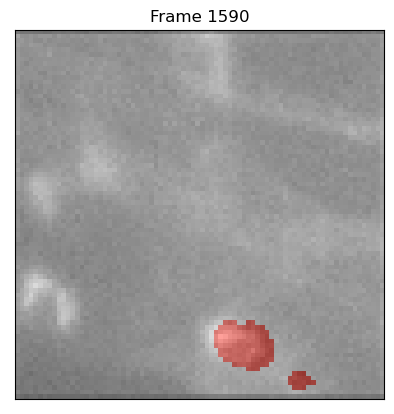

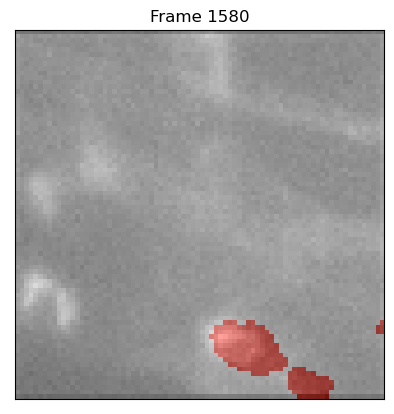

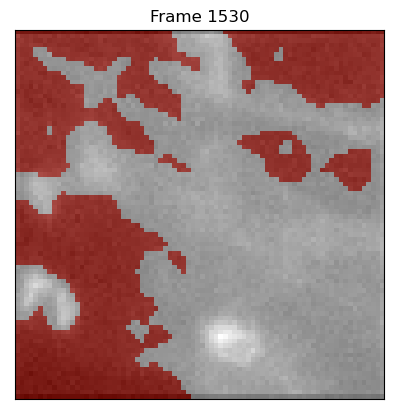

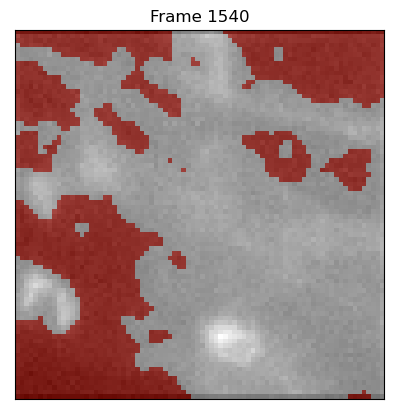

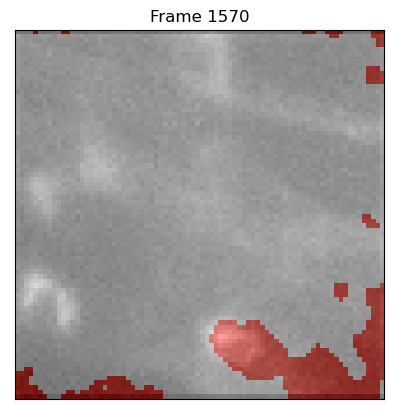

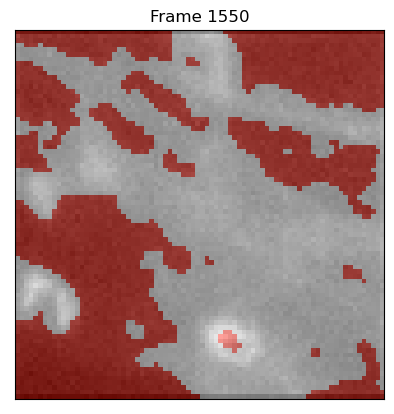

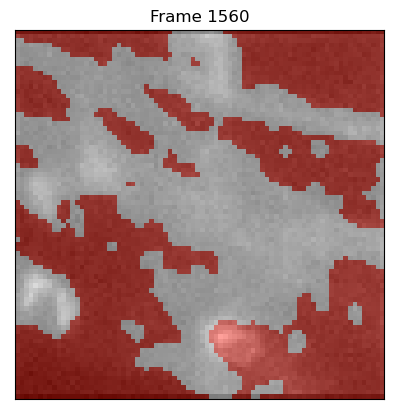

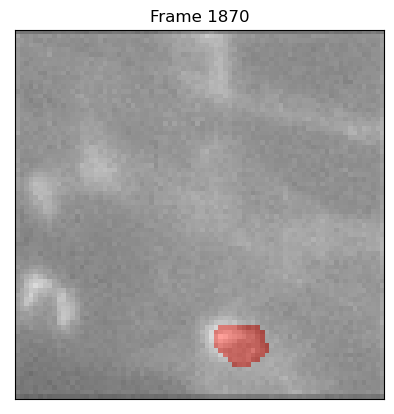

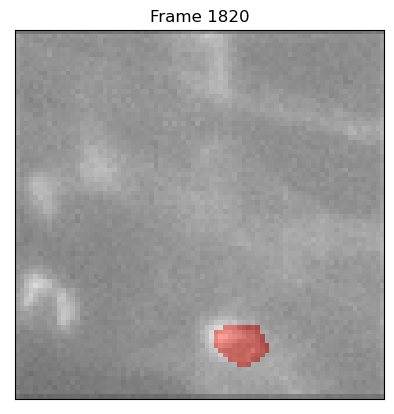

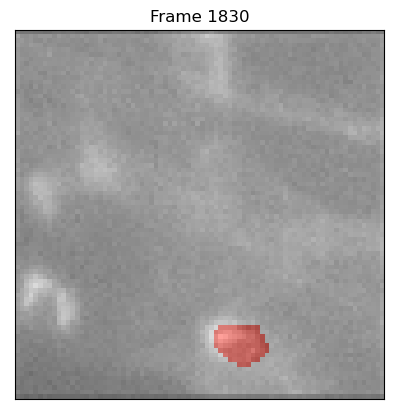

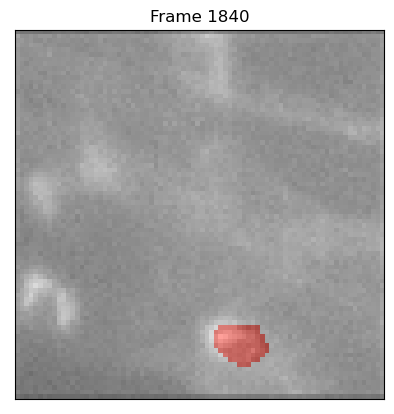

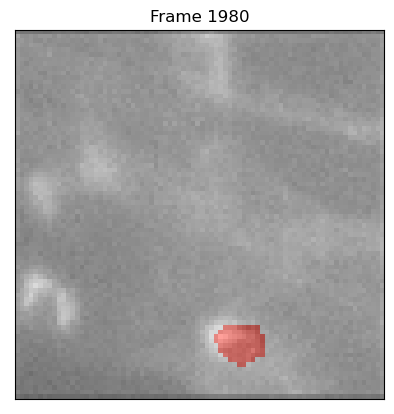

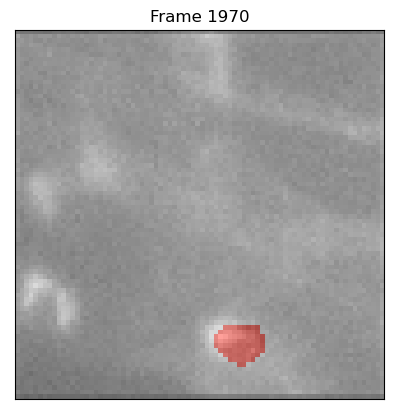

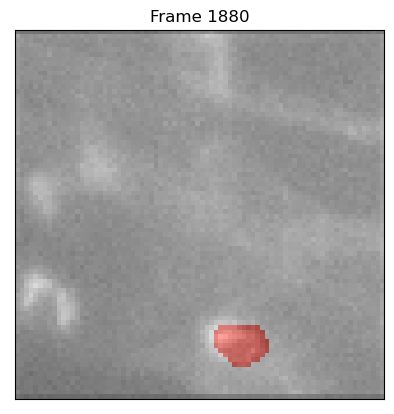

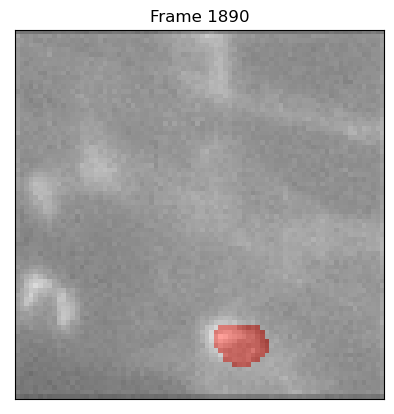

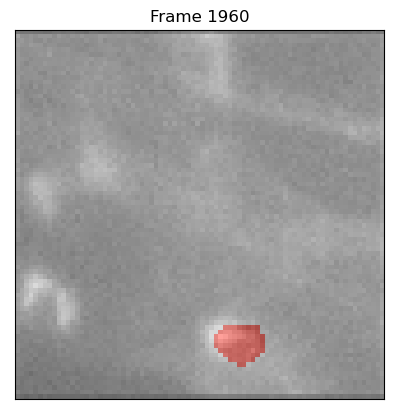

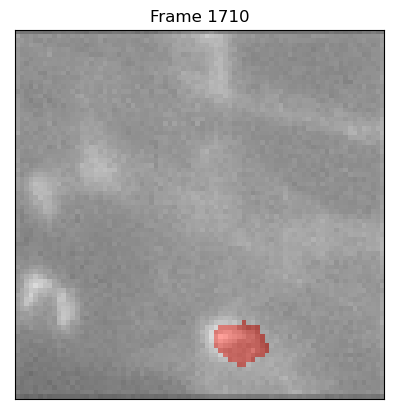

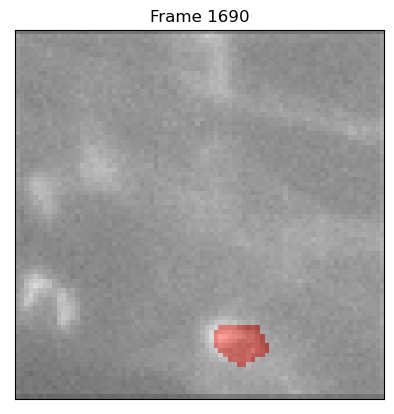

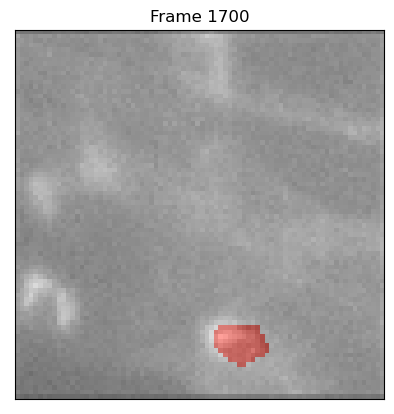

In [114]:
colors = ['#ffffff', '#ff1203']

frame_num_lst = []
for x_coord in range(space_data3.shape[1]):
    for y_coord in range(space_data3.shape[-1]):
        for frame_num in range(1400, 1900, 10):

            baseline1 = np.mean(space_data3[frame_num-50:frame_num, x_coord, y_coord])
            baseline2 = np.mean(space_data3[frame_num:frame_num+50, x_coord, y_coord])
            signal_pnt = space_data3[frame_num, x_coord, y_coord]

            # Detect hyperpolarization
            if (baseline1 < signal_pnt) and (signal_pnt < baseline2):
                if frame_num not in frame_num_lst:
                    frame_num_lst.append(frame_num)
                    if np.unique(space_data3[frame_num, :, :]).shape[0] > 1:
                        fig, ax = plt.subplots(1)
                        ax.imshow(img_data[:, :], cmap='gray')
                        ax.imshow(space_data3[frame_num, :, :], cmap=matplotlib.colors.ListedColormap(colors), alpha=0.4)
                        ax.set_xticks([])
                        ax.set_yticks([])
                        plt.title(f'Frame {frame_num+100}')
                        plt.savefig(f'c:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\figures\\Fig3\\Results\\{frame_num+100}.png')
                        plt.show()

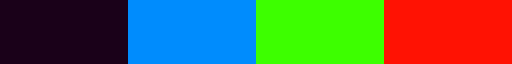

In [92]:
colors = ['#1a0119', '#008cfd', '#3dff00', '#ff1203']

matplotlib.colors.ListedColormap(colors)

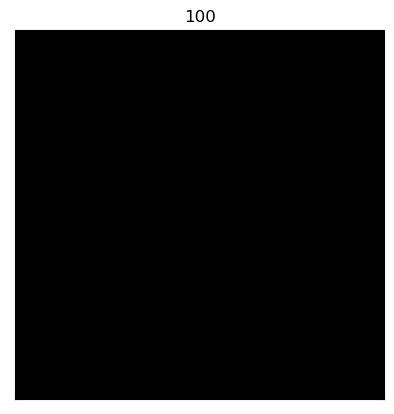

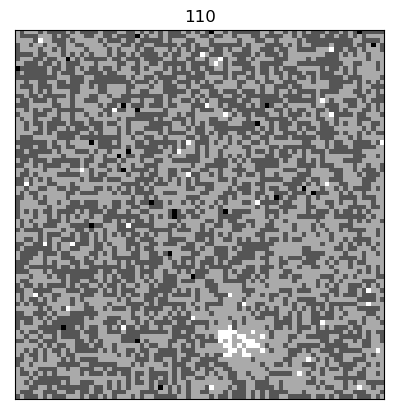

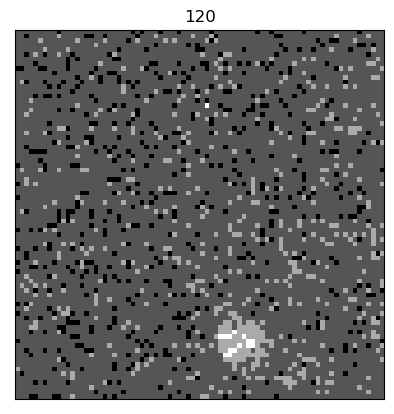

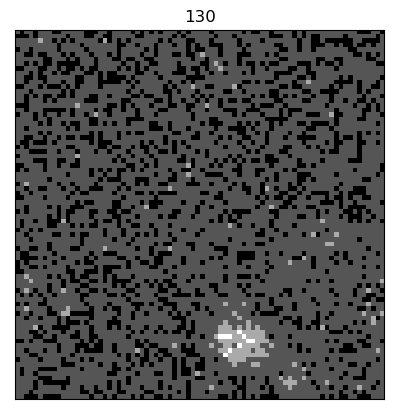

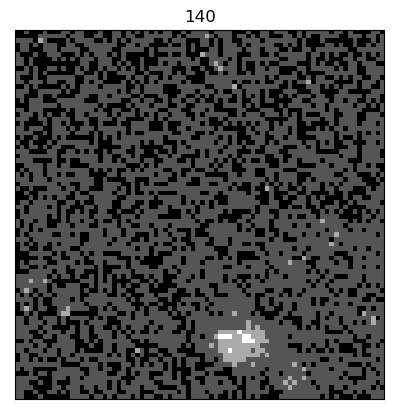

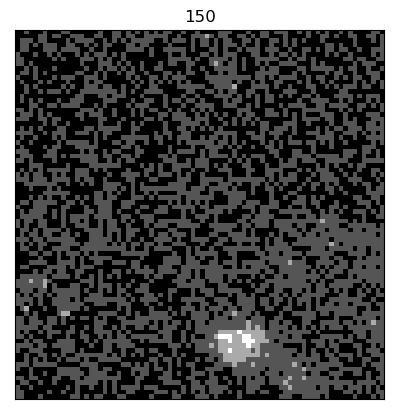

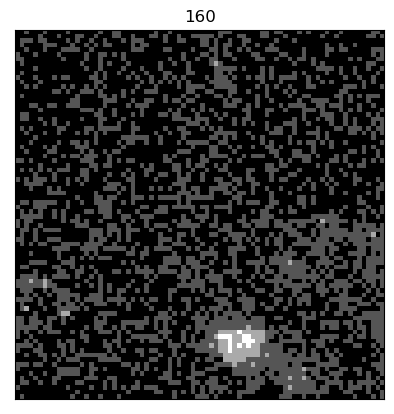

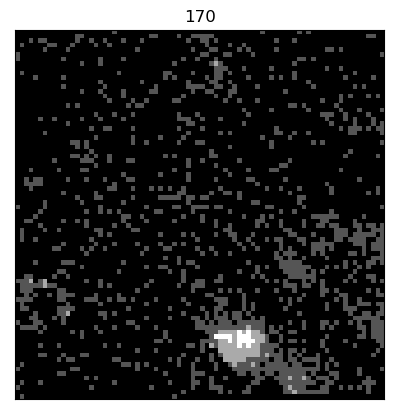

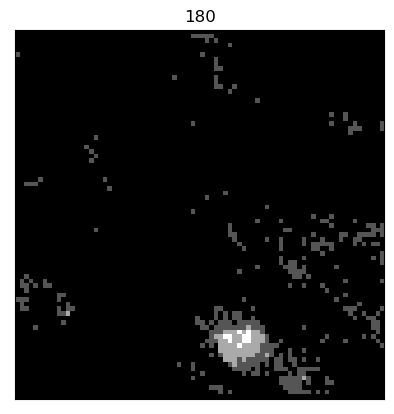

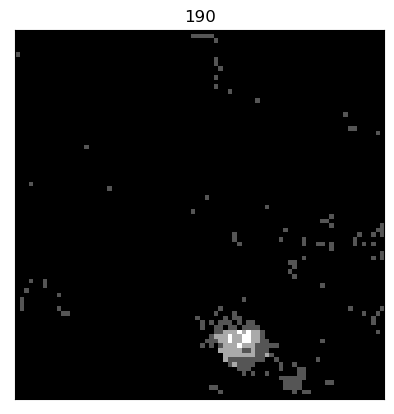

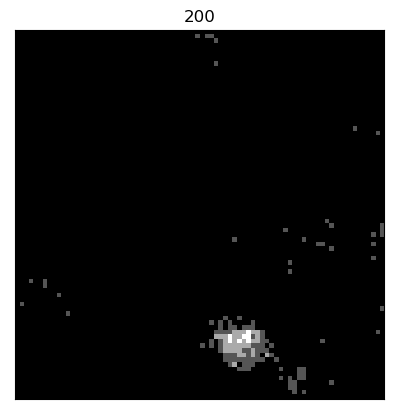

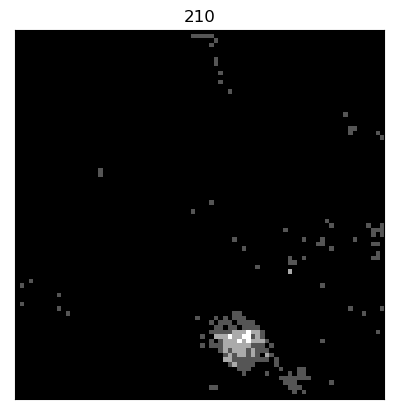

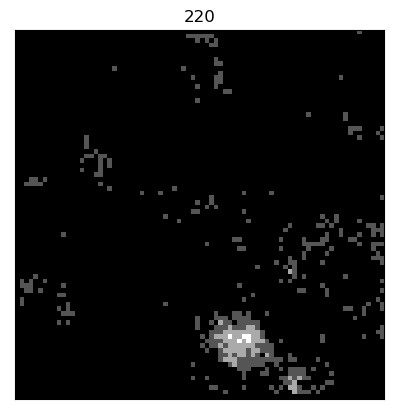

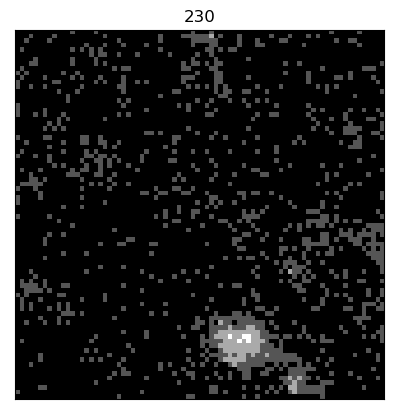

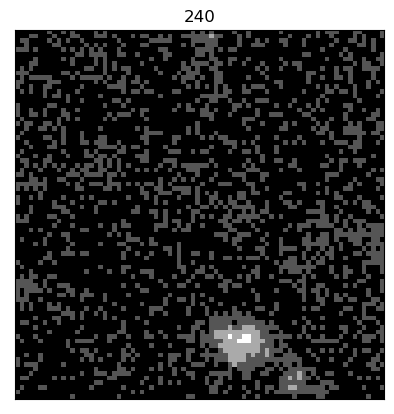

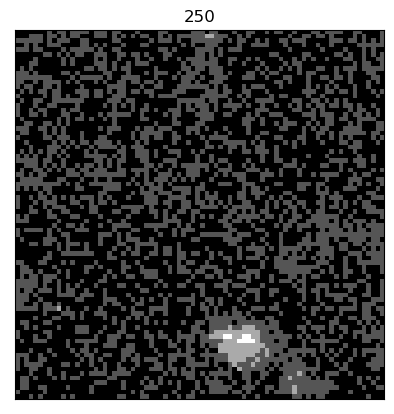

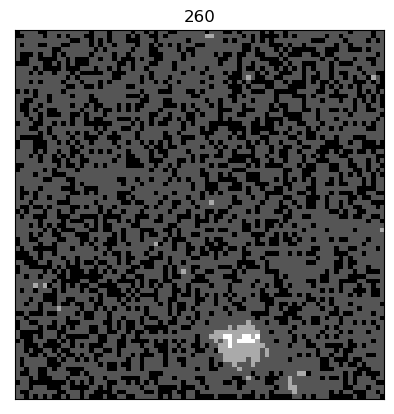

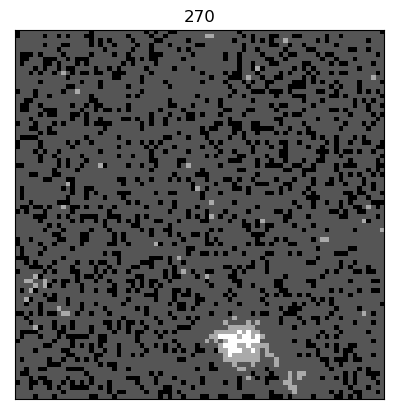

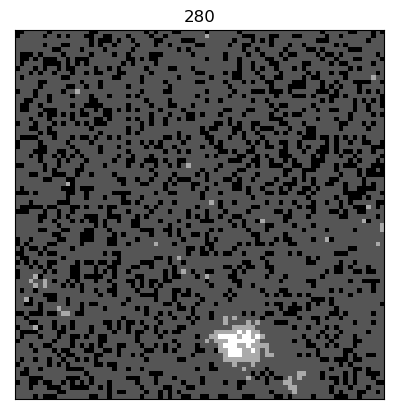

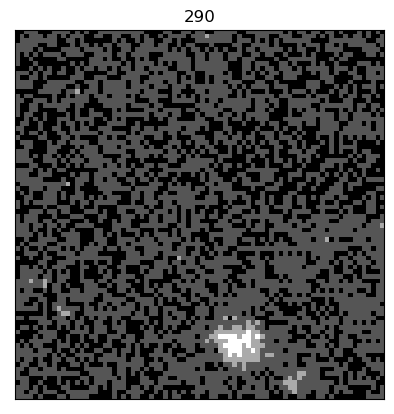

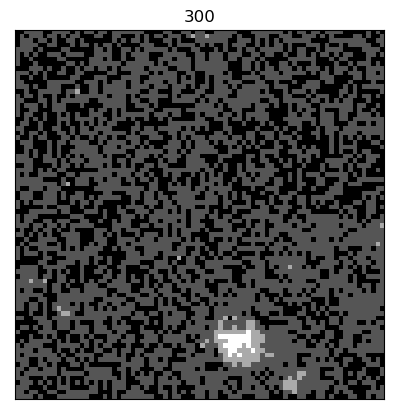

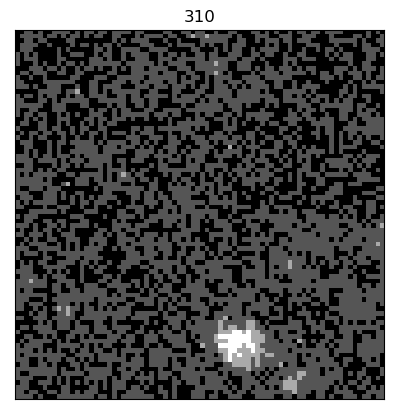

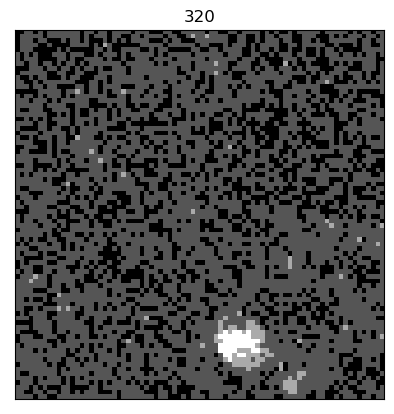

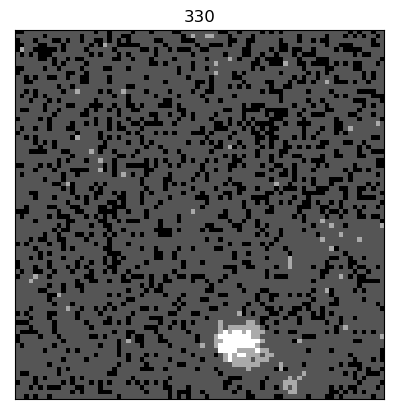

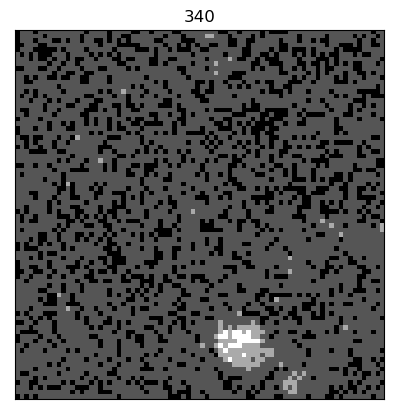

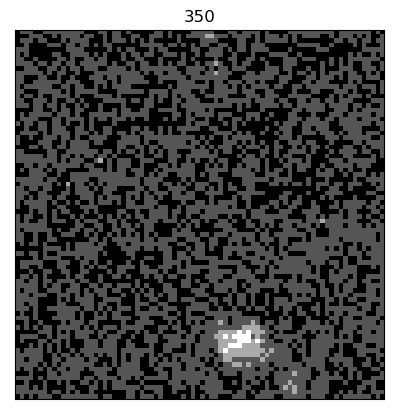

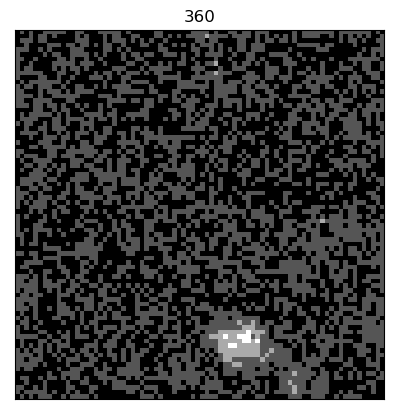

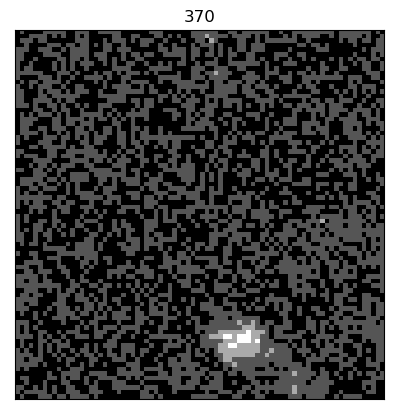

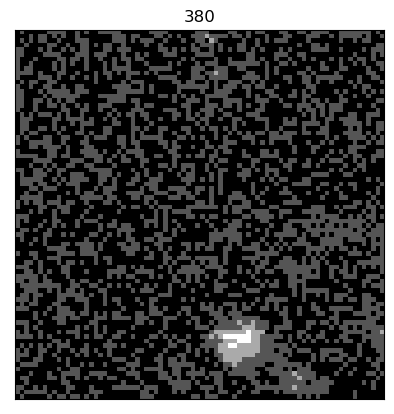

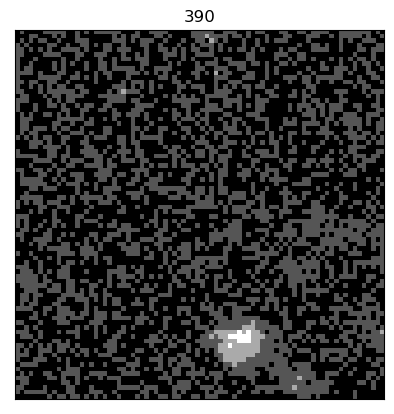

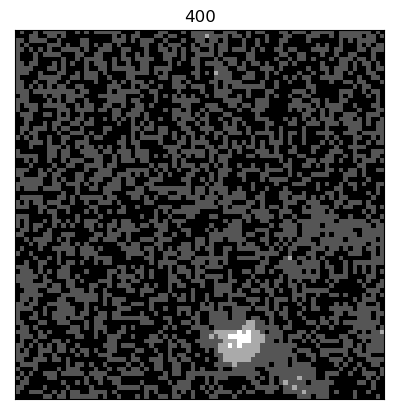

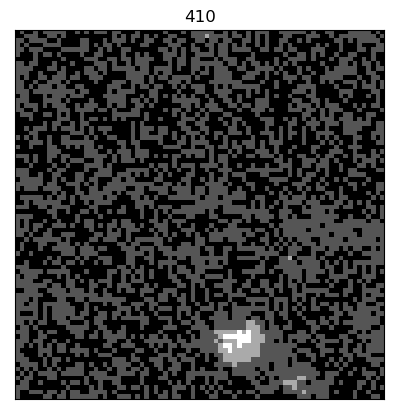

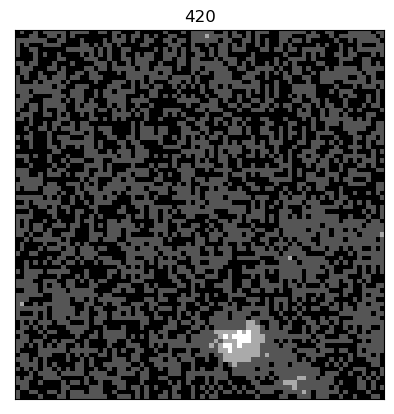

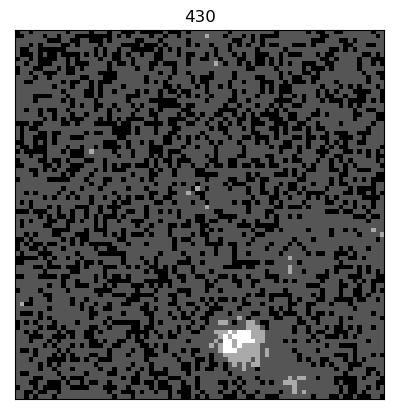

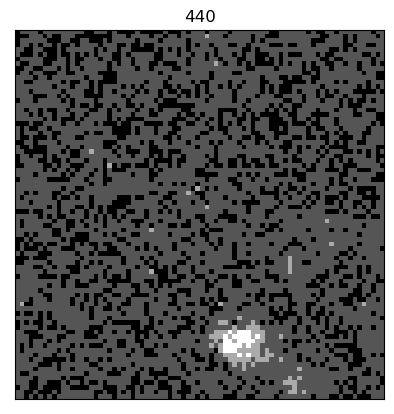

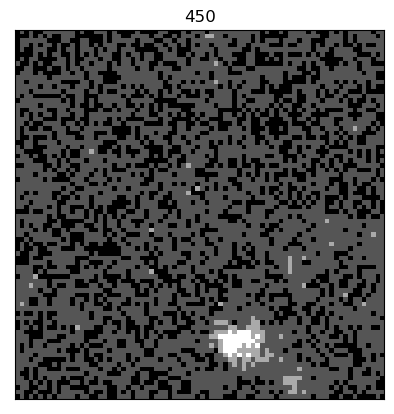

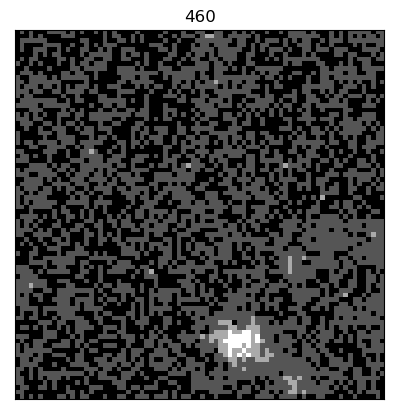

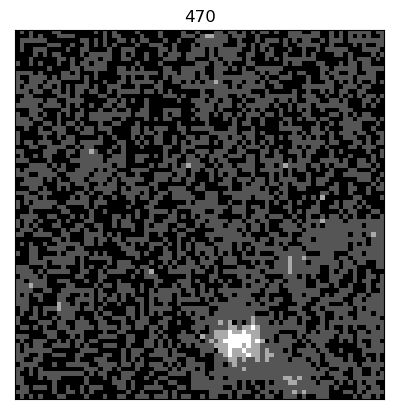

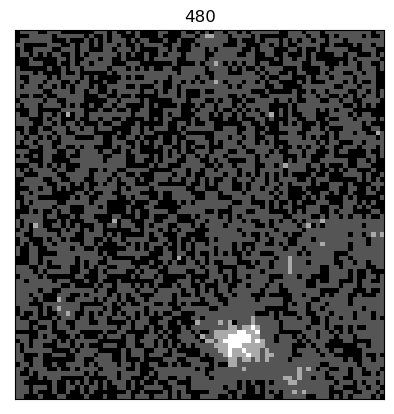

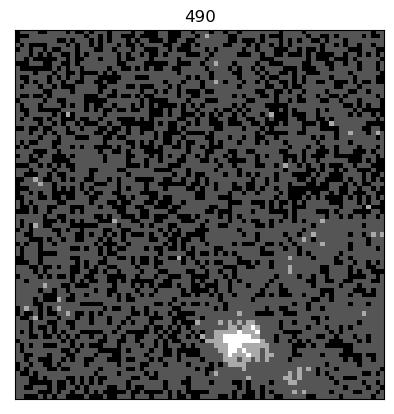

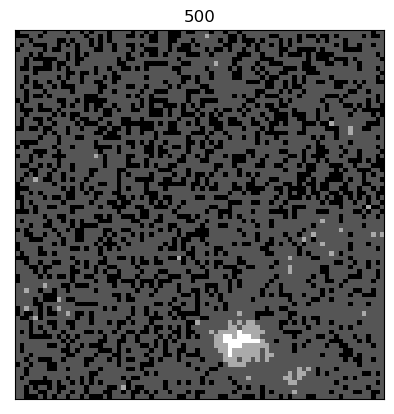

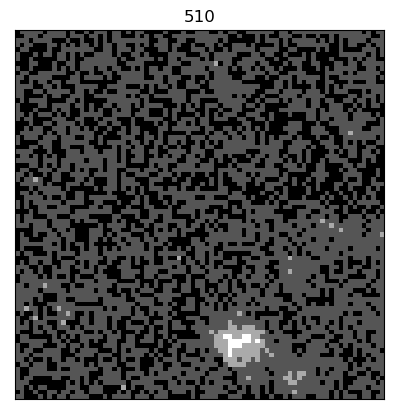

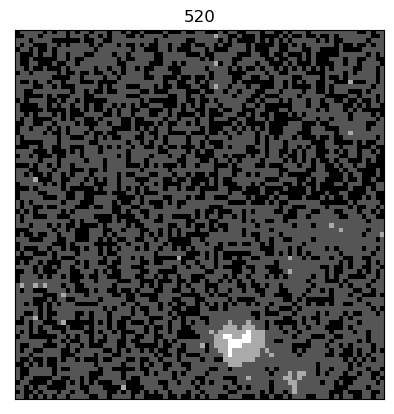

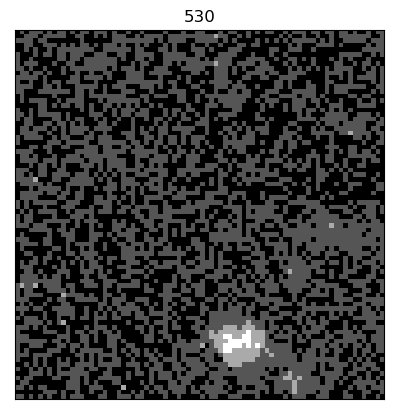

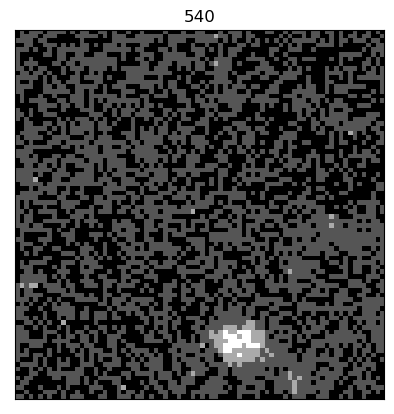

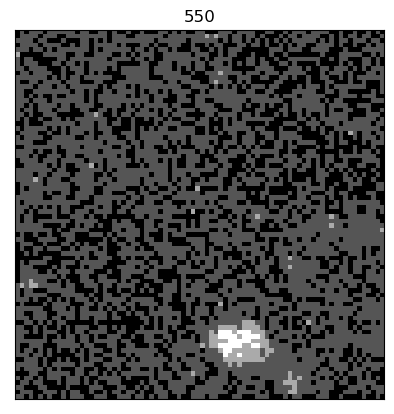

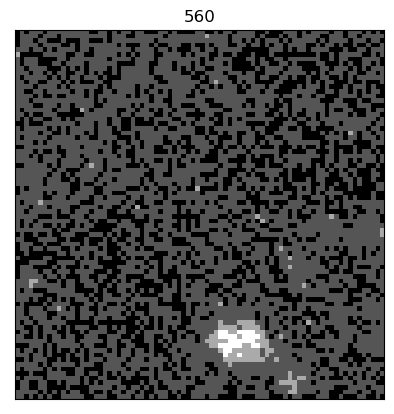

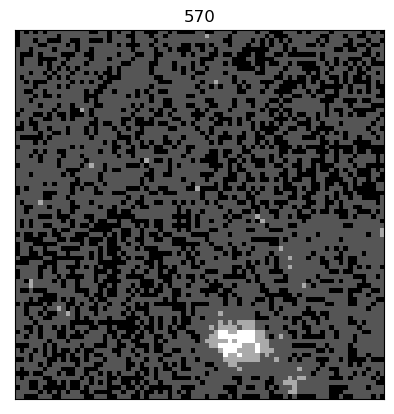

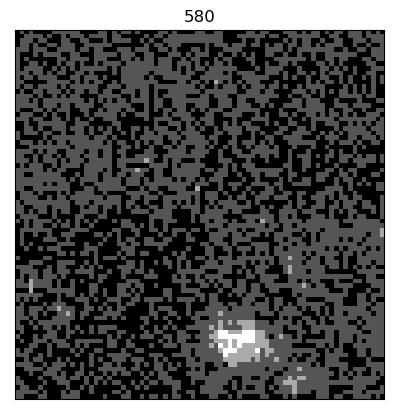

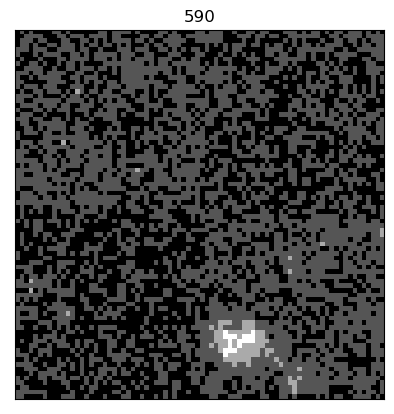

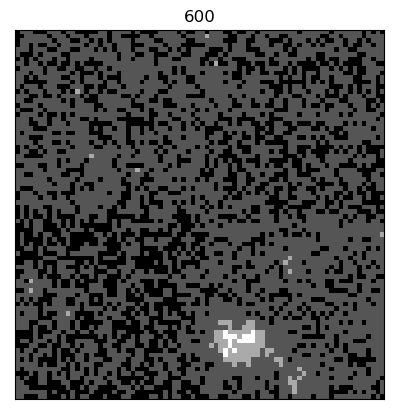

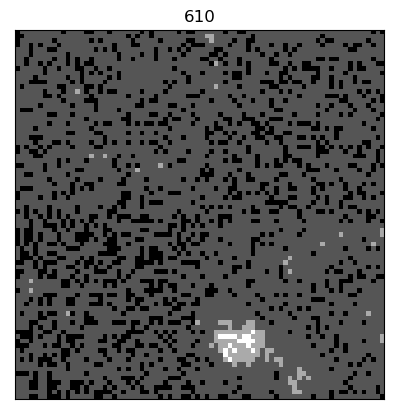

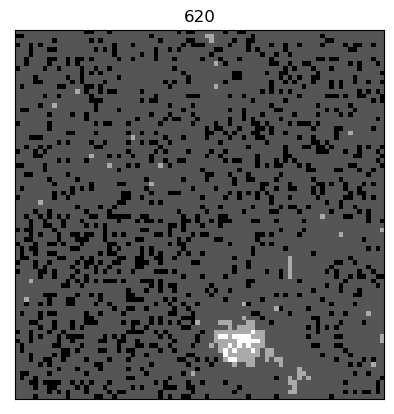

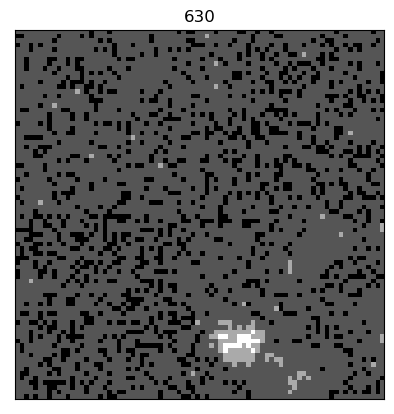

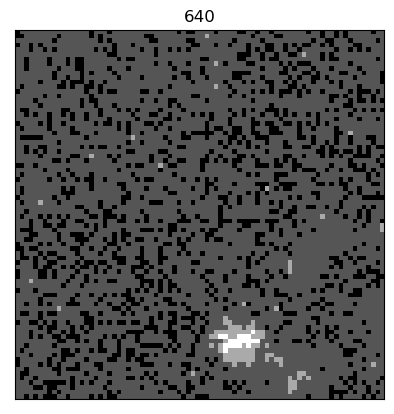

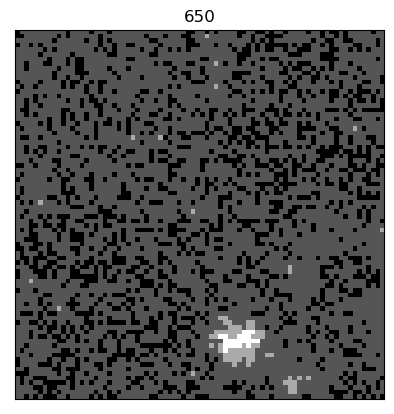

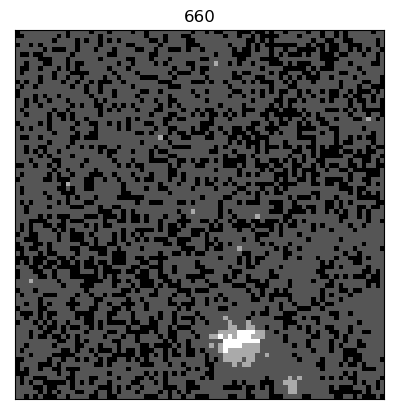

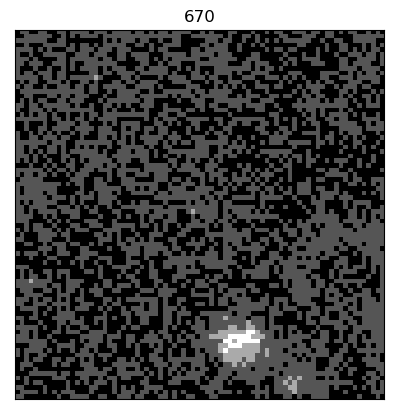

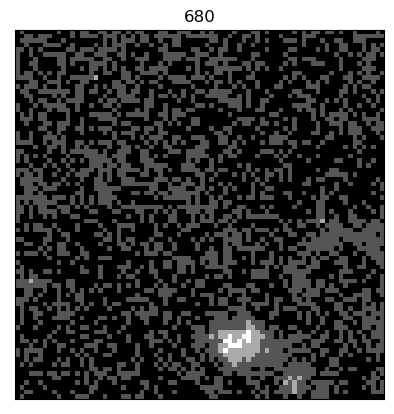

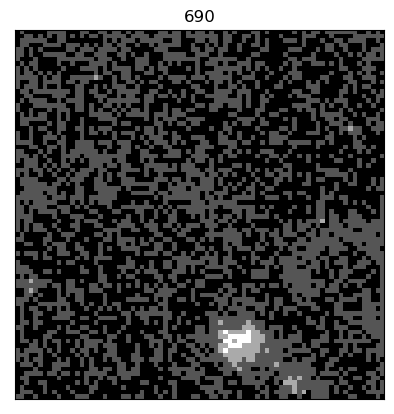

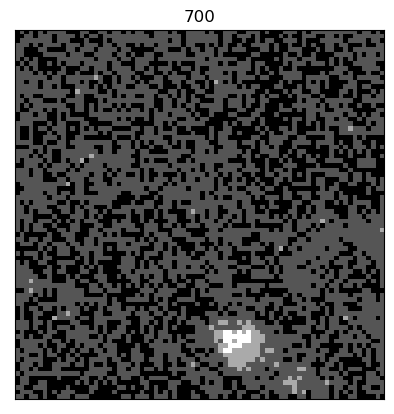

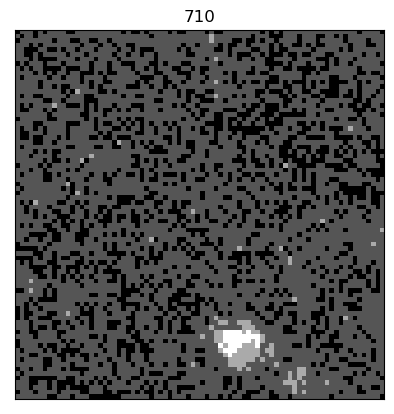

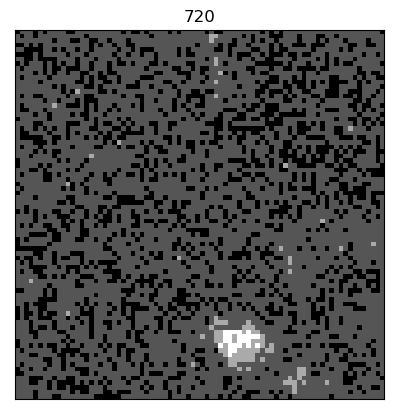

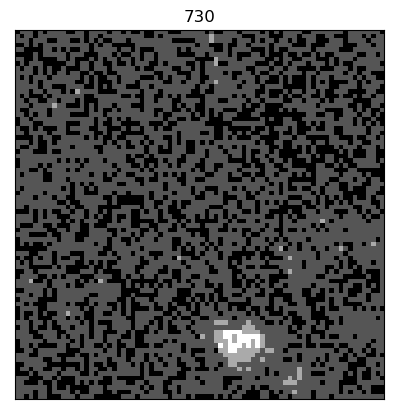

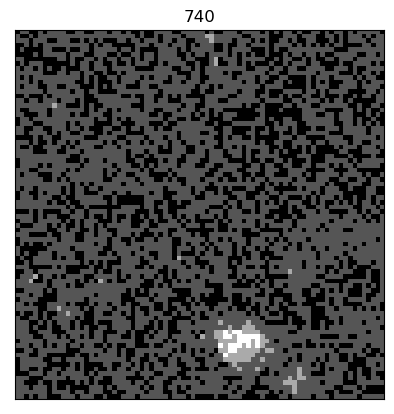

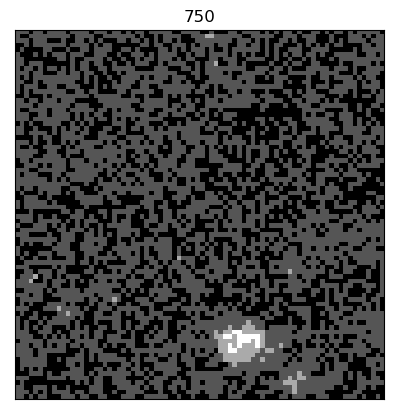

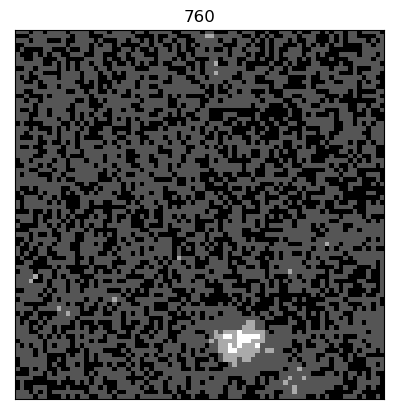

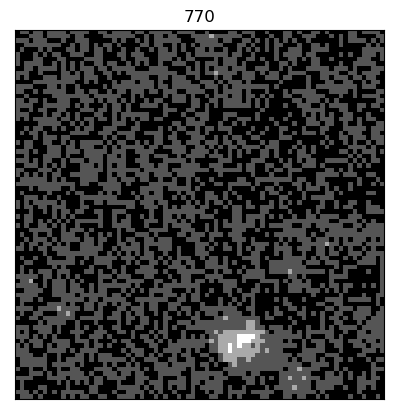

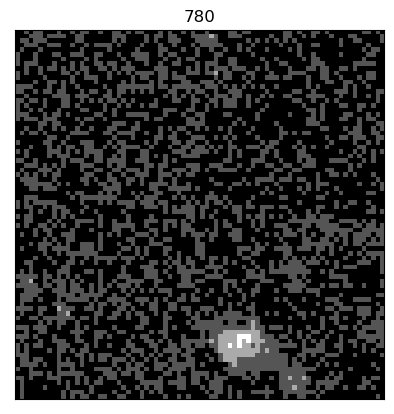

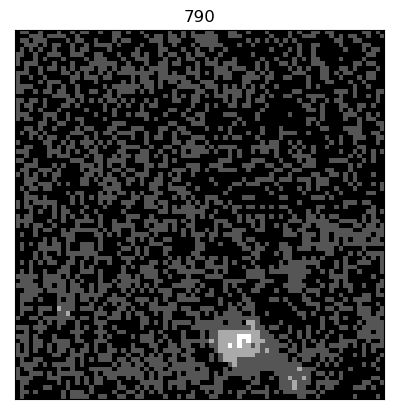

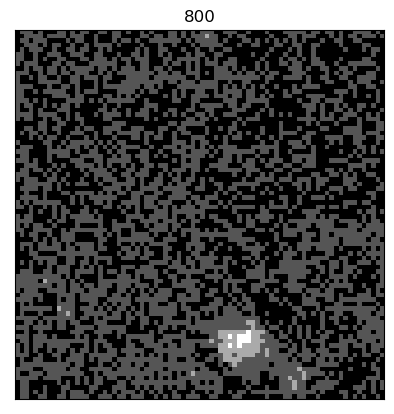

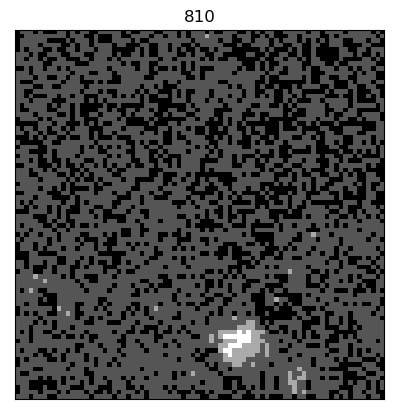

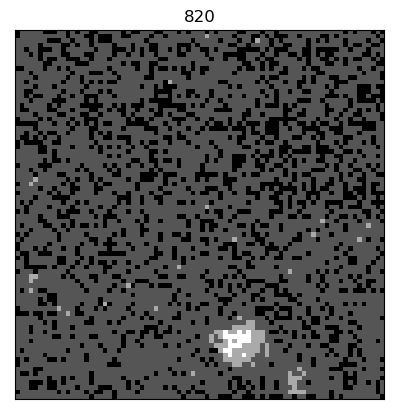

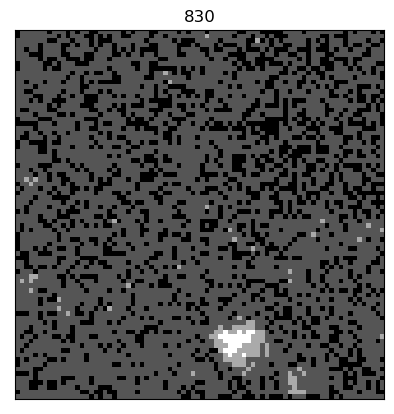

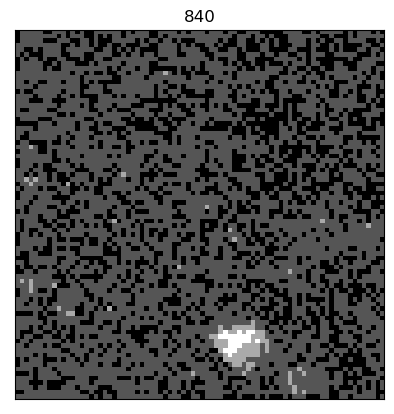

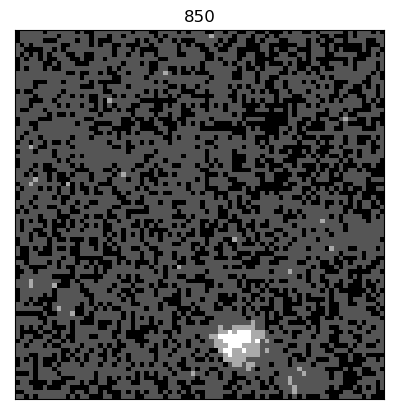

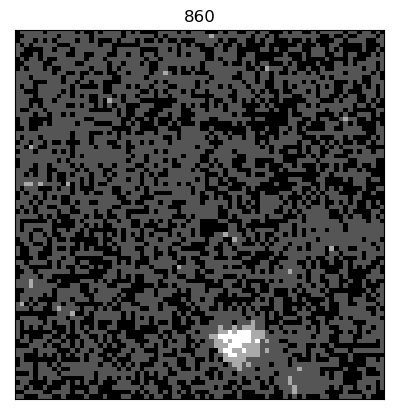

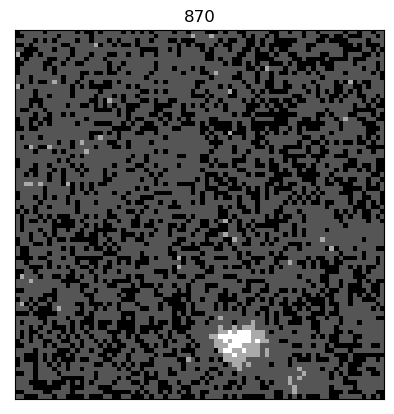

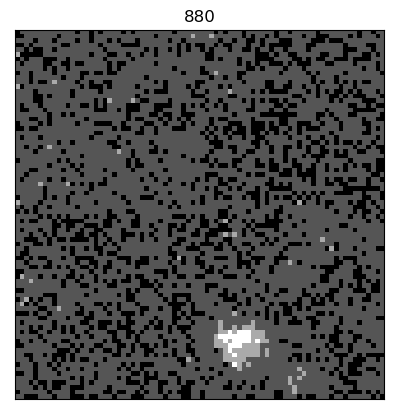

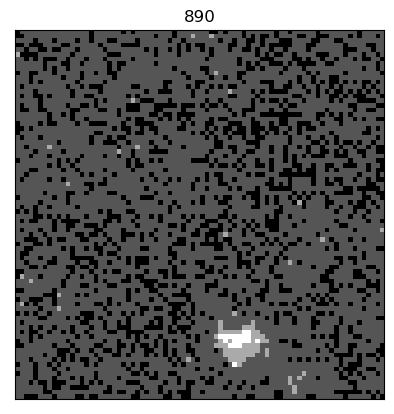

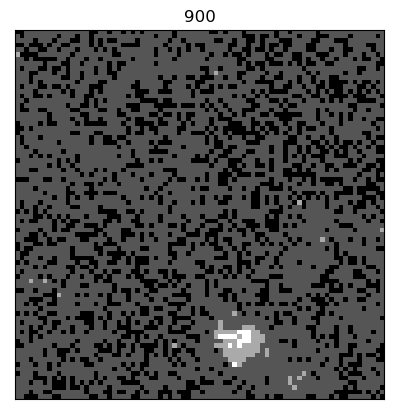

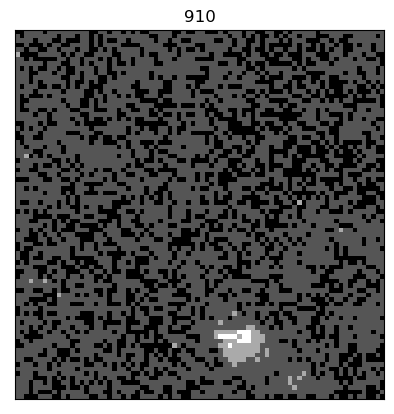

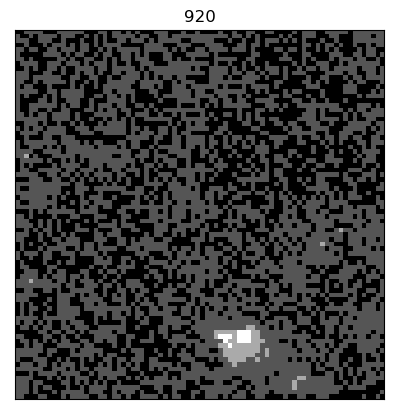

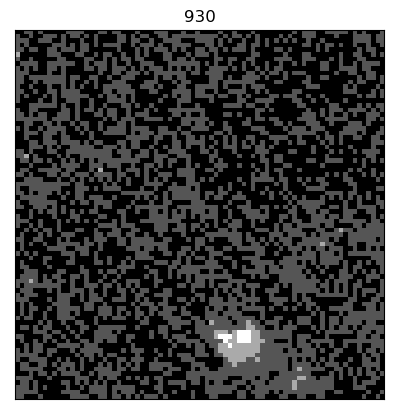

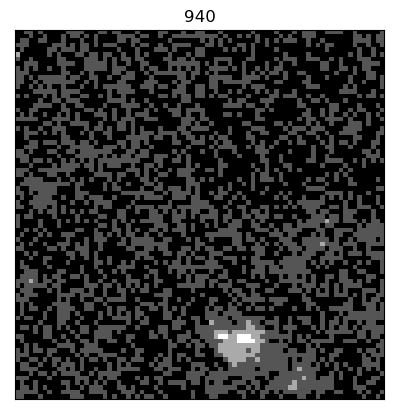

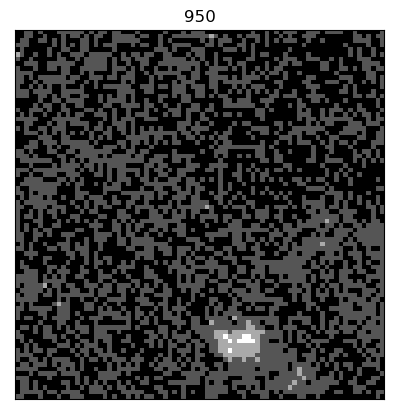

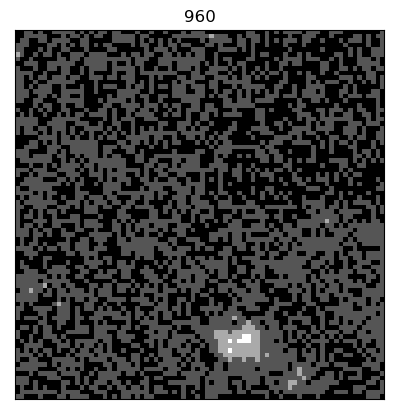

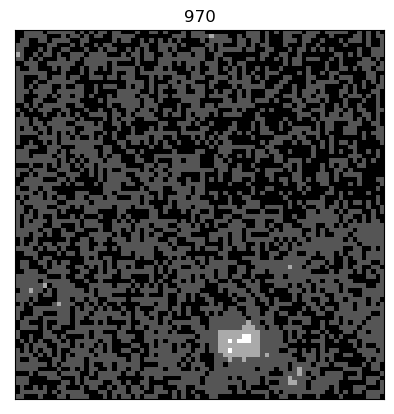

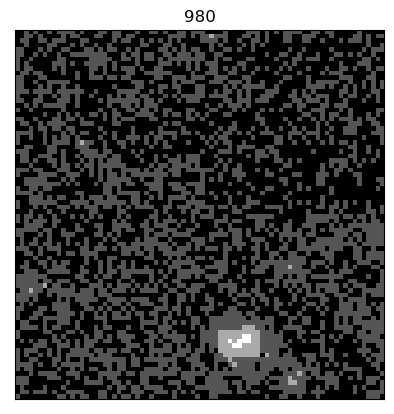

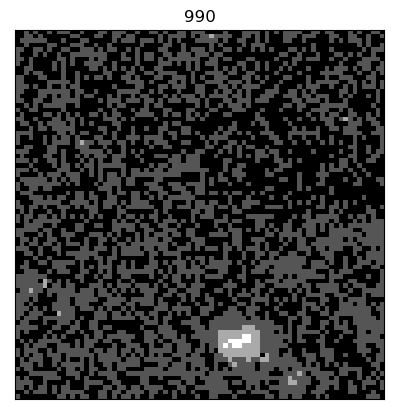

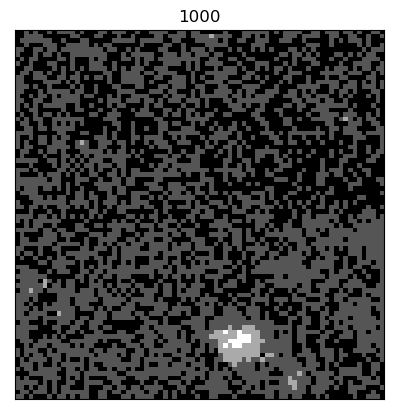

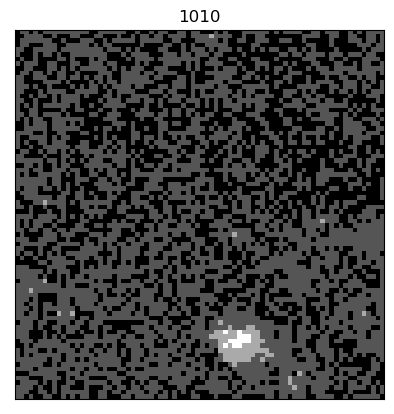

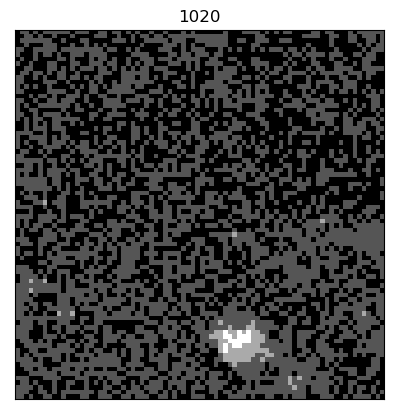

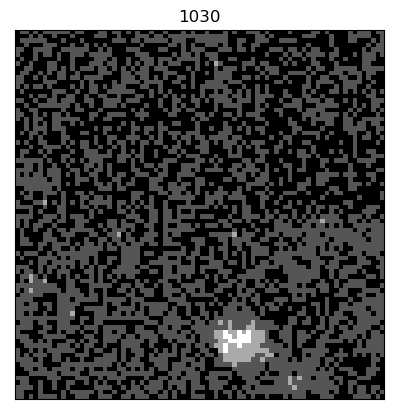

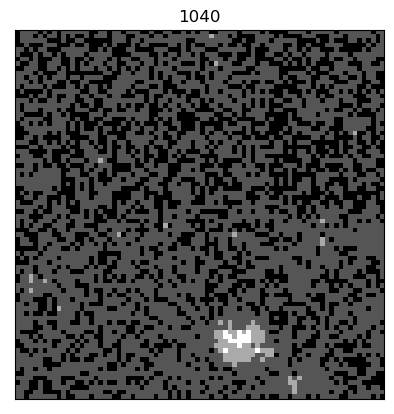

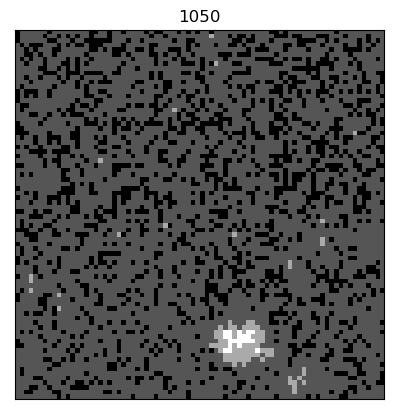

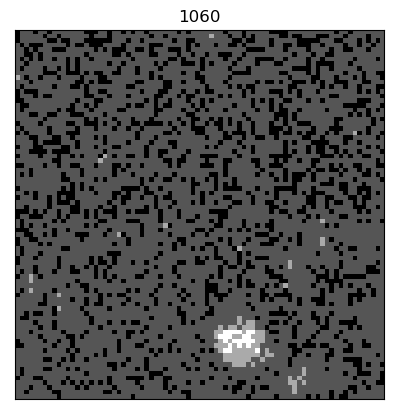

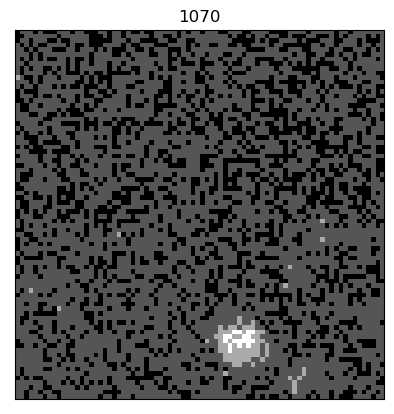

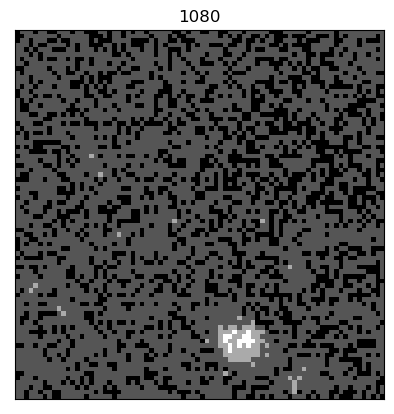

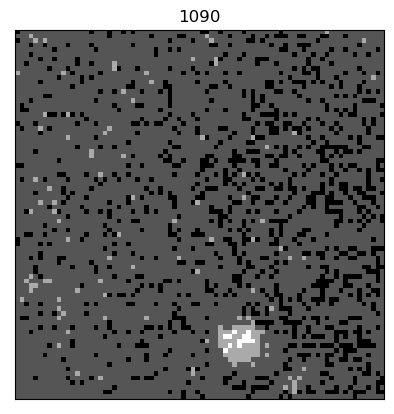

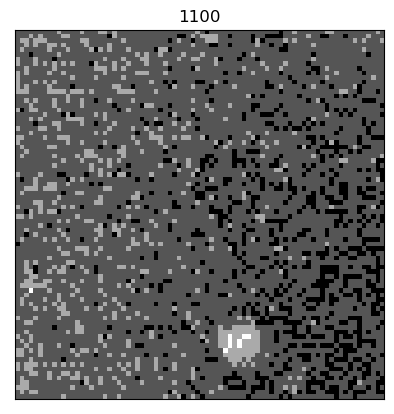

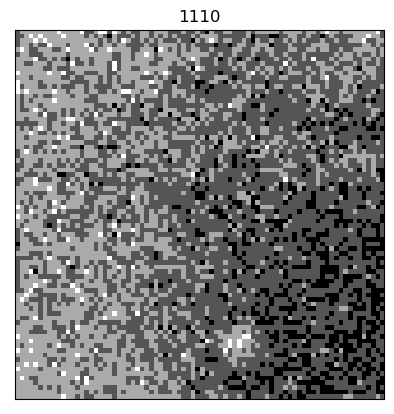

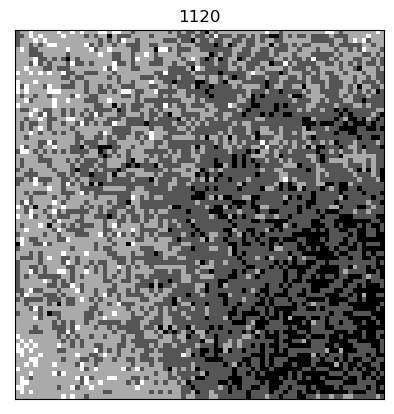

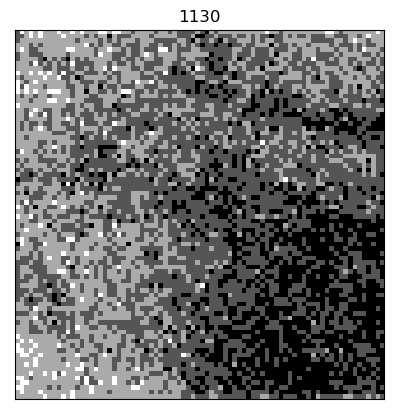

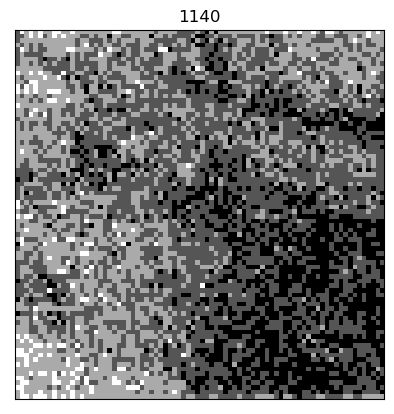

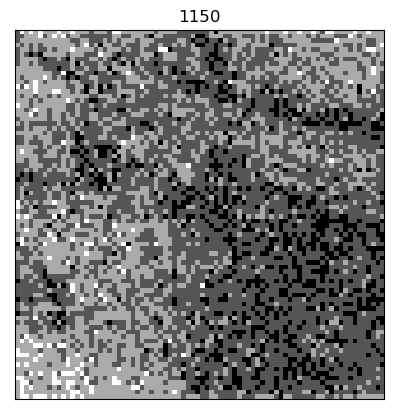

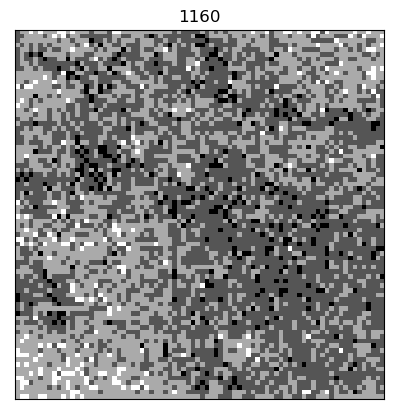

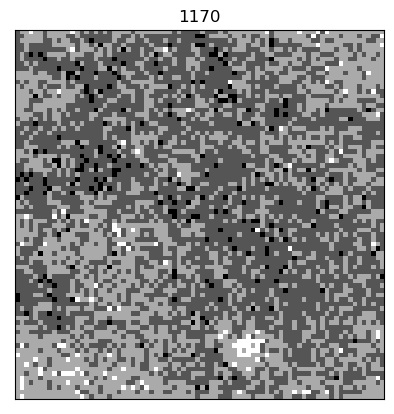

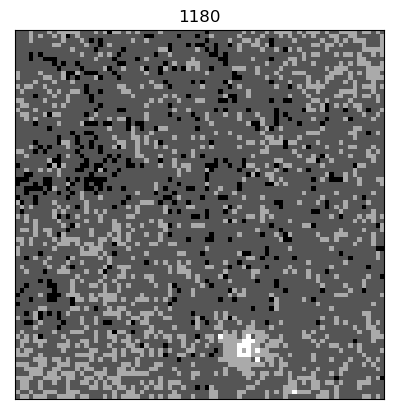

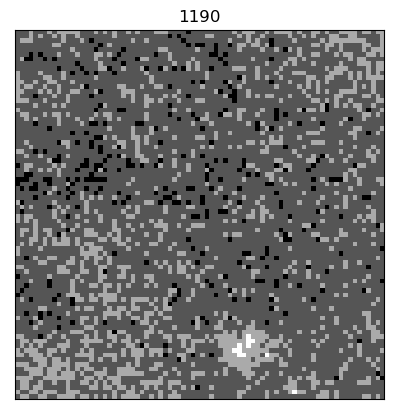

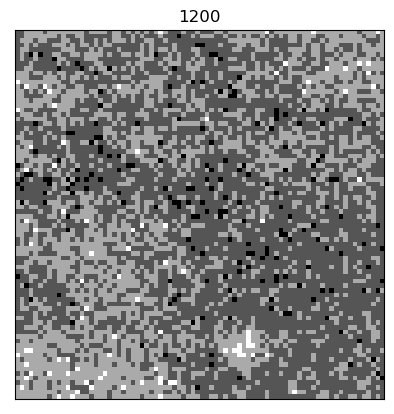

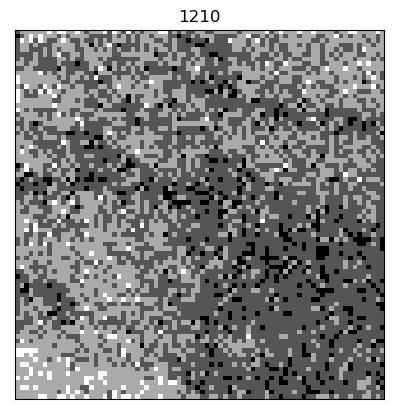

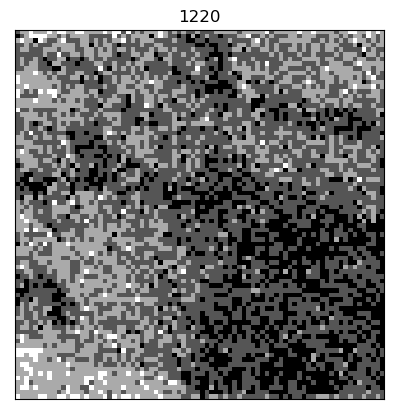

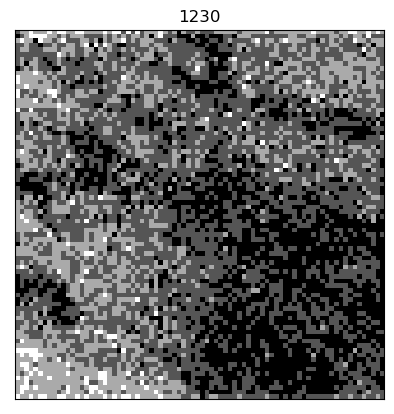

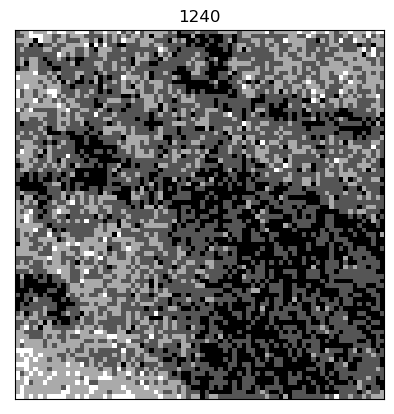

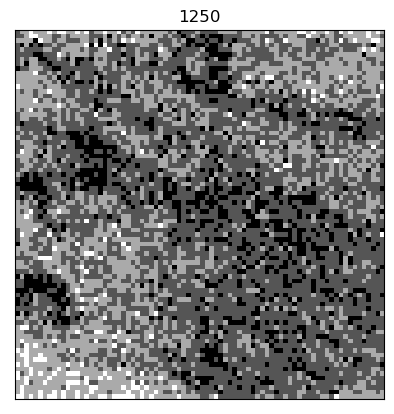

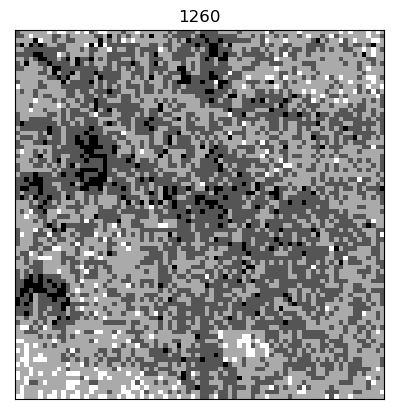

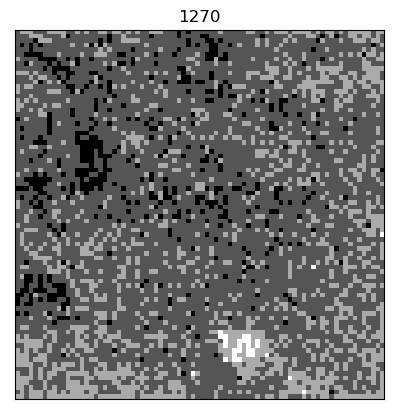

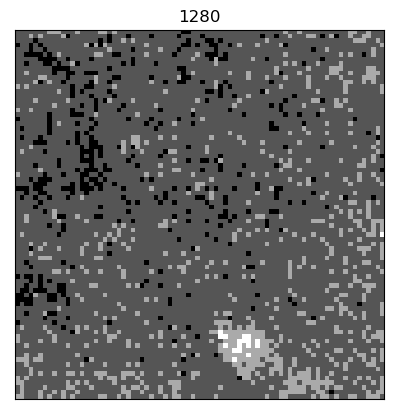

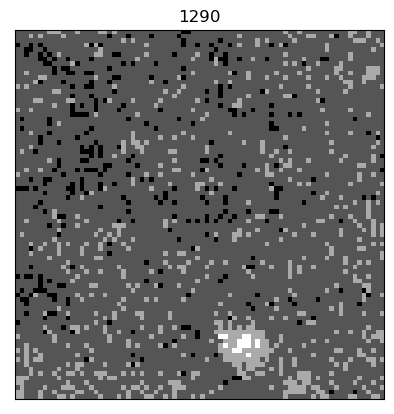

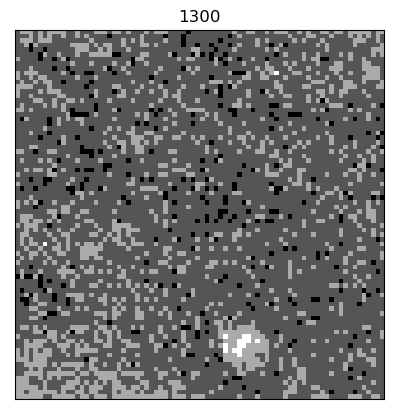

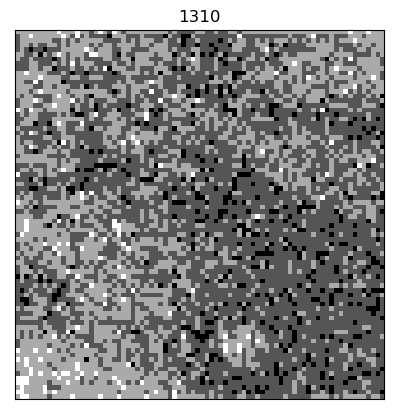

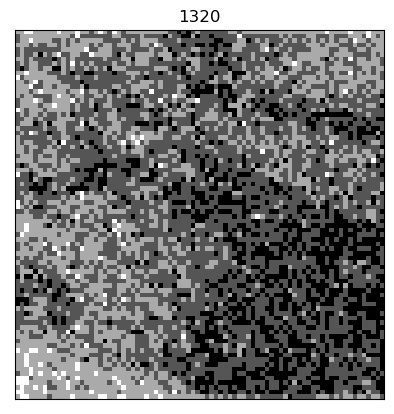

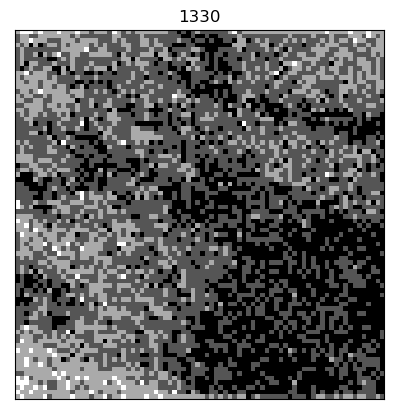

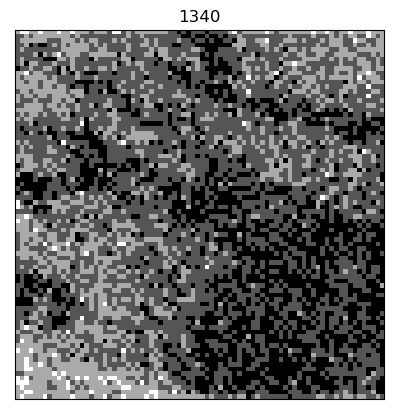

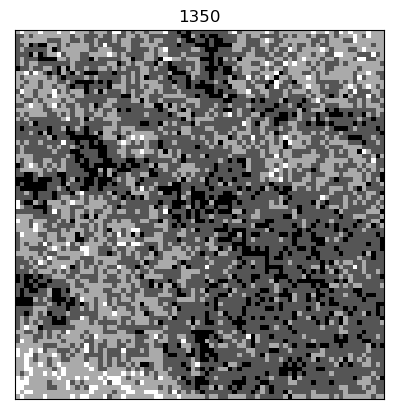

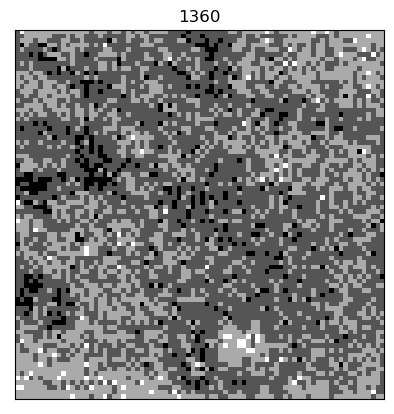

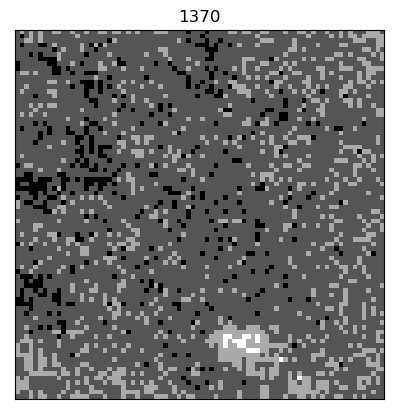

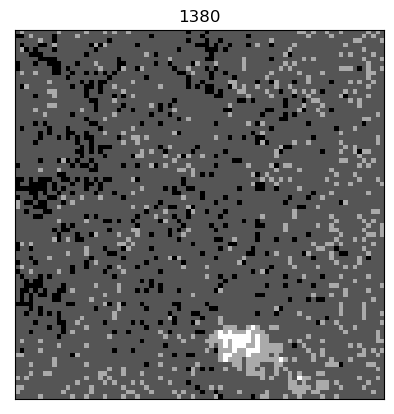

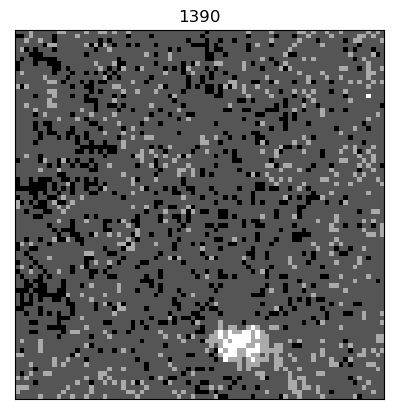

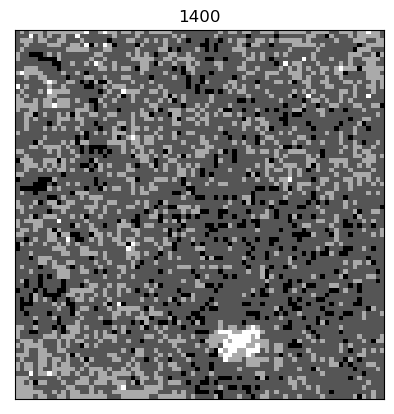

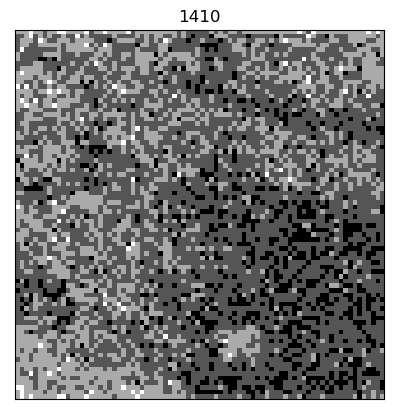

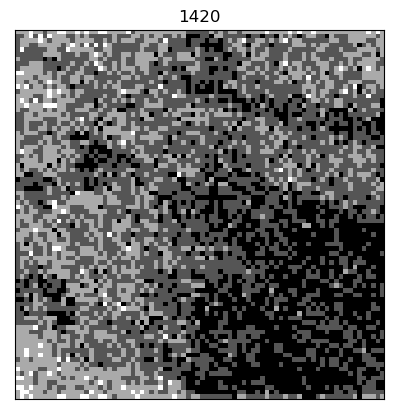

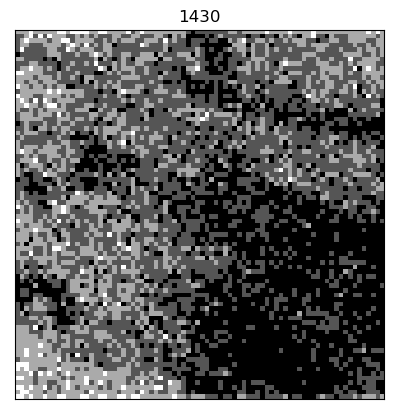

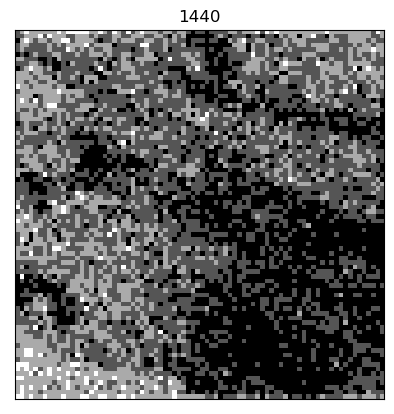

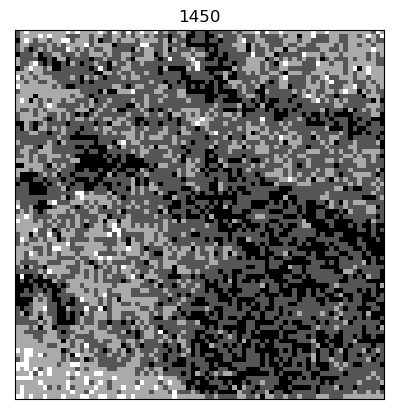

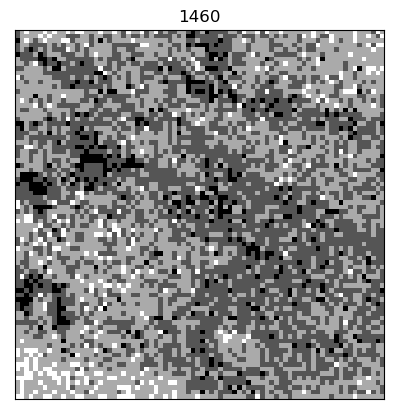

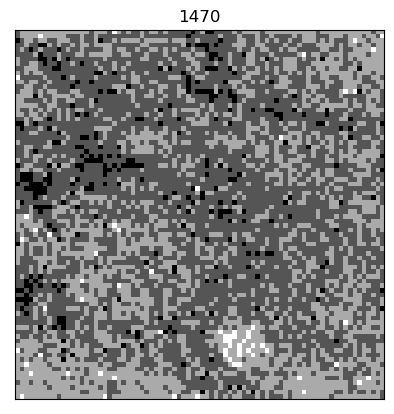

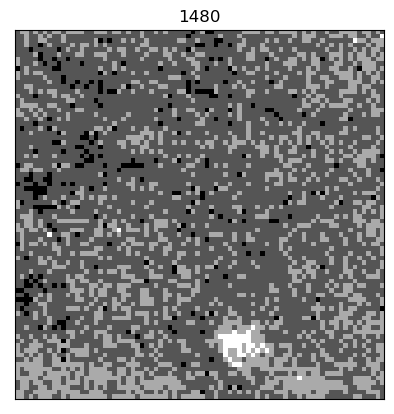

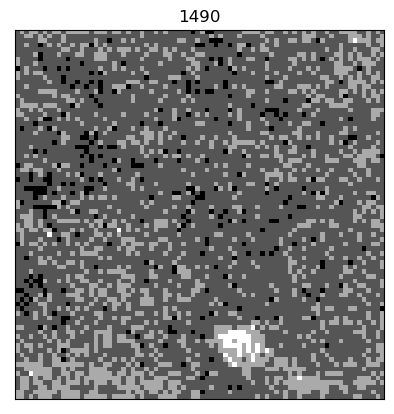

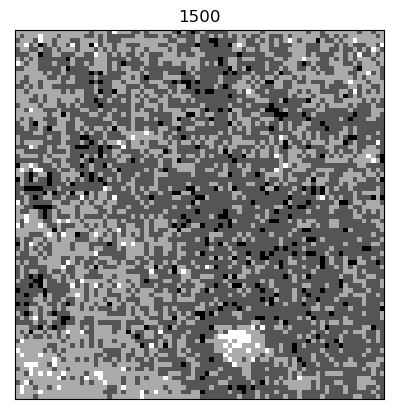

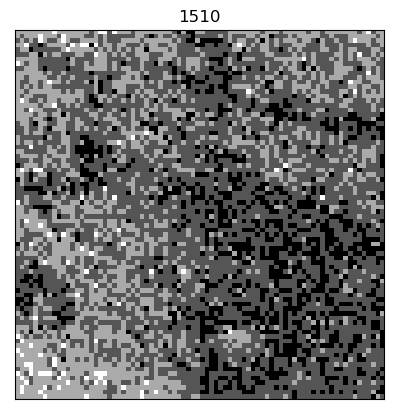

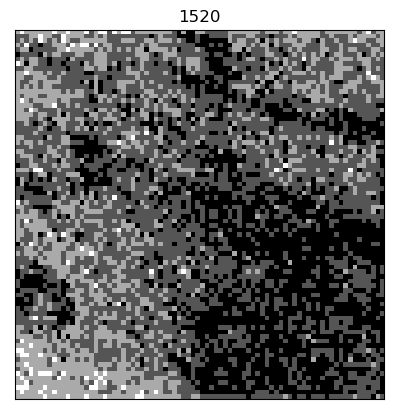

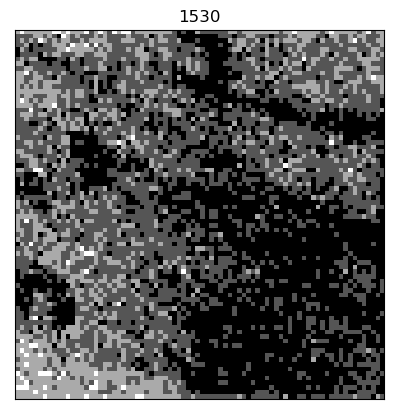

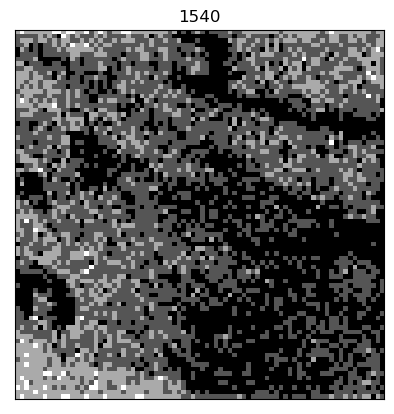

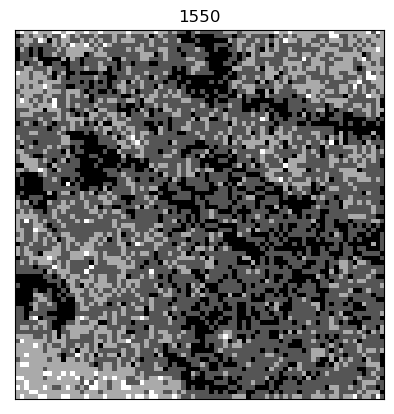

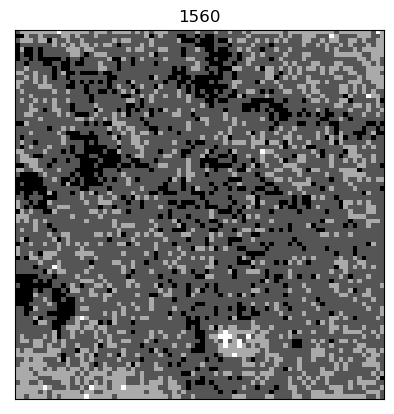

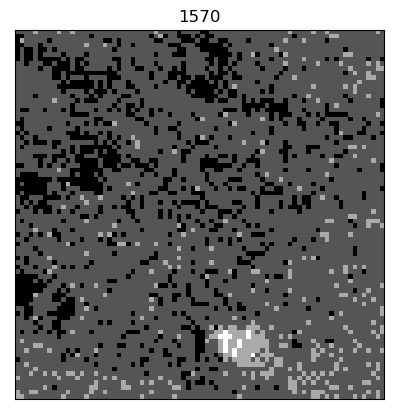

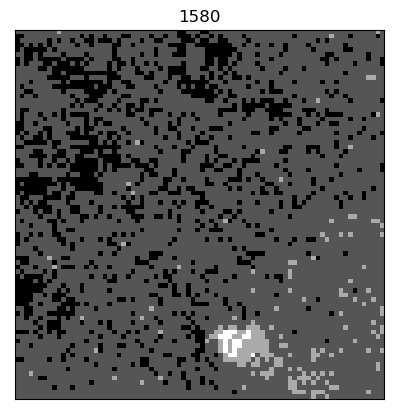

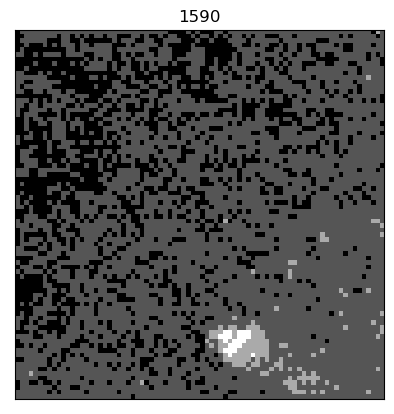

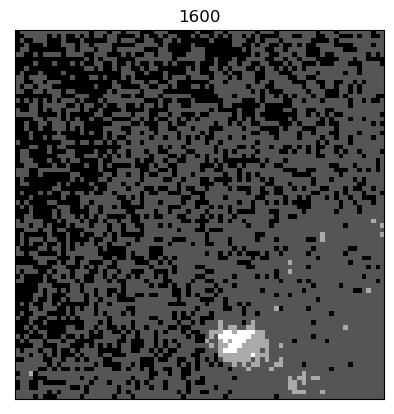

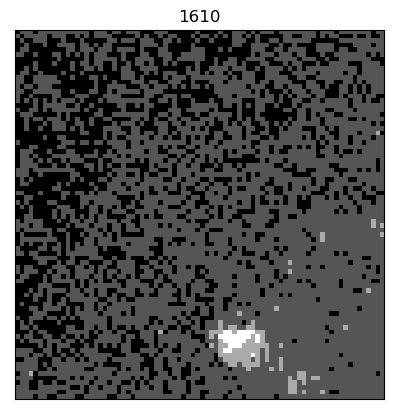

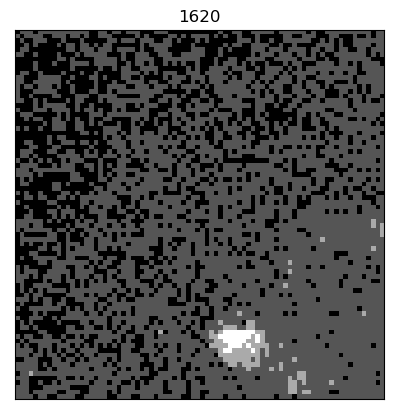

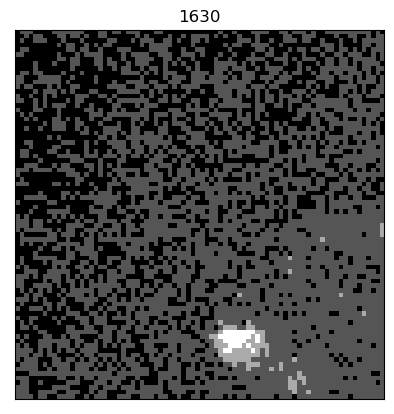

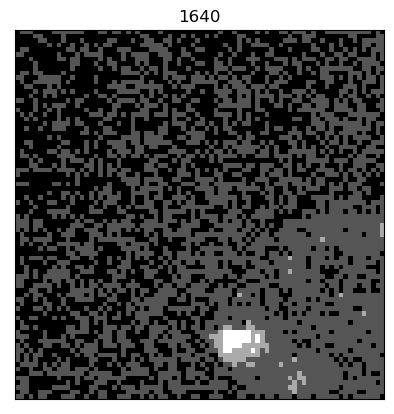

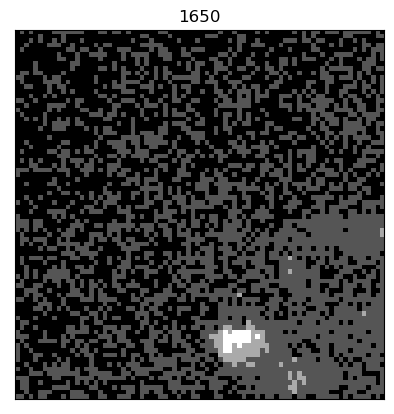

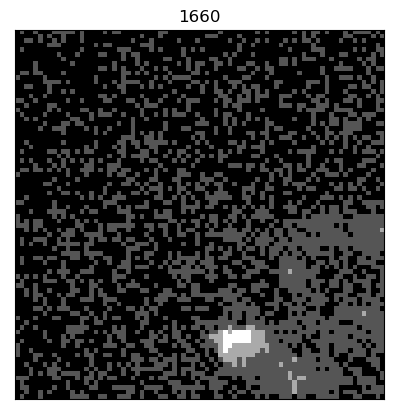

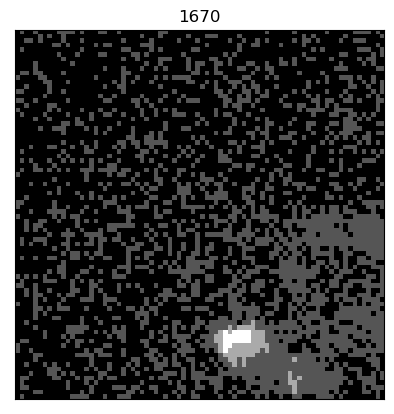

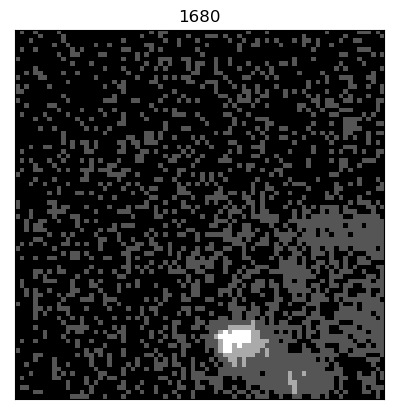

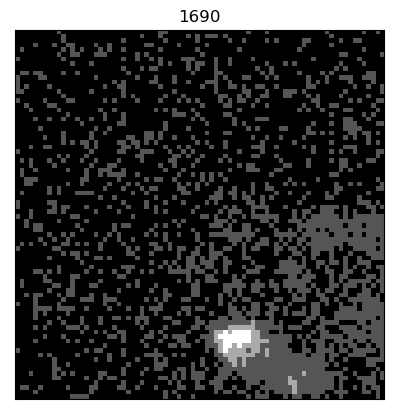

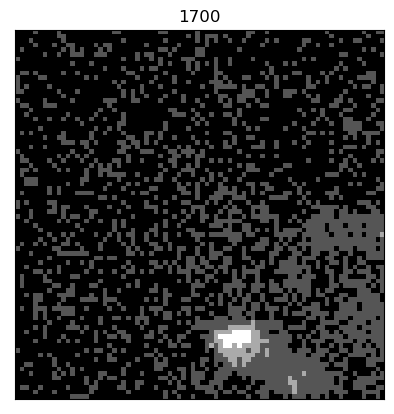

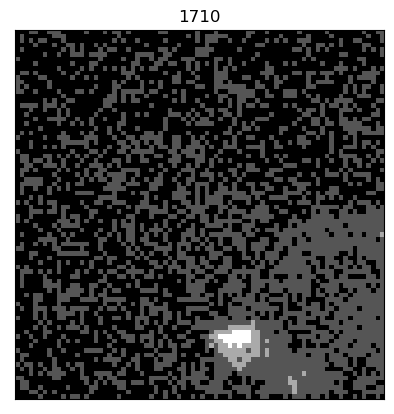

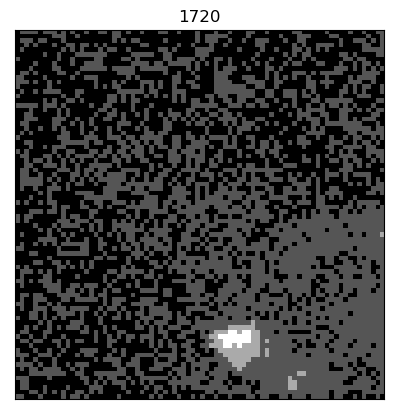

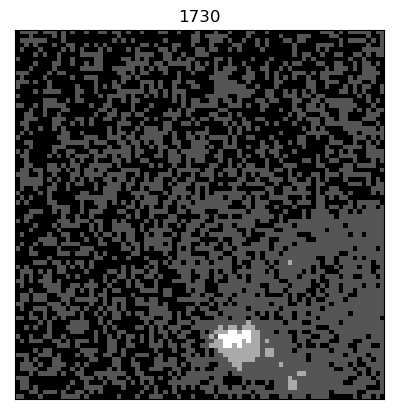

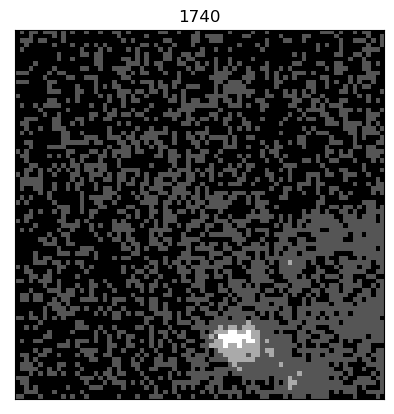

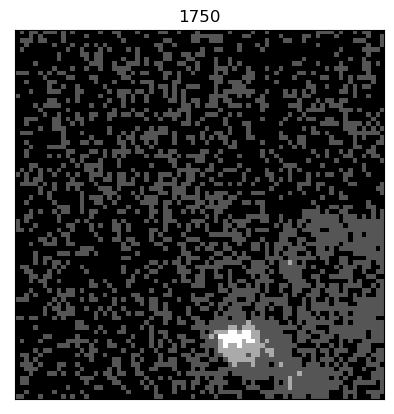

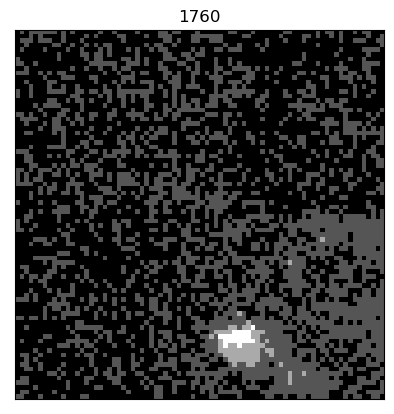

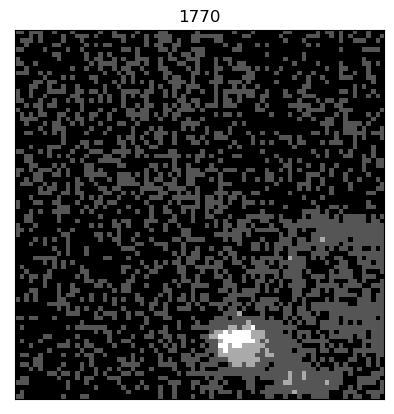

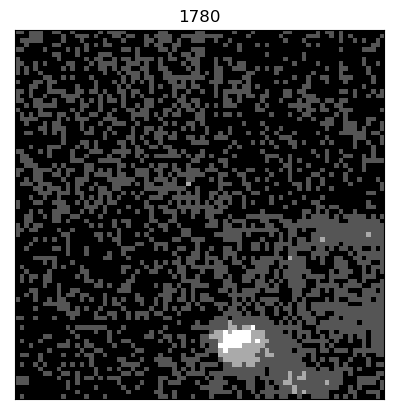

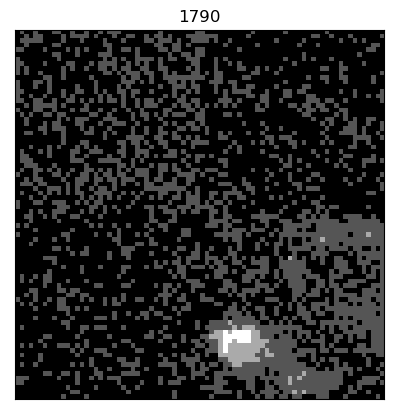

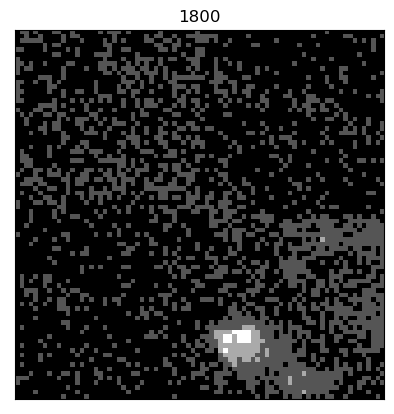

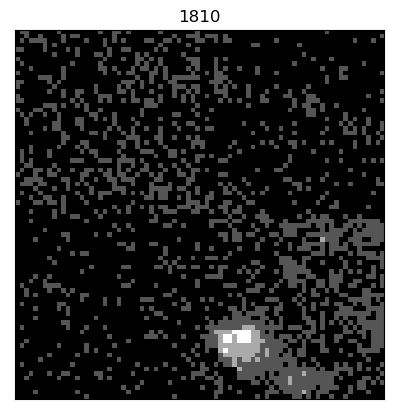

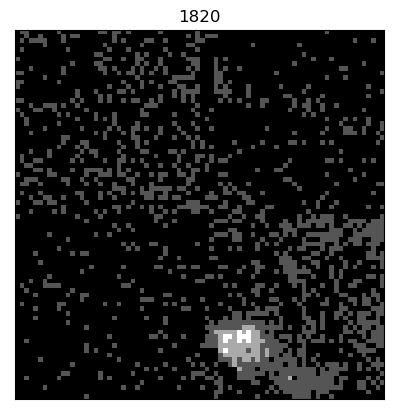

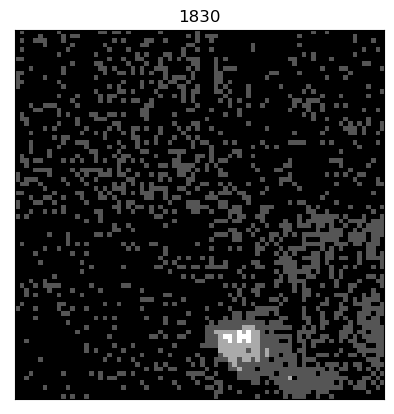

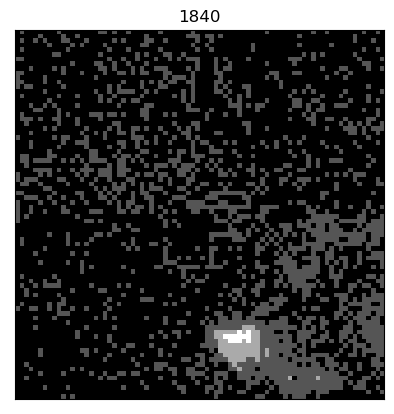

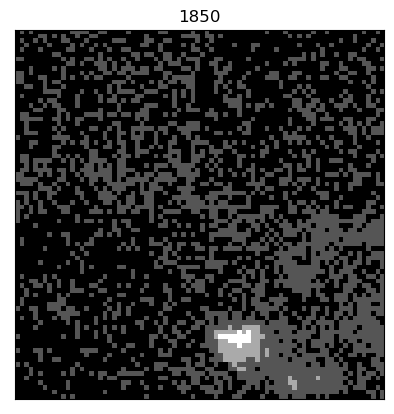

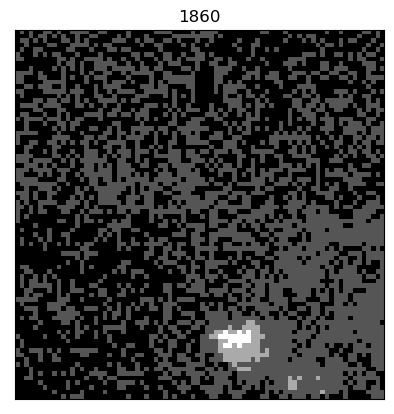

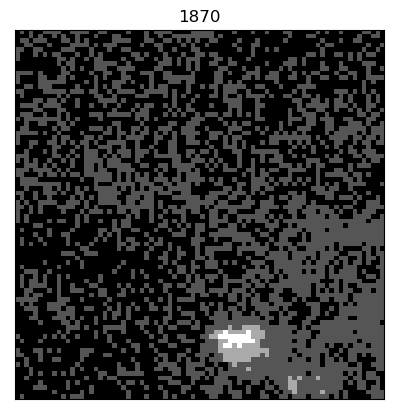

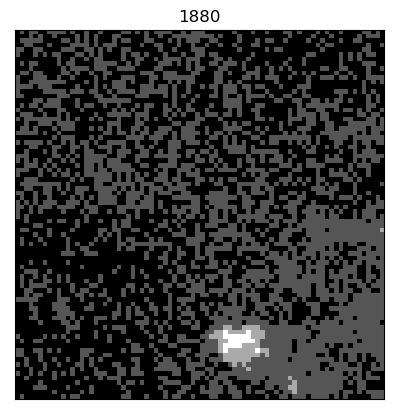

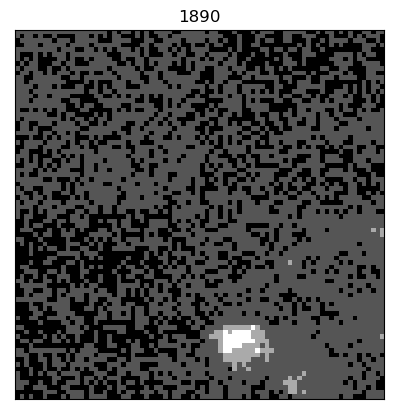

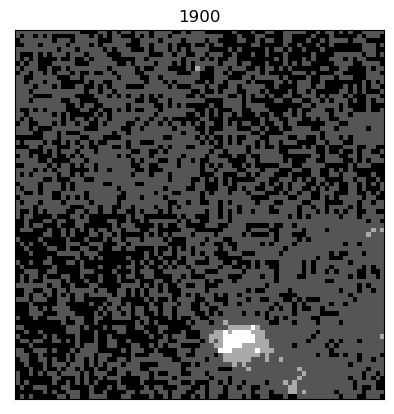

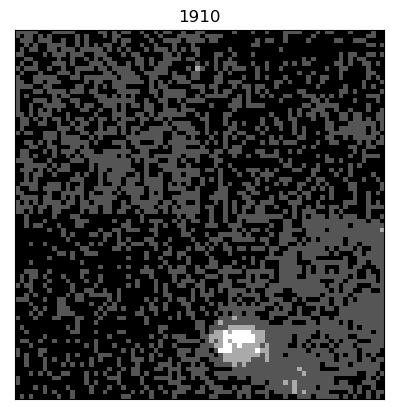

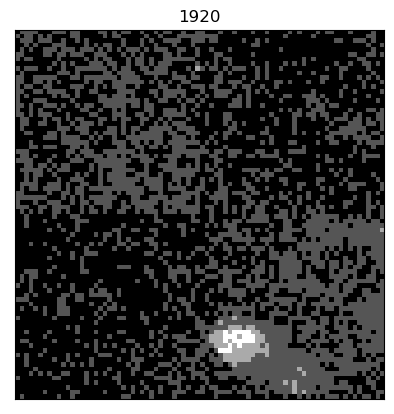

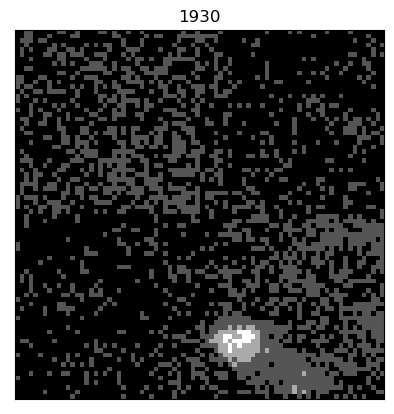

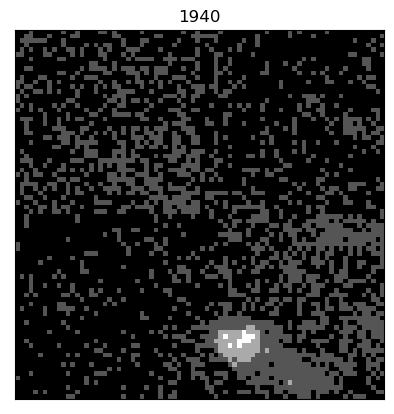

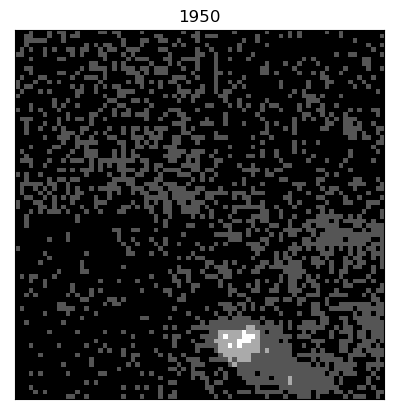

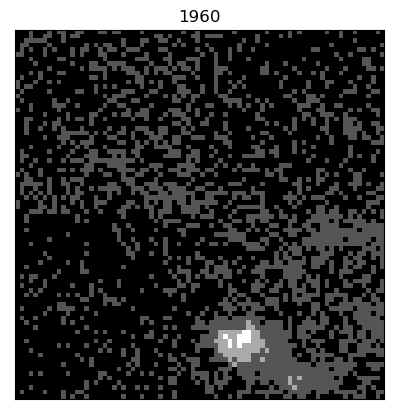

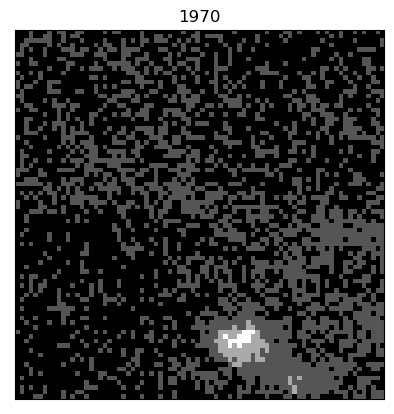

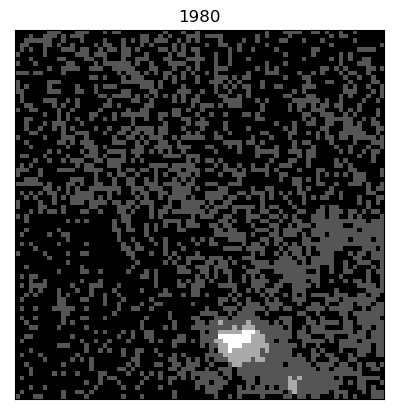

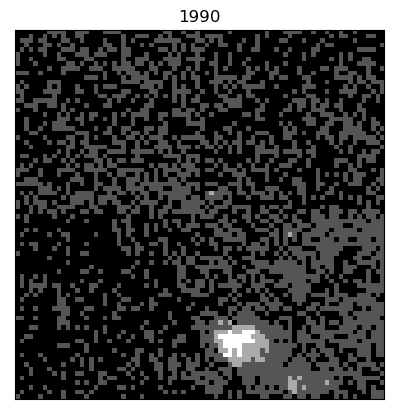

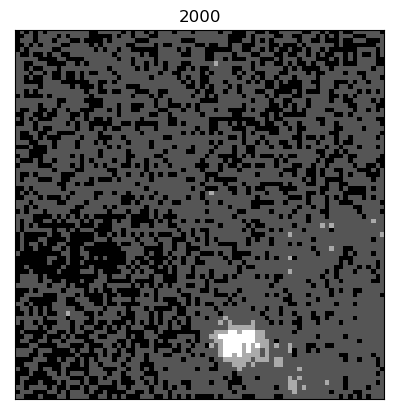

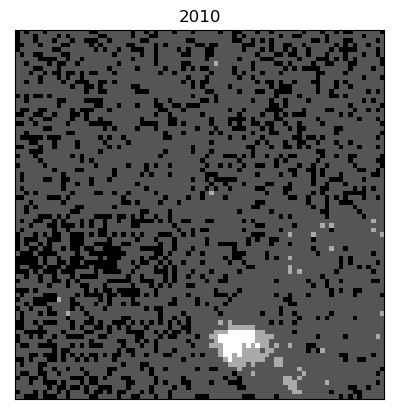

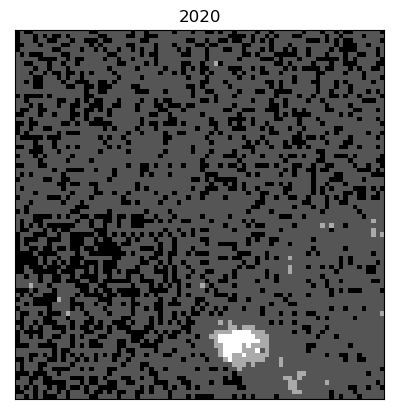

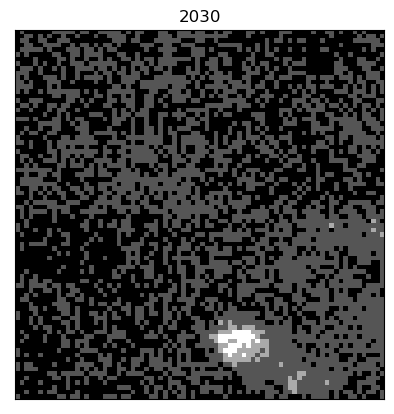

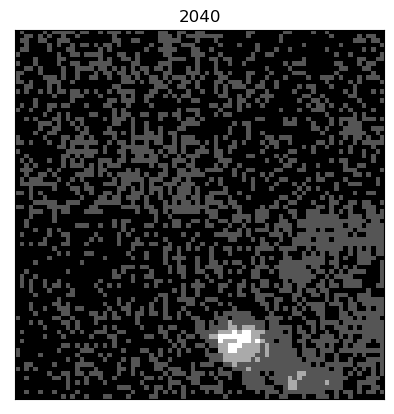

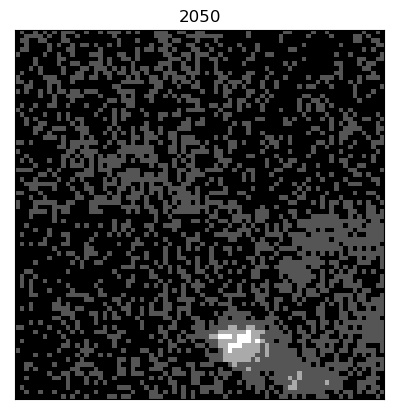

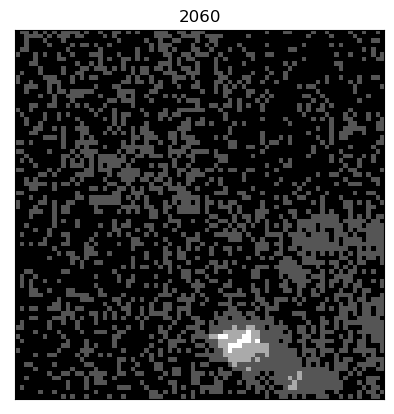

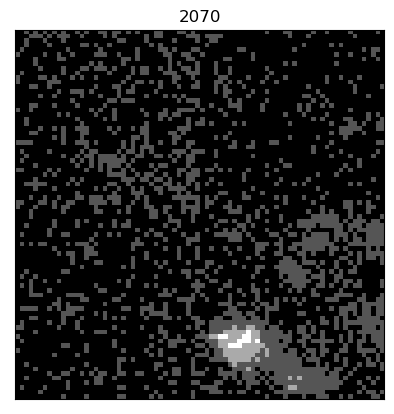

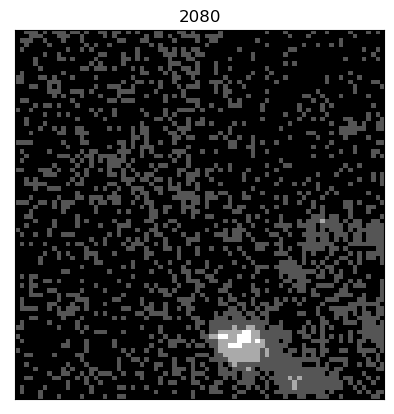

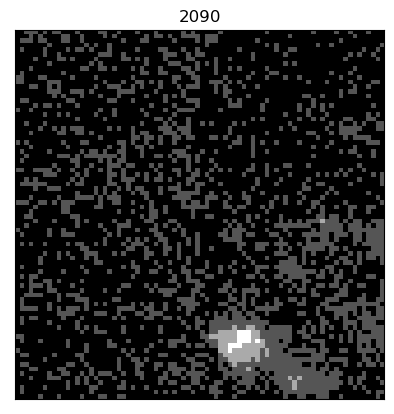

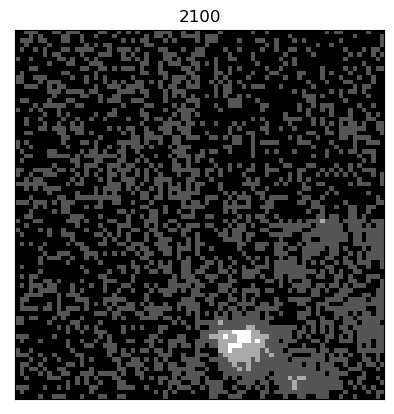

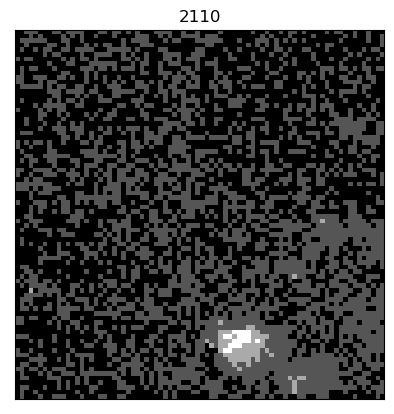

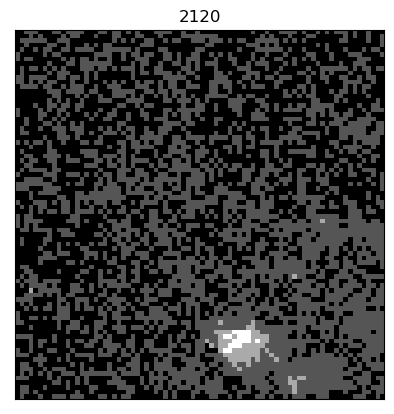

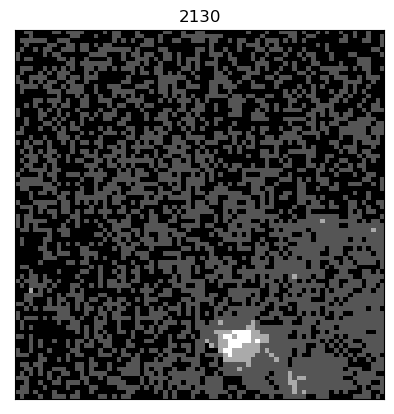

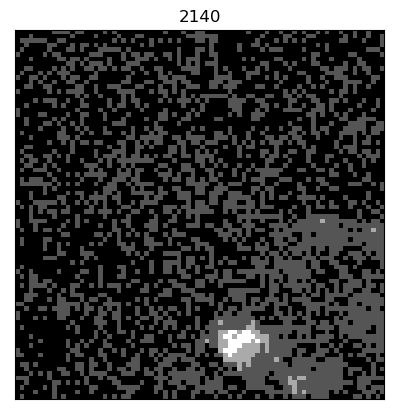

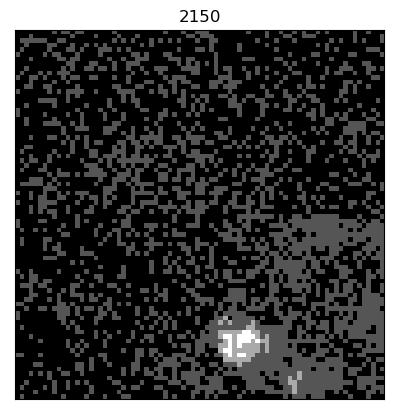

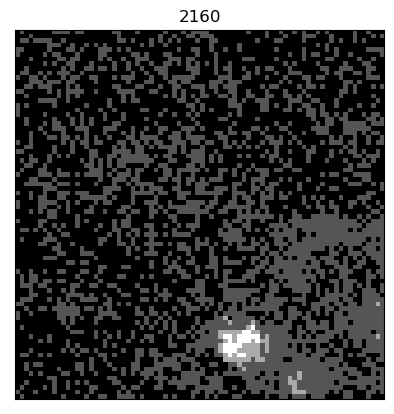

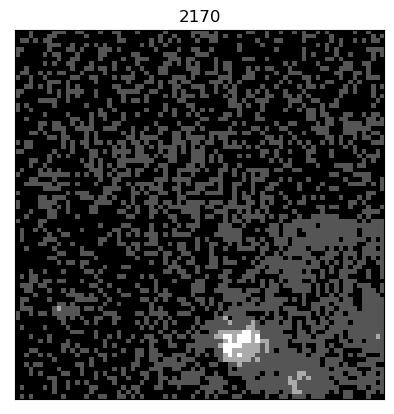

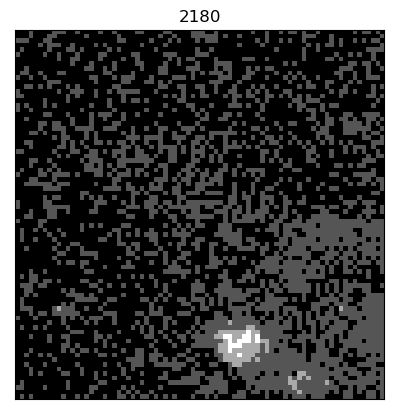

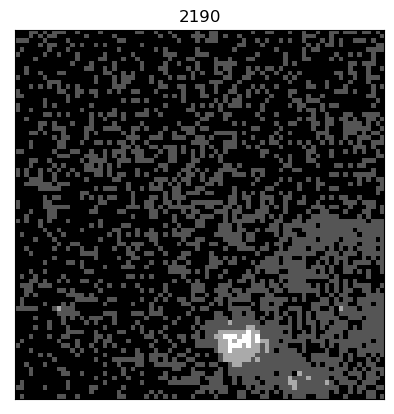

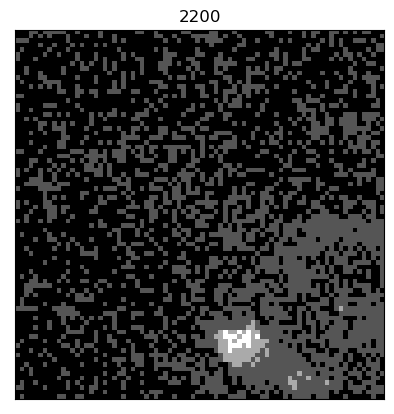

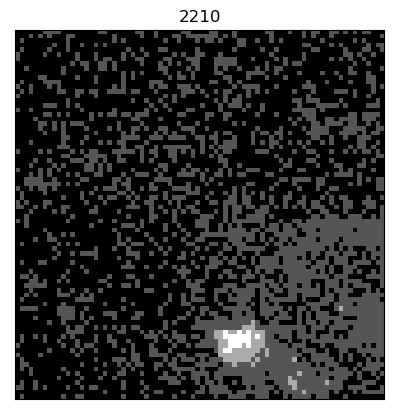

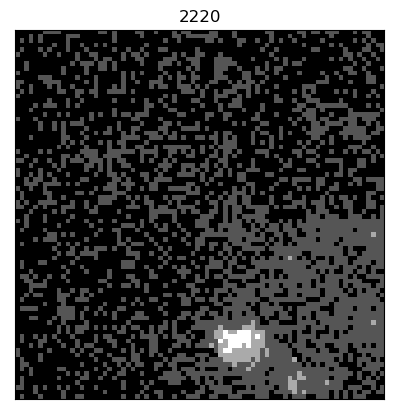

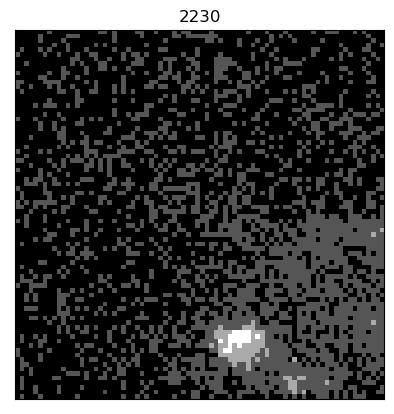

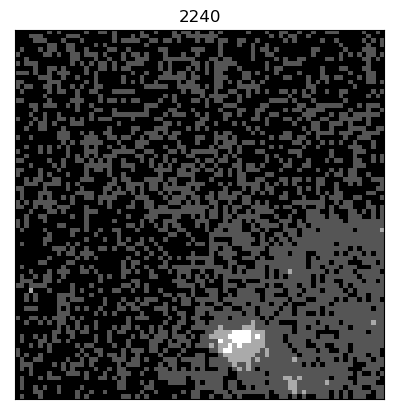

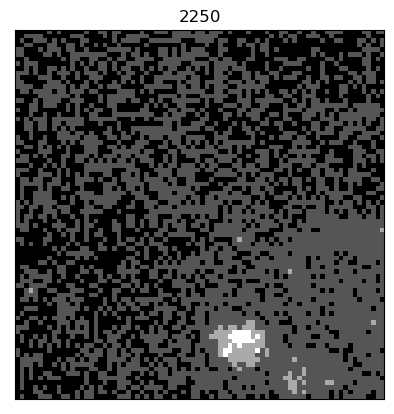

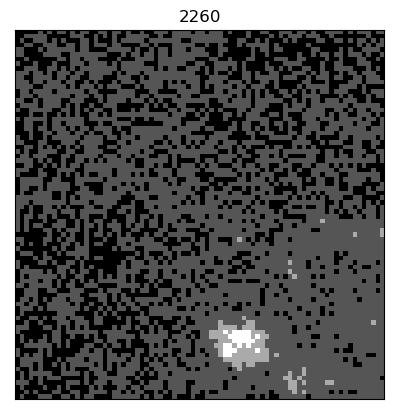

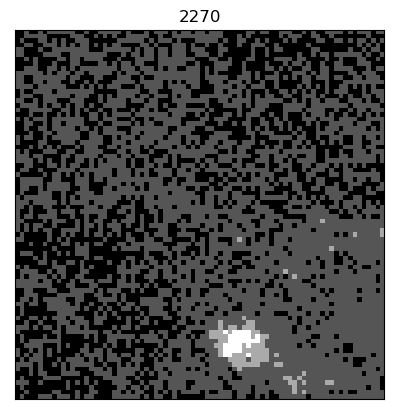

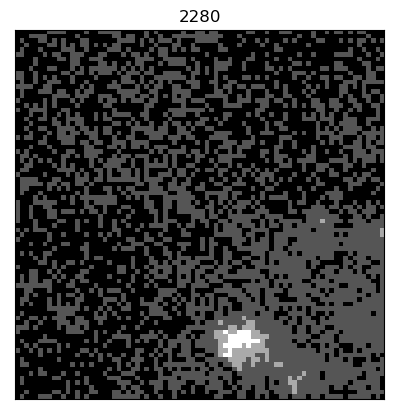

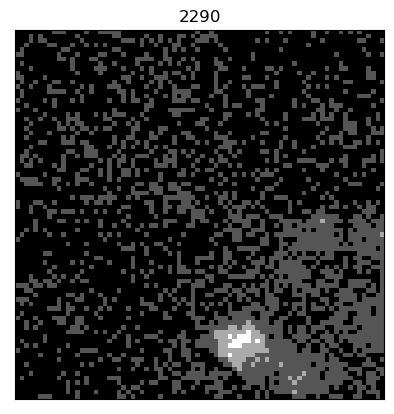

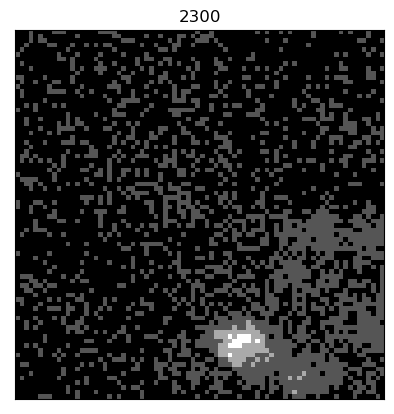

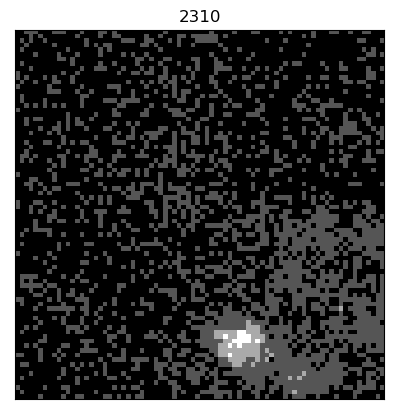

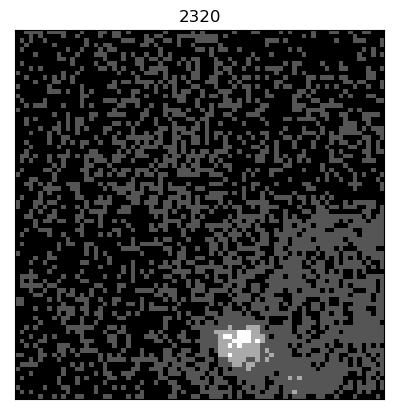

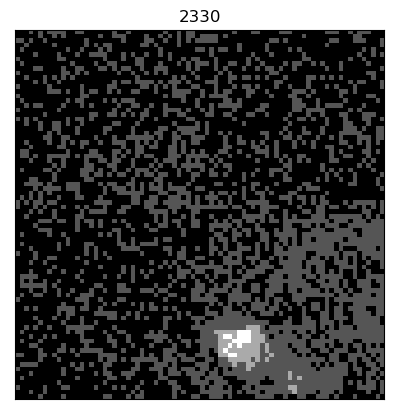

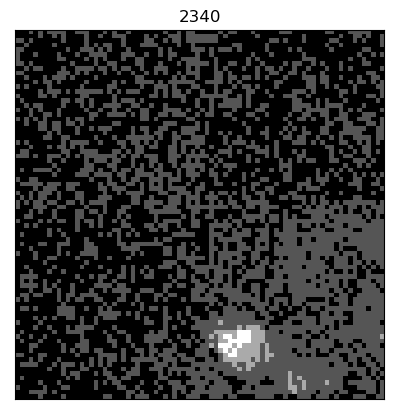

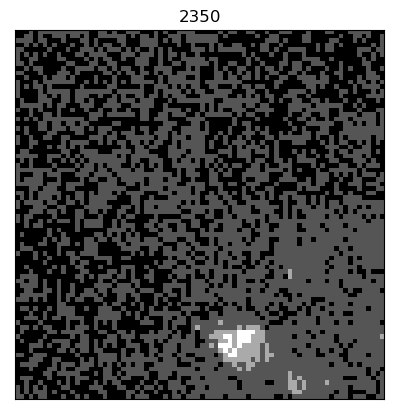

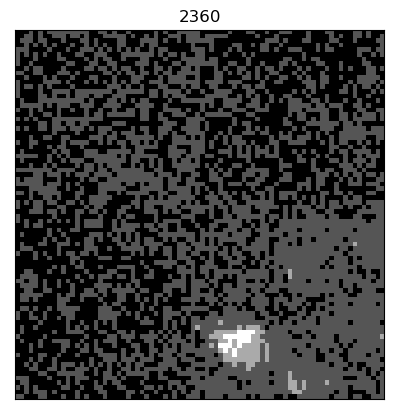

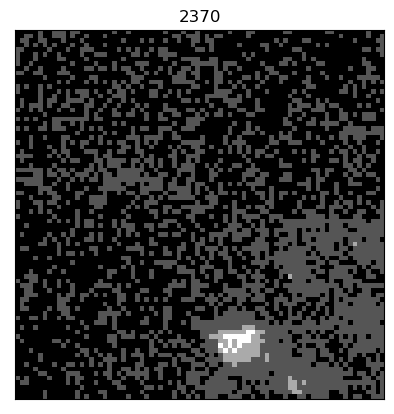

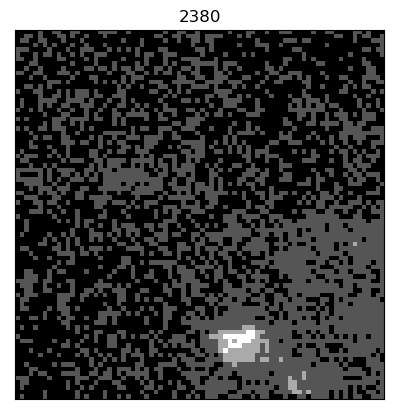

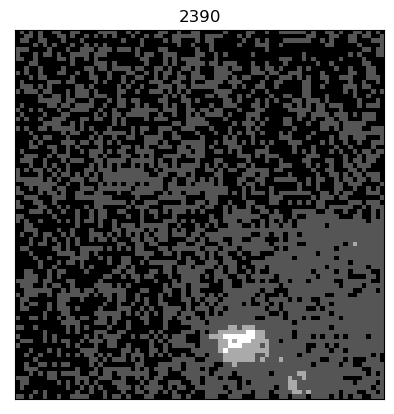

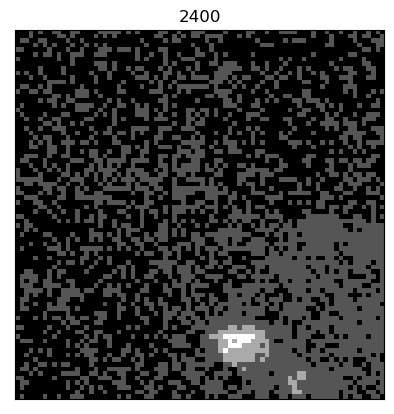

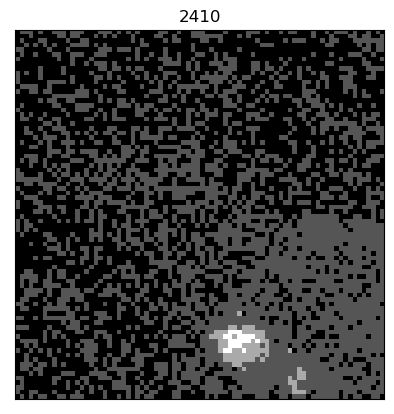

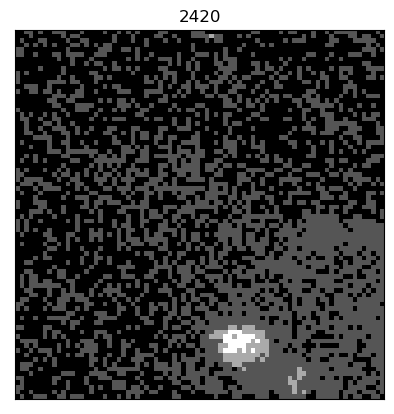

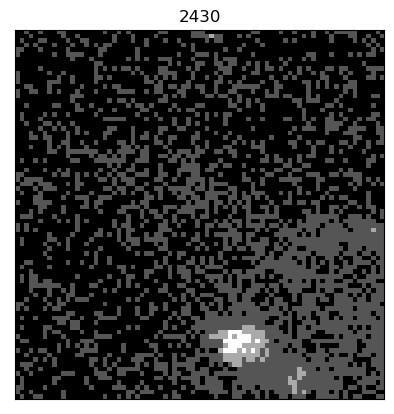

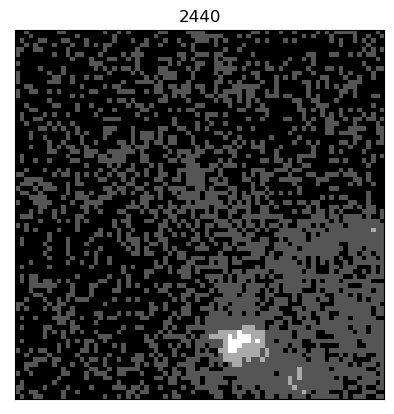

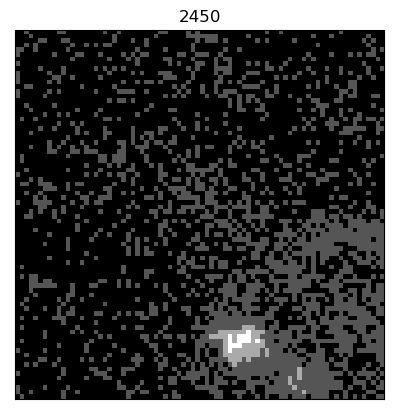

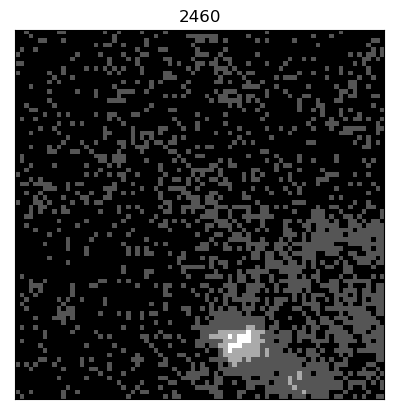

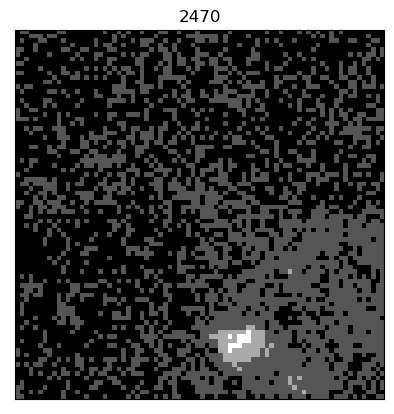

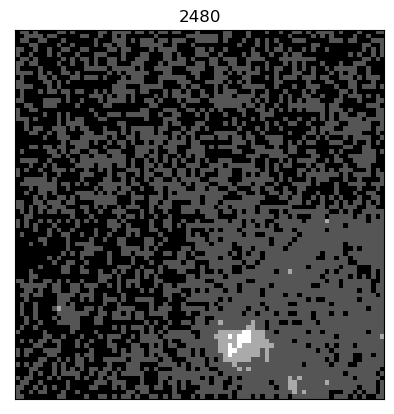

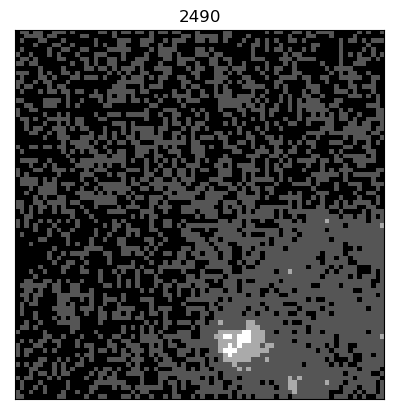

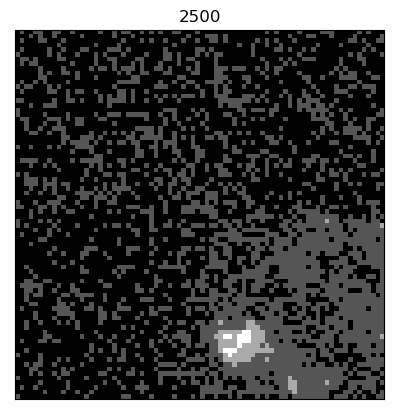

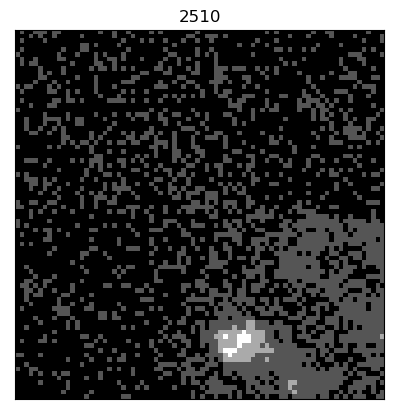

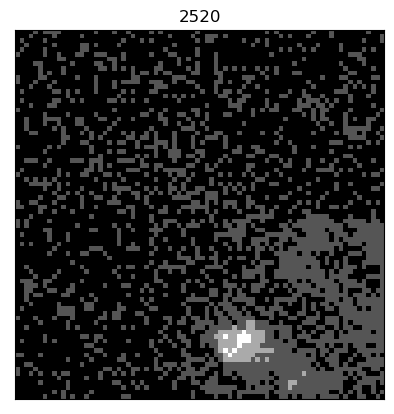

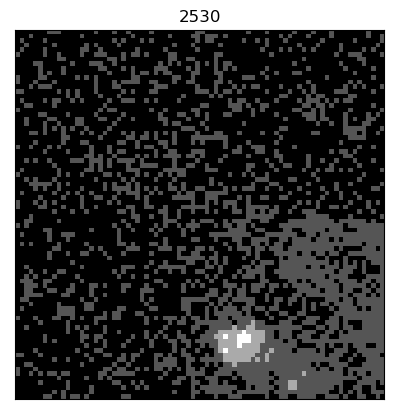

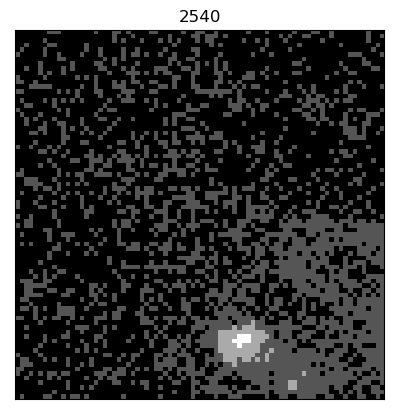

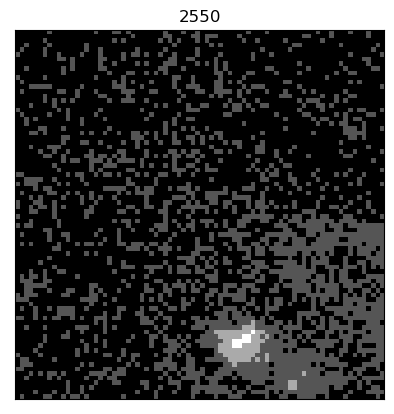

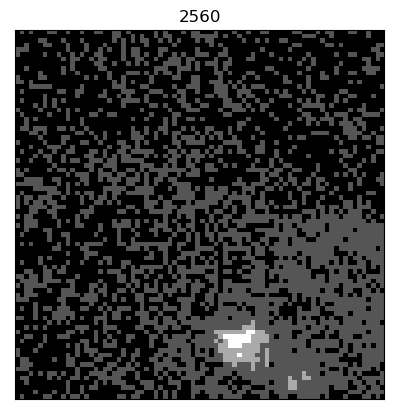

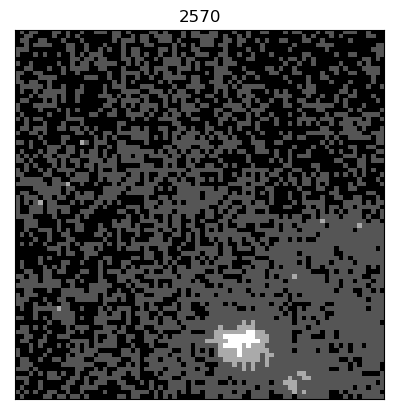

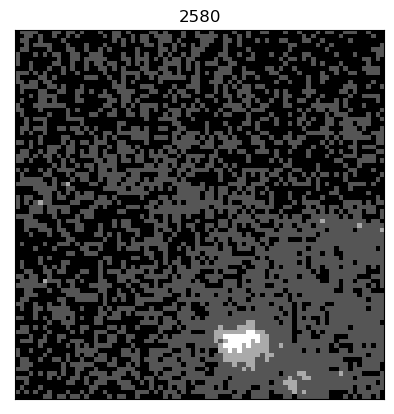

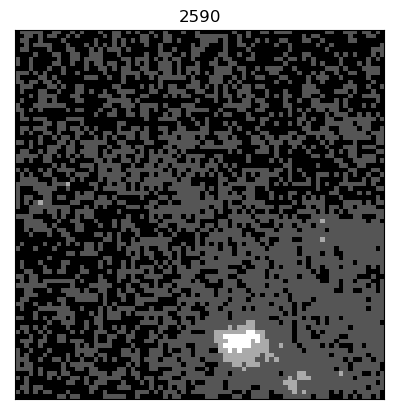

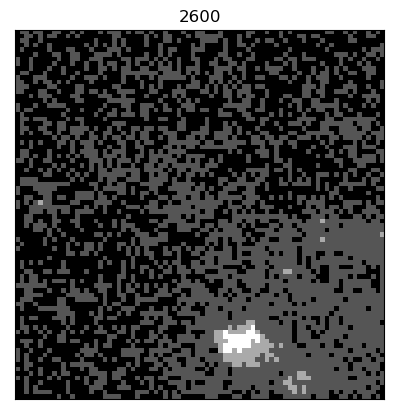

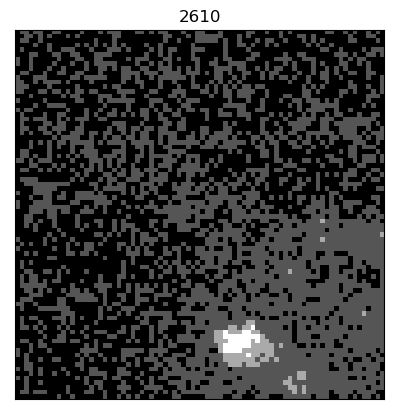

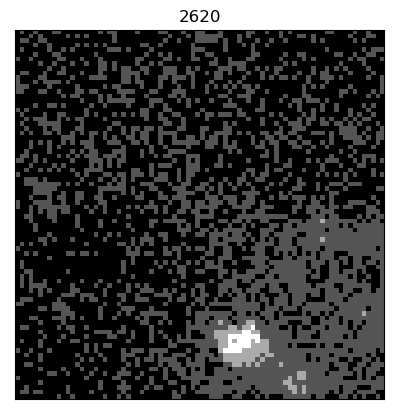

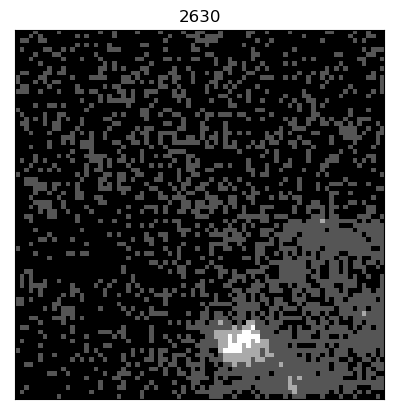

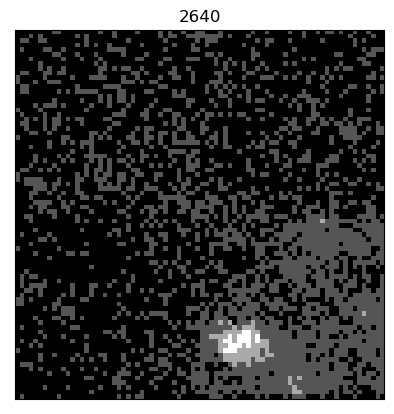

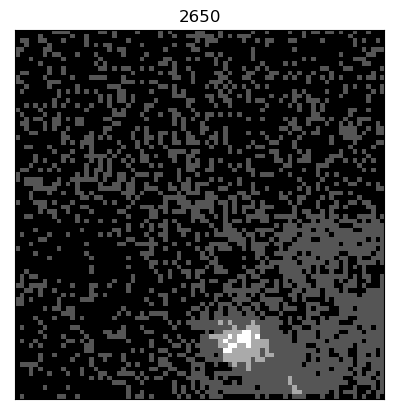

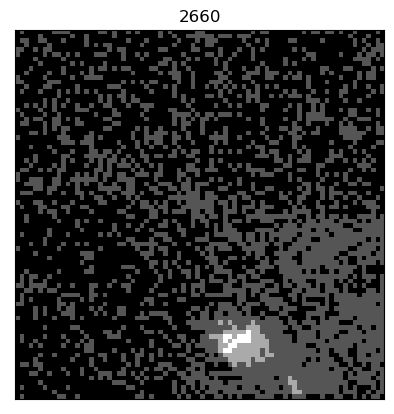

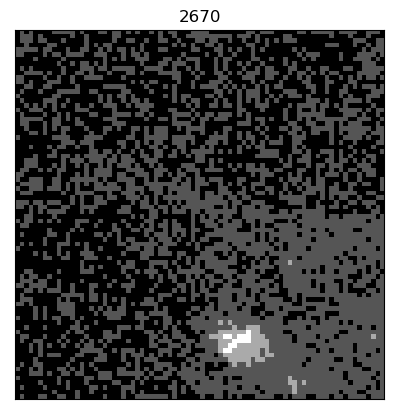

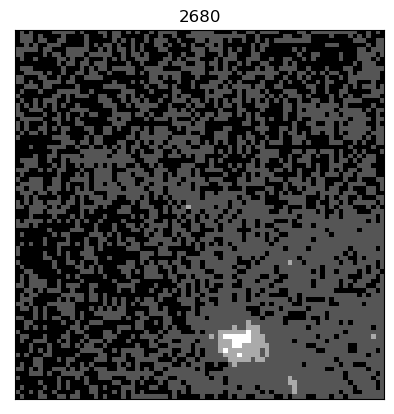

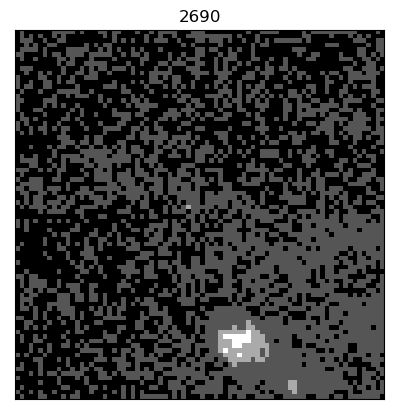

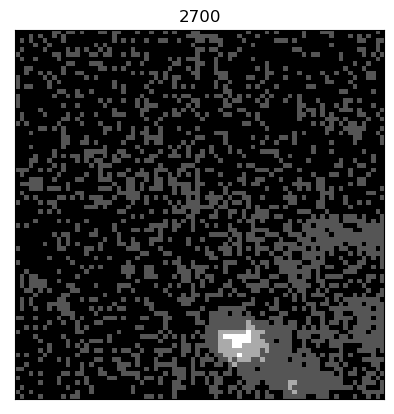

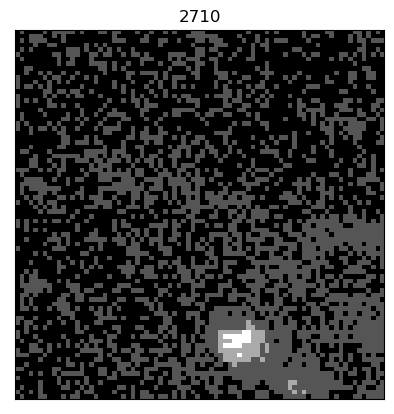

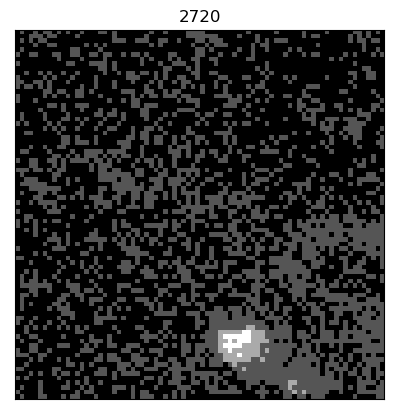

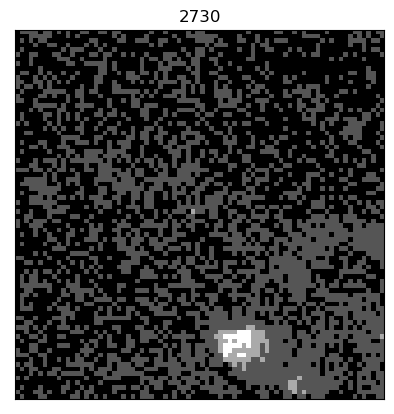

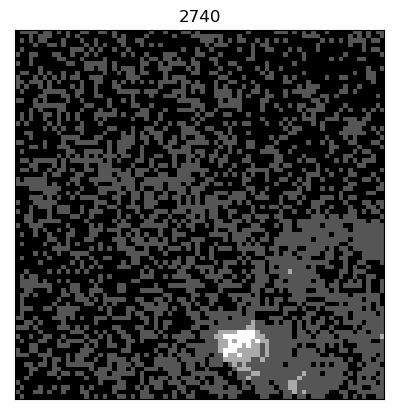

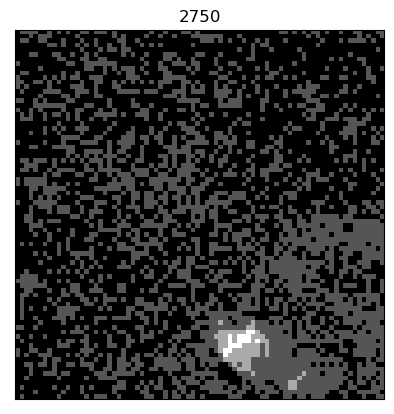

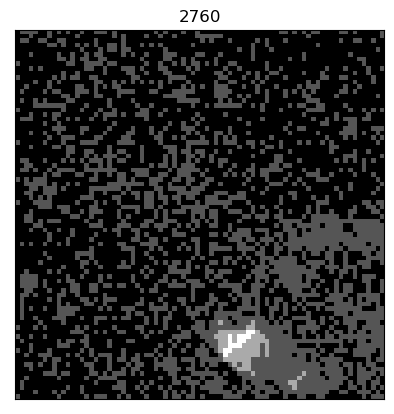

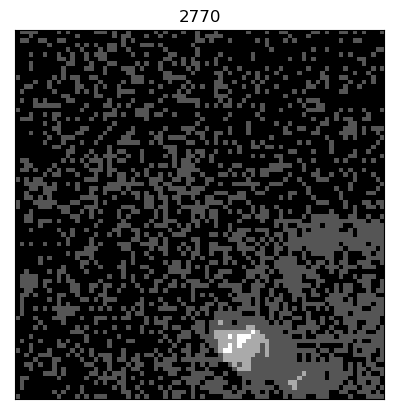

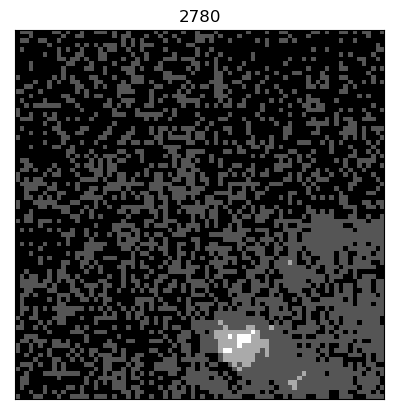

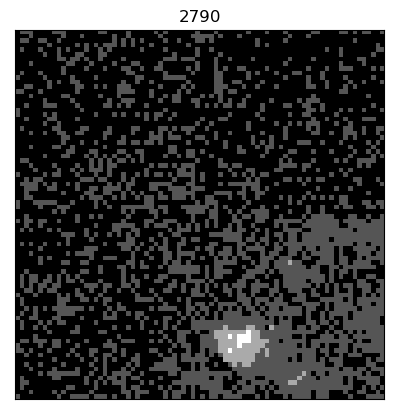

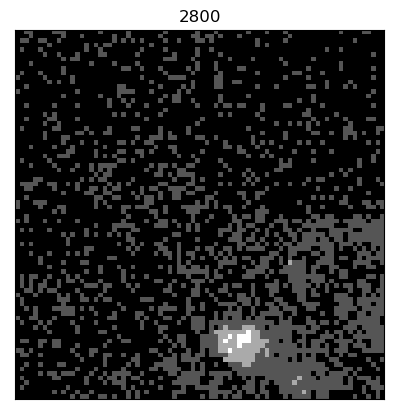

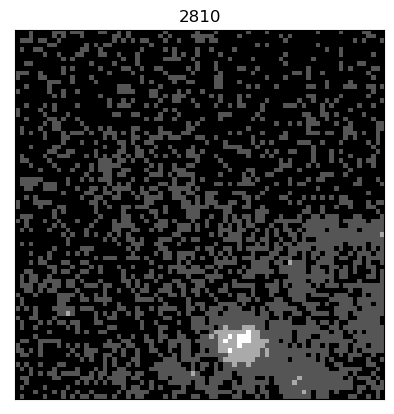

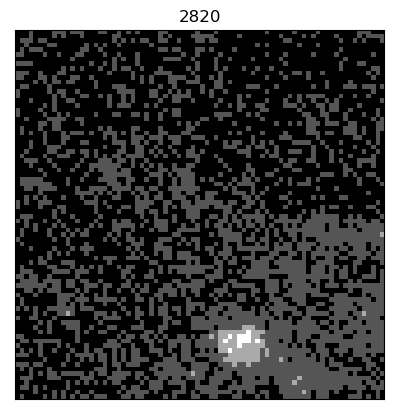

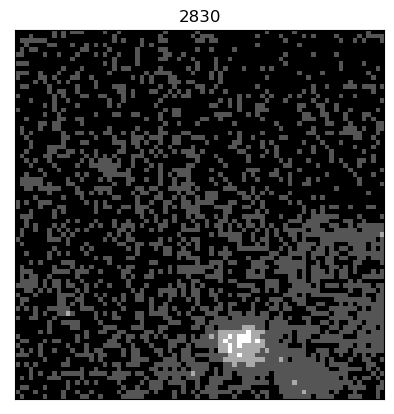

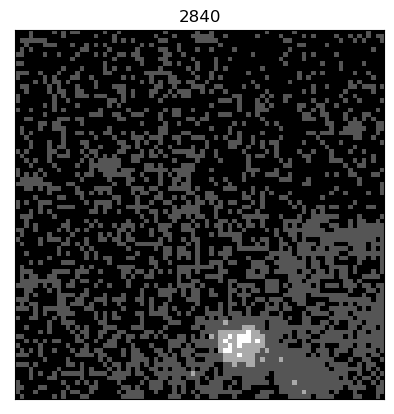

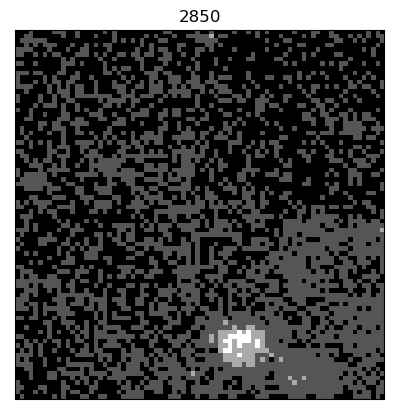

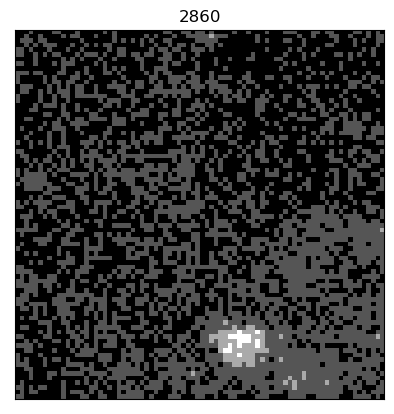

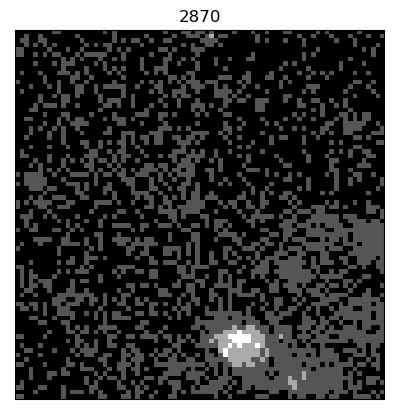

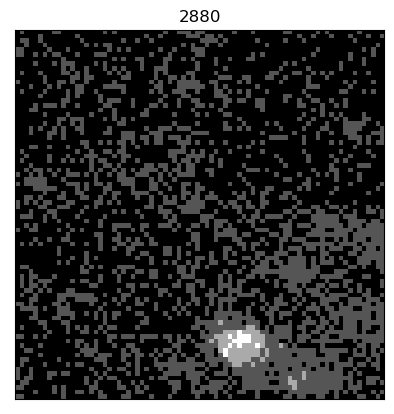

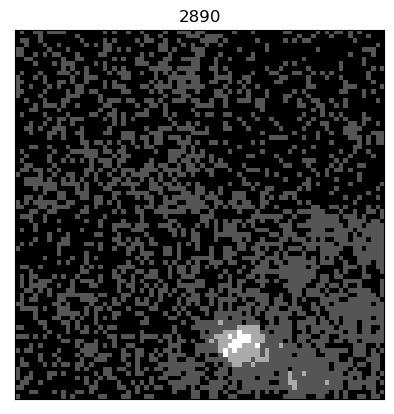

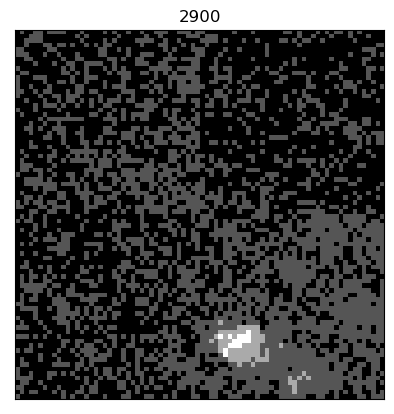

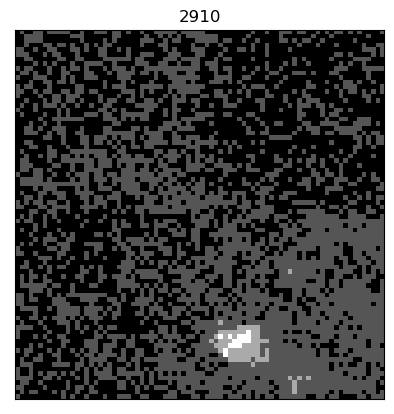

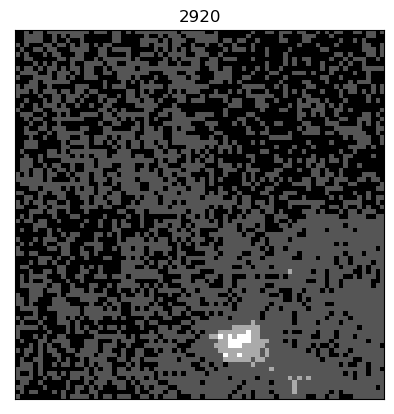

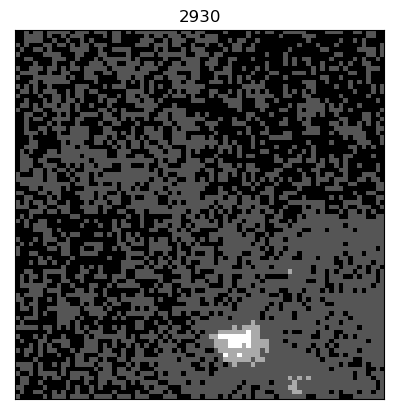

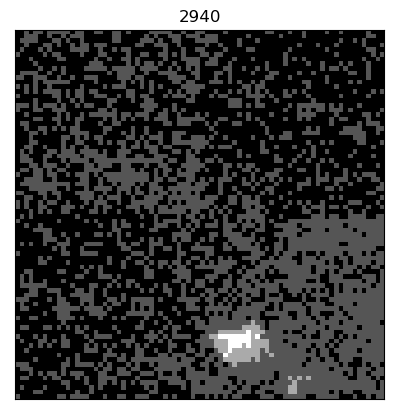

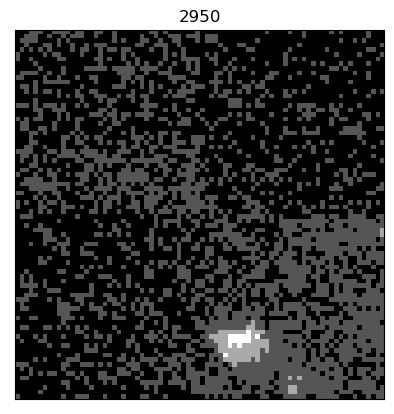

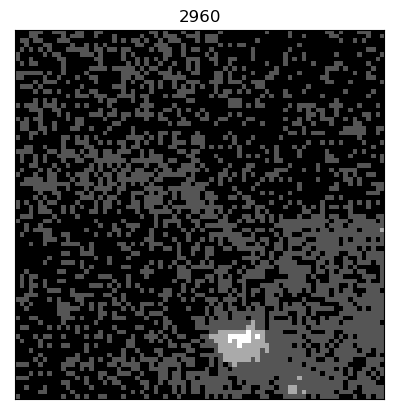

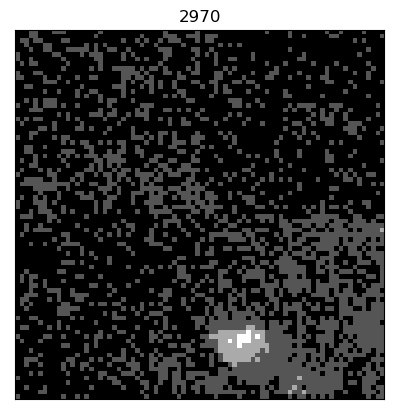

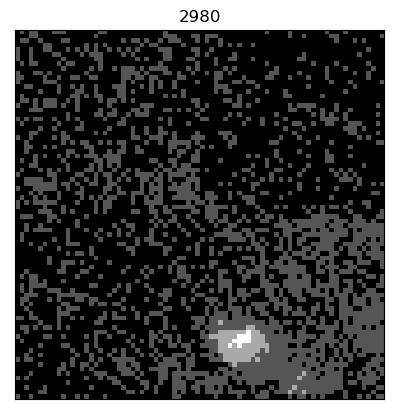

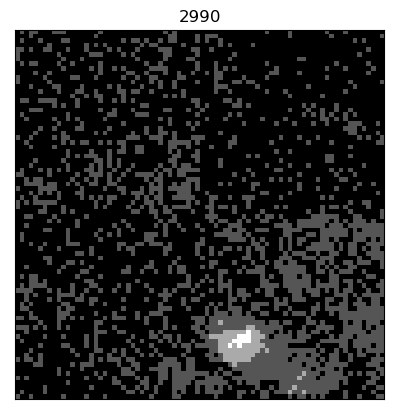

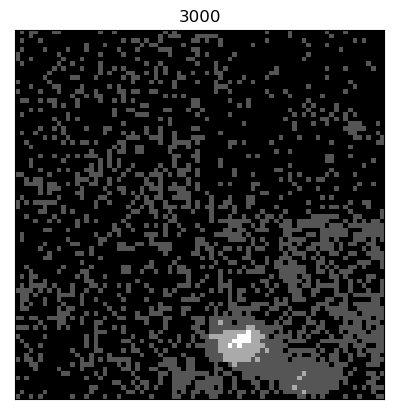

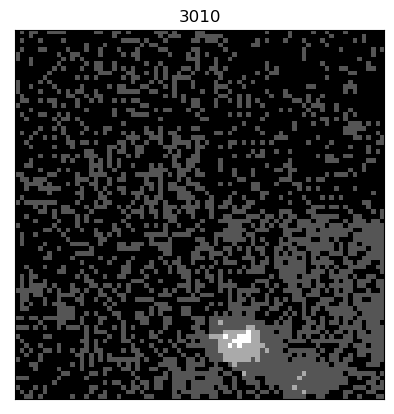

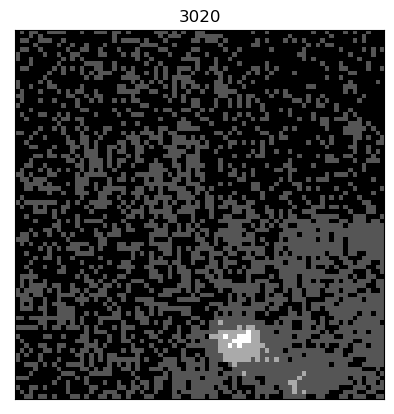

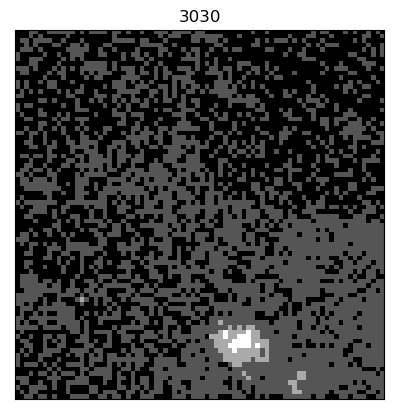

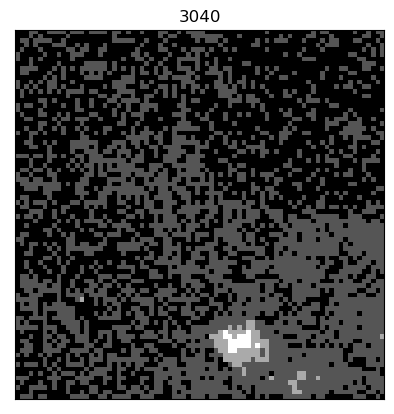

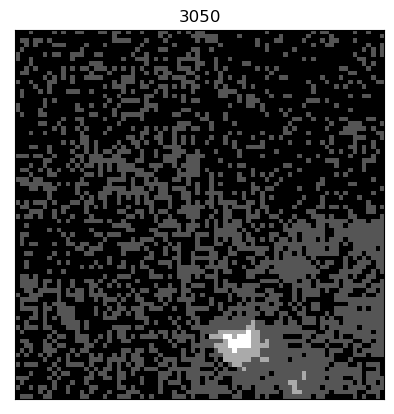

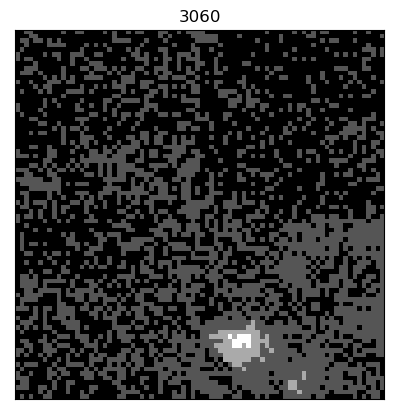

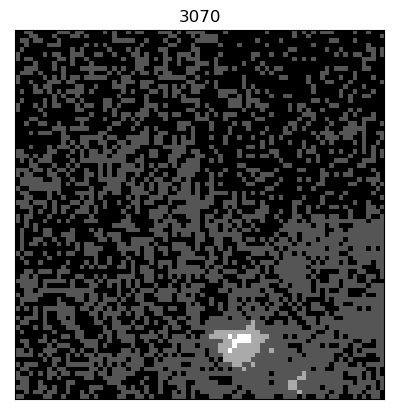

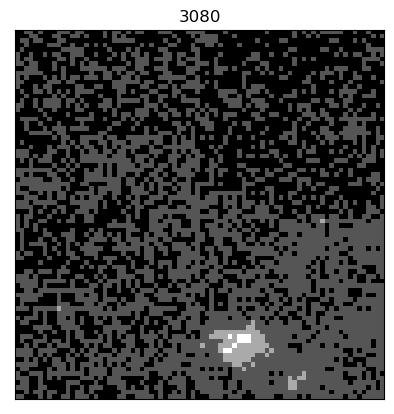

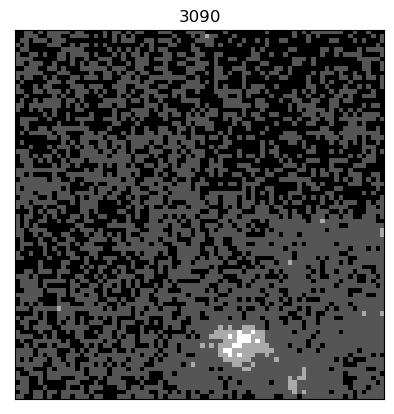

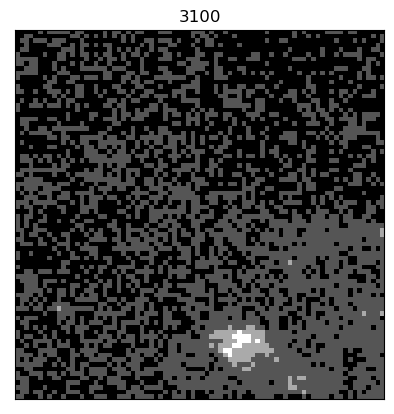

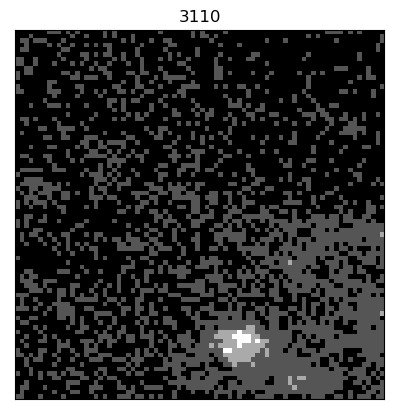

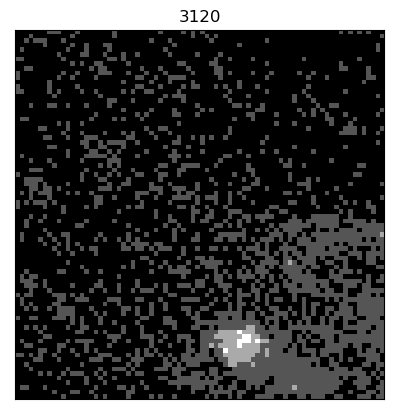

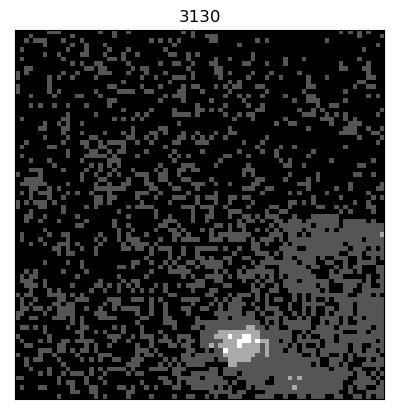

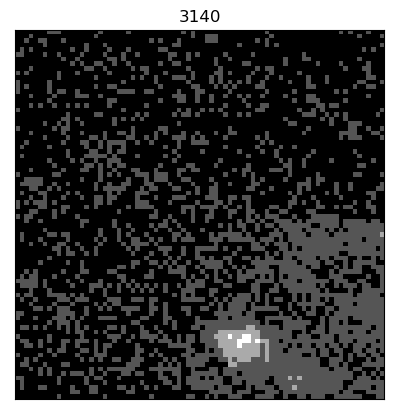

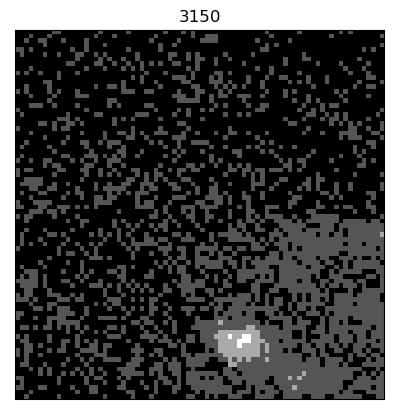

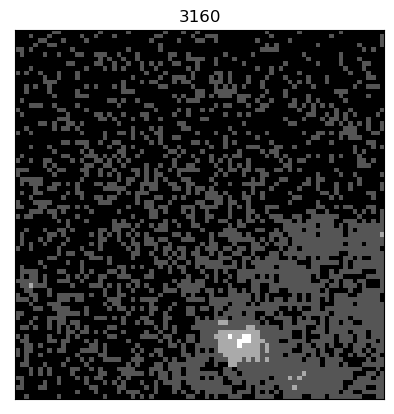

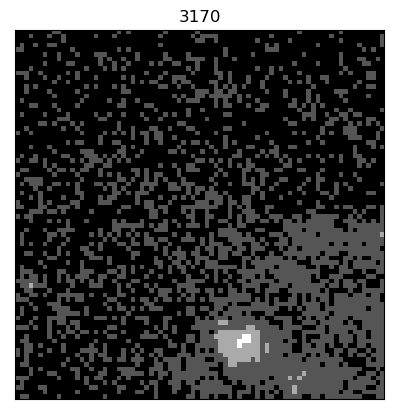

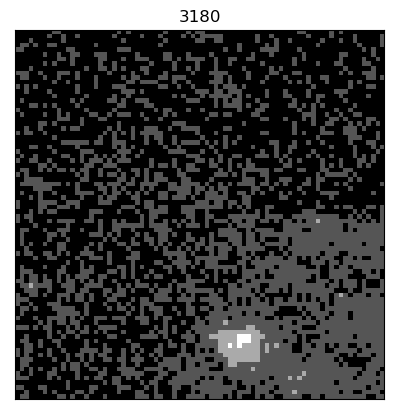

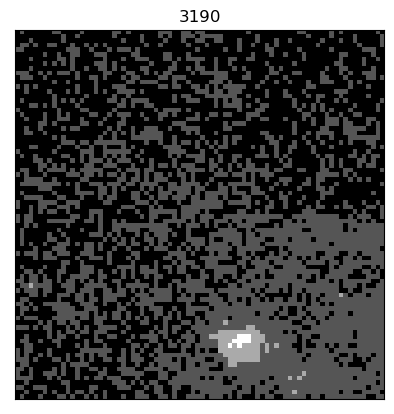

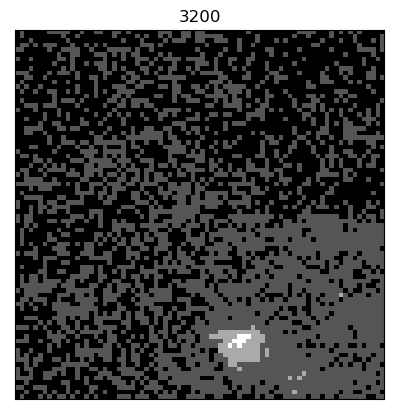

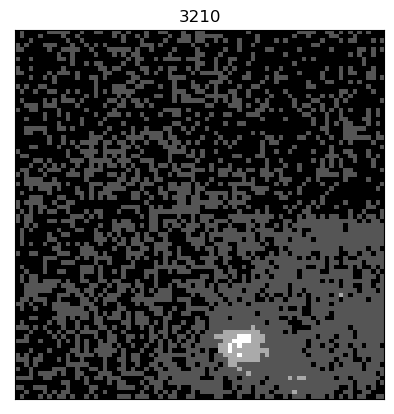

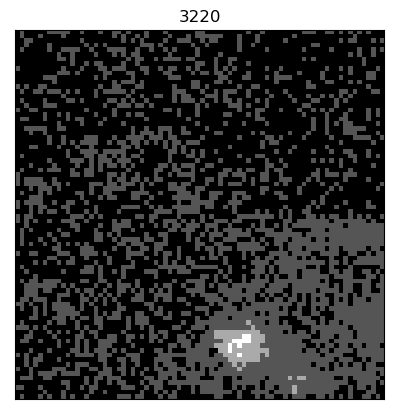

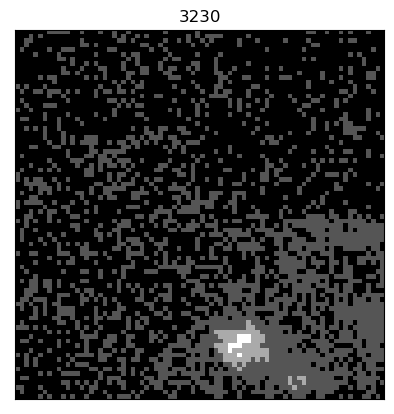

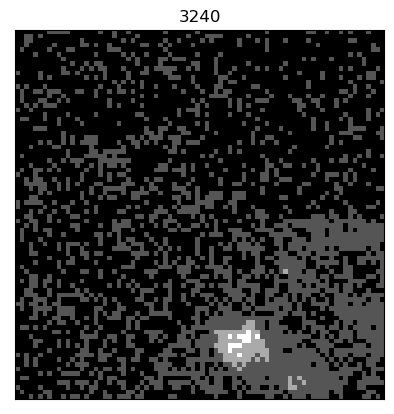

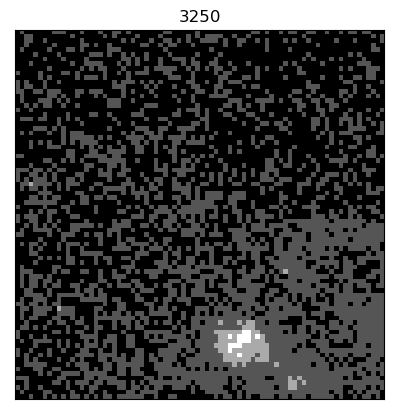

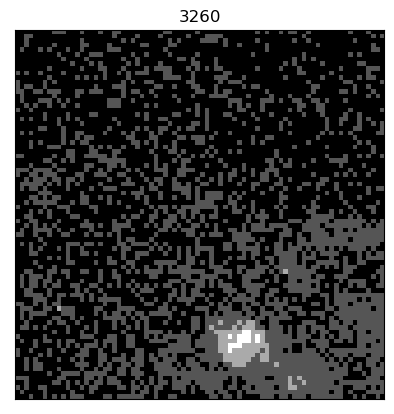

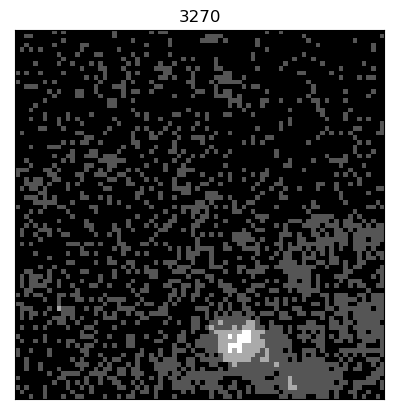

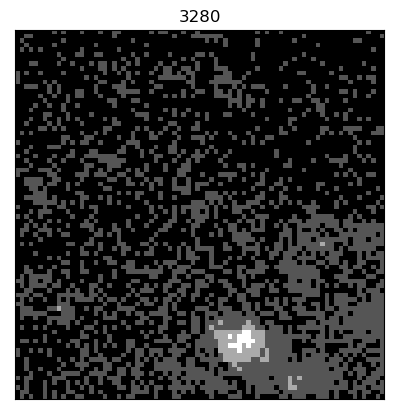

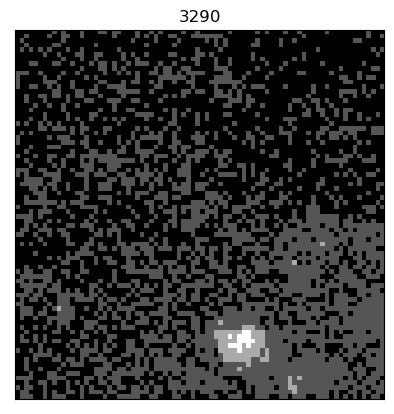

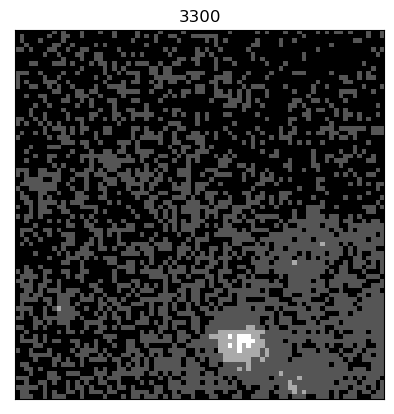

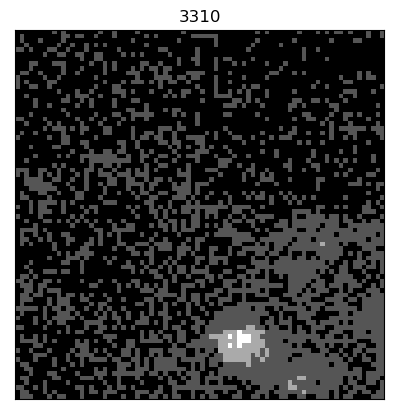

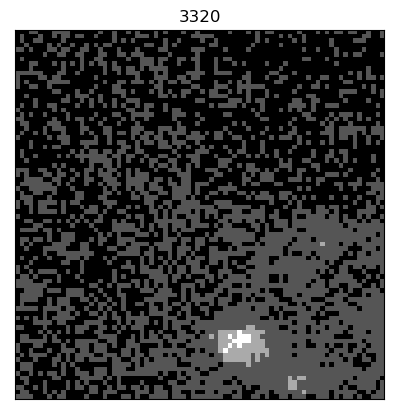

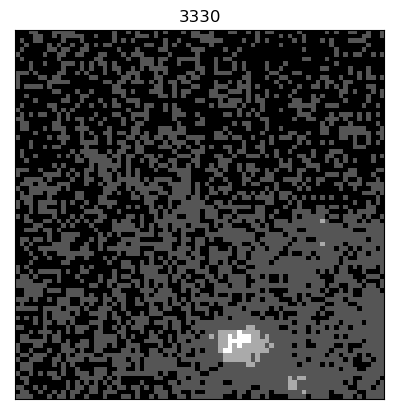

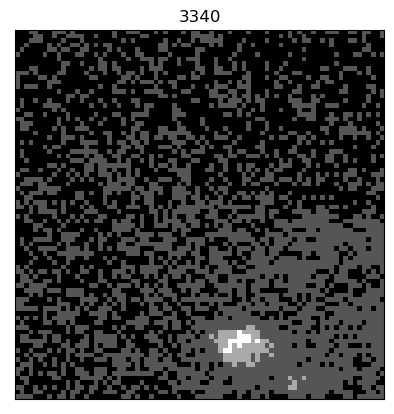

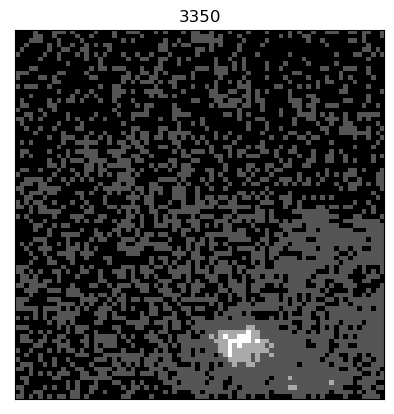

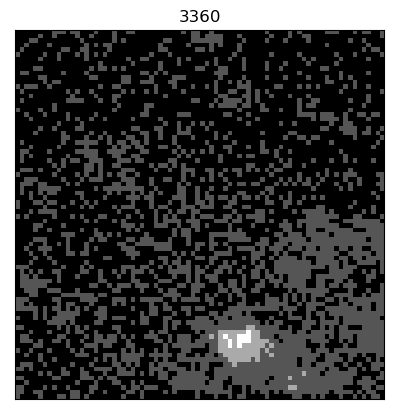

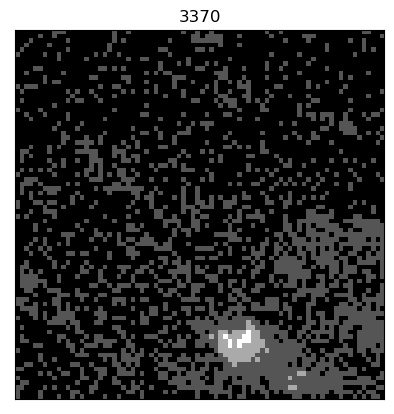

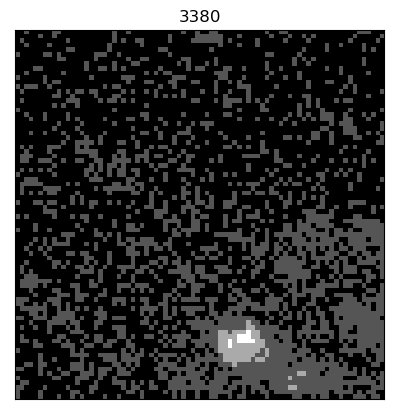

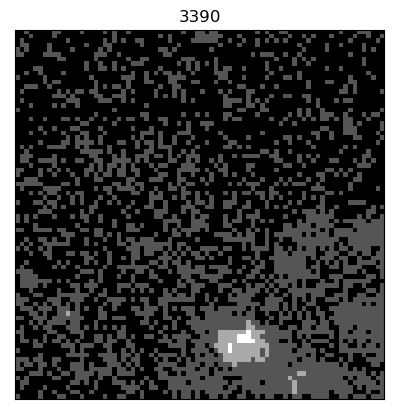

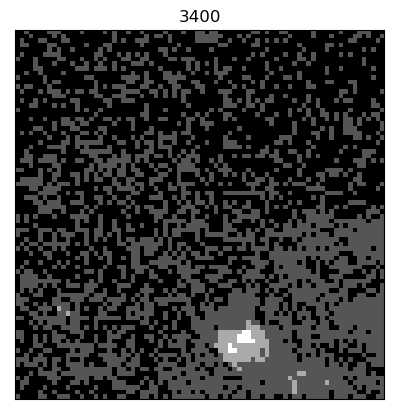

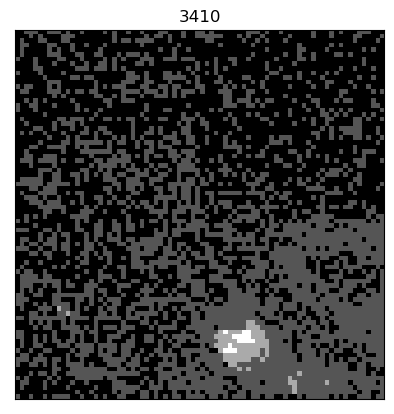

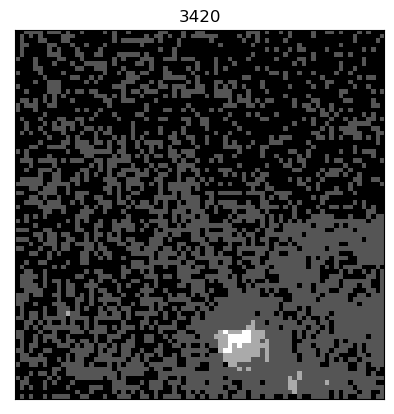

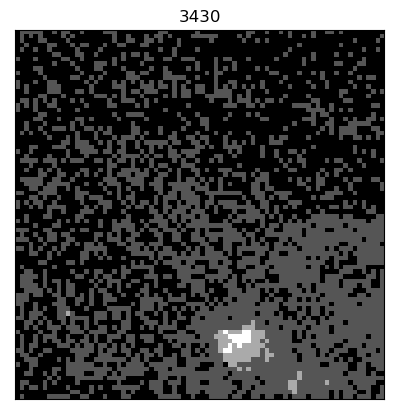

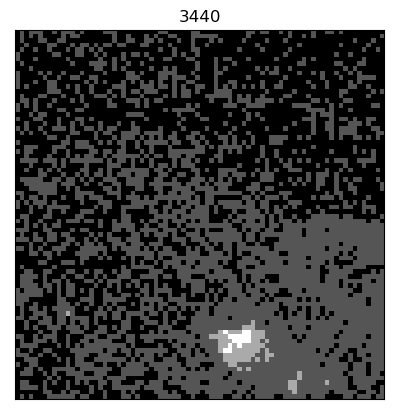

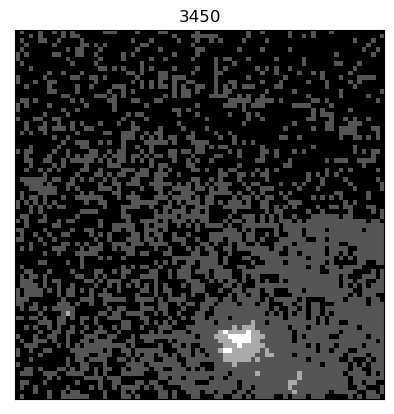

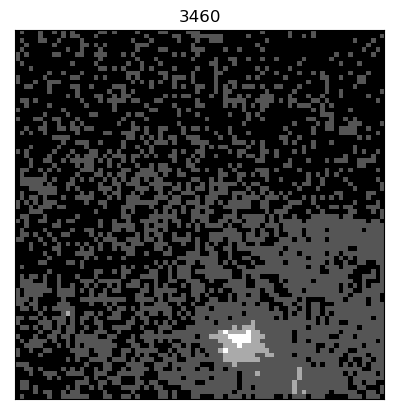

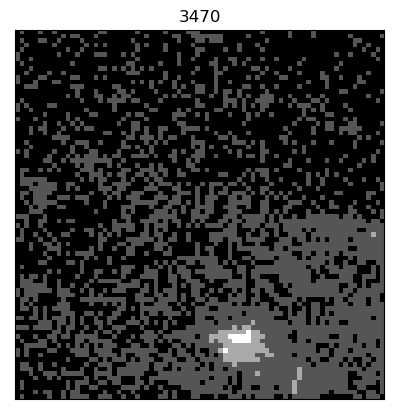

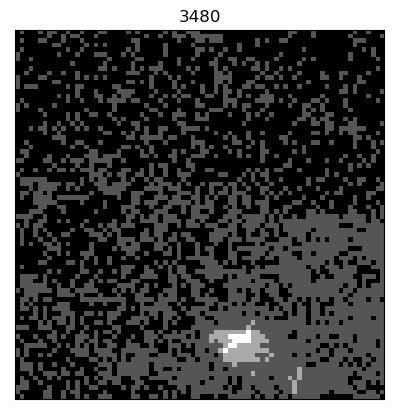

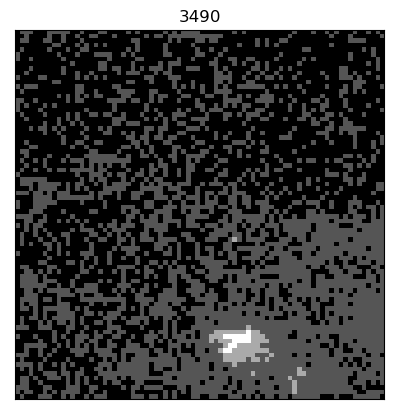

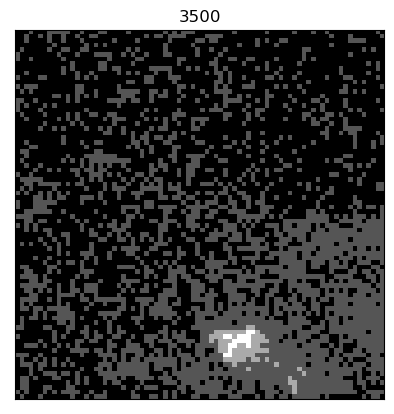

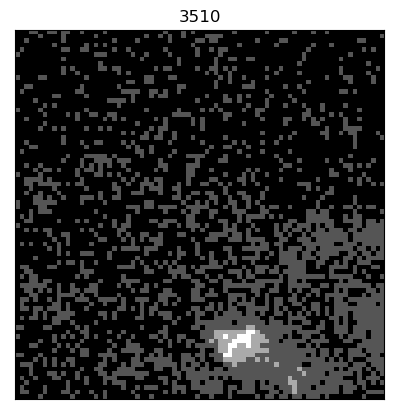

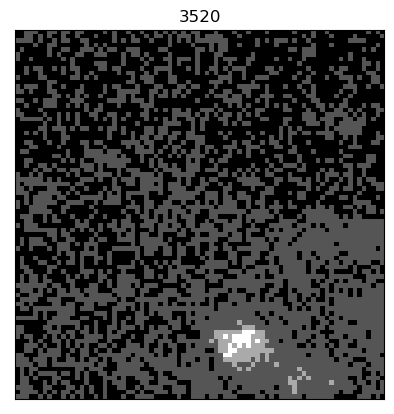

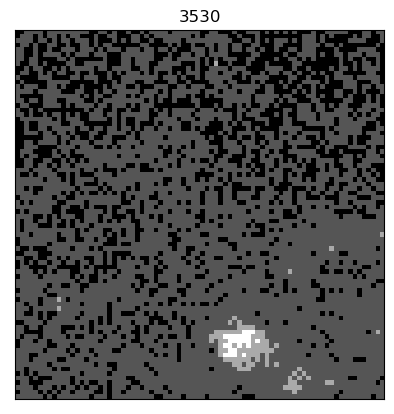

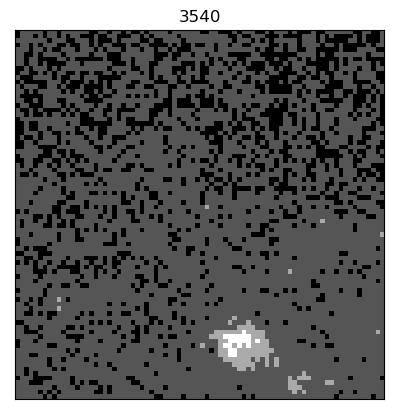

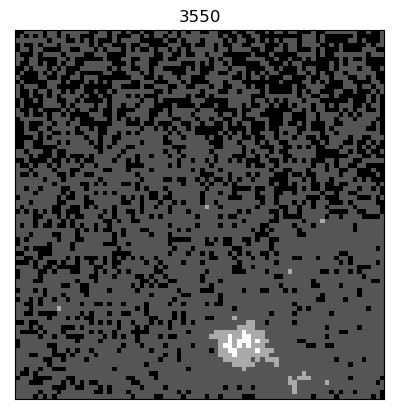

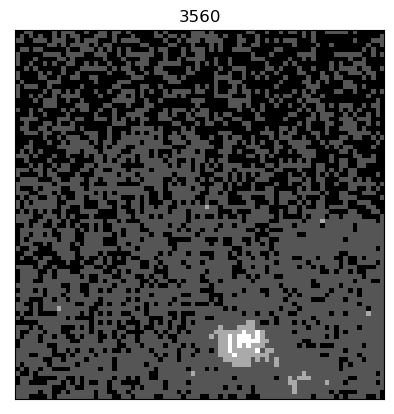

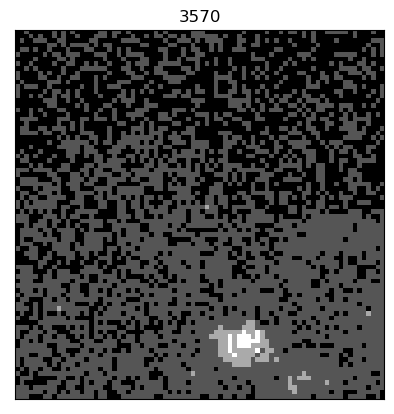

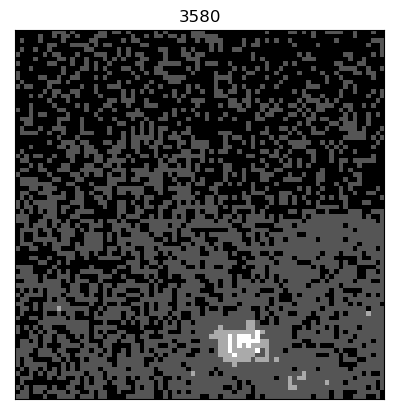

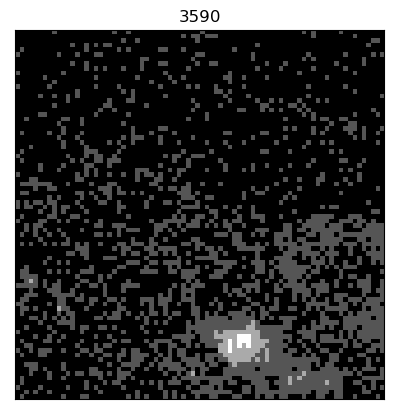

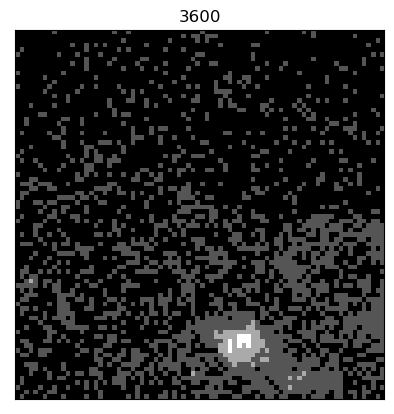

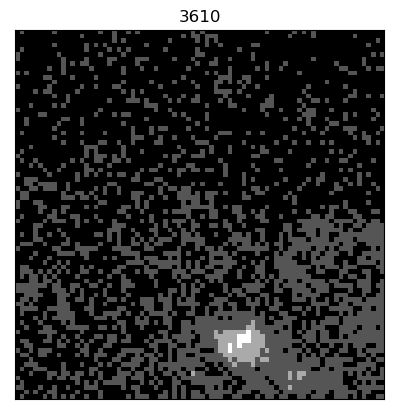

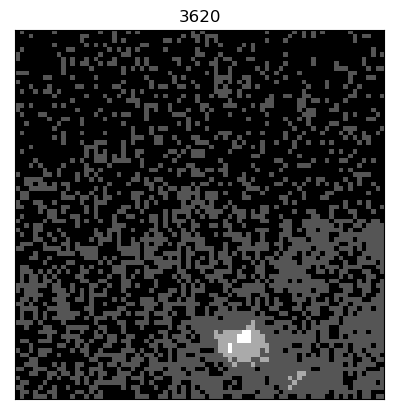

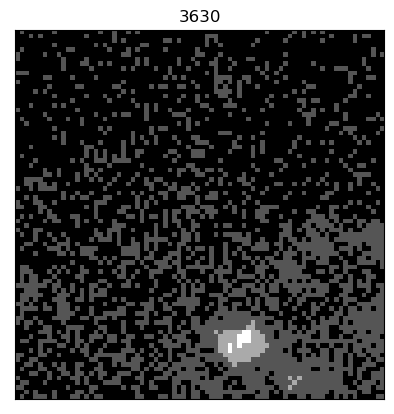

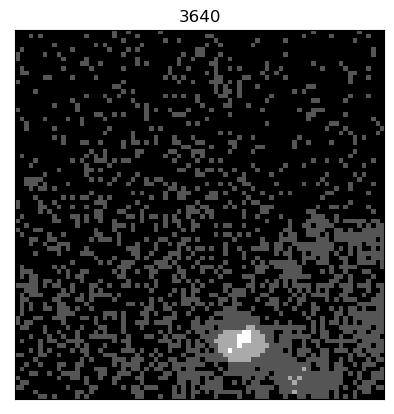

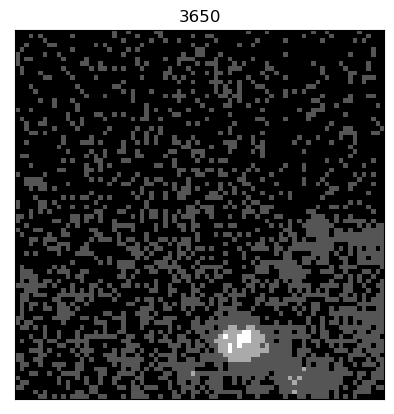

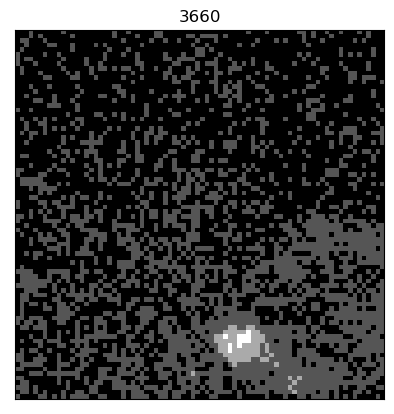

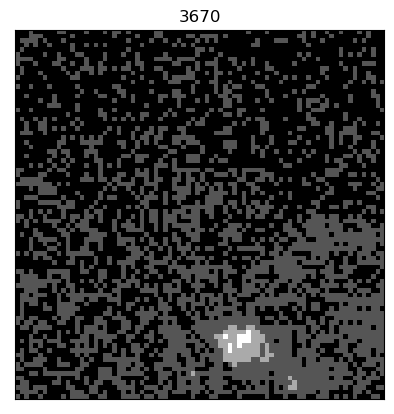

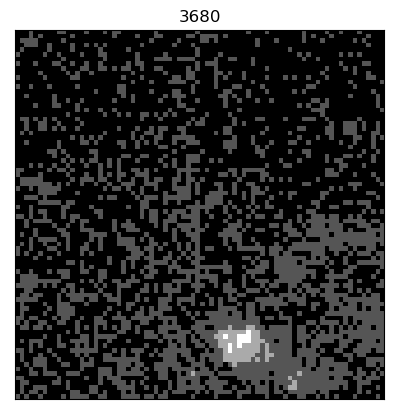

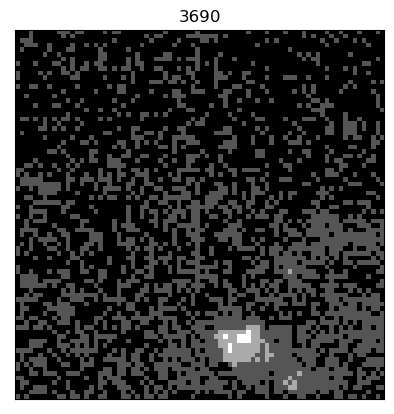

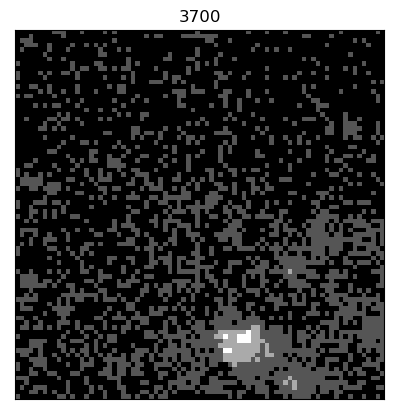

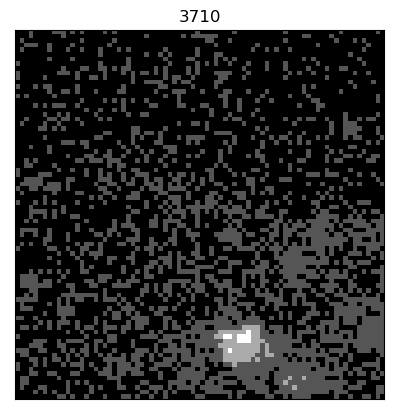

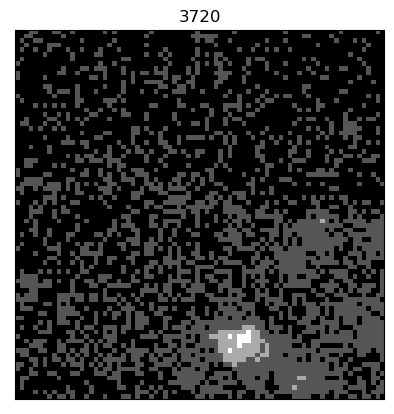

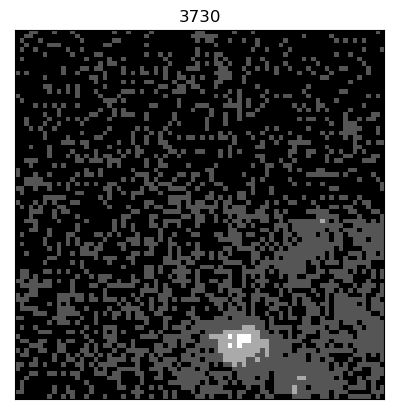

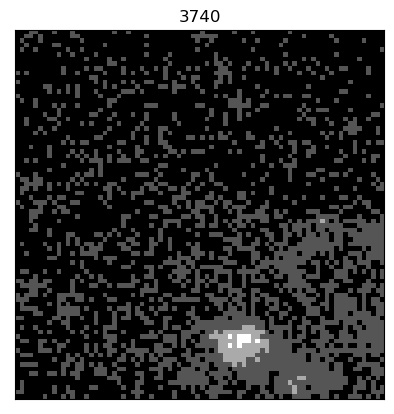

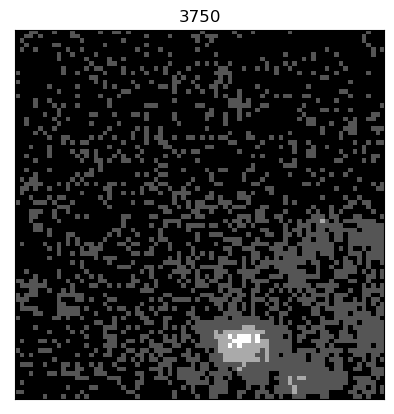

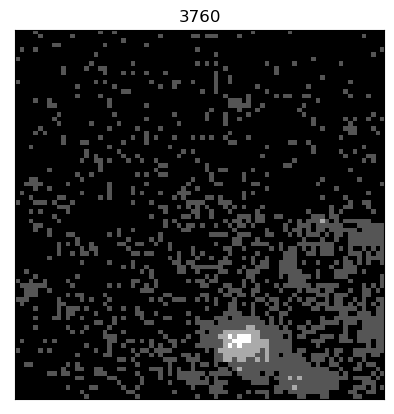

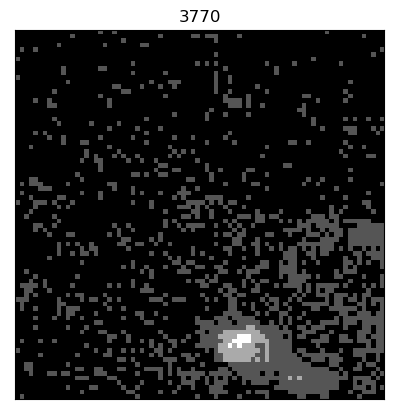

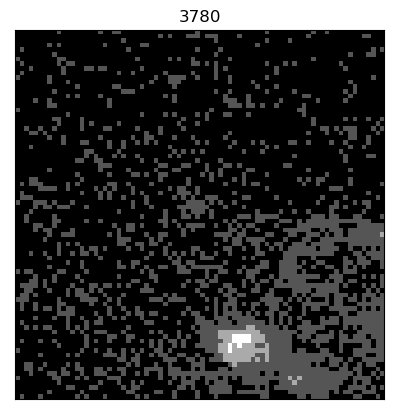

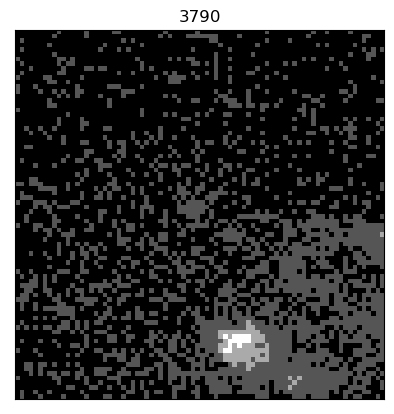

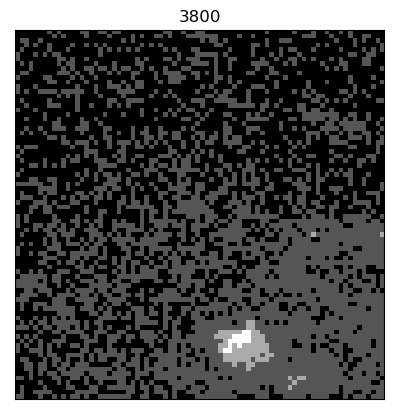

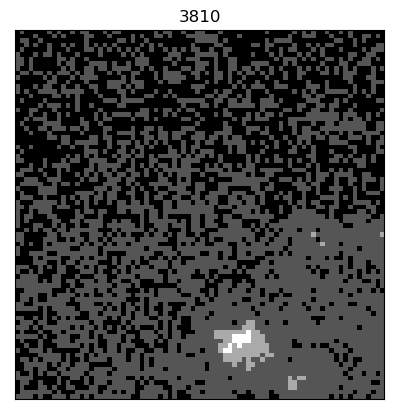

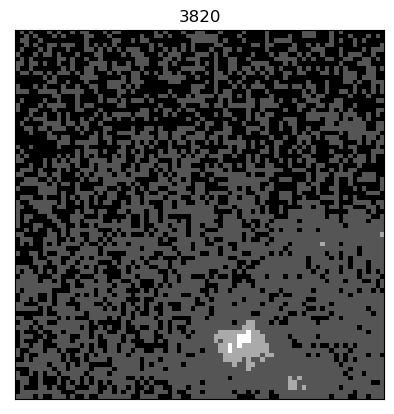

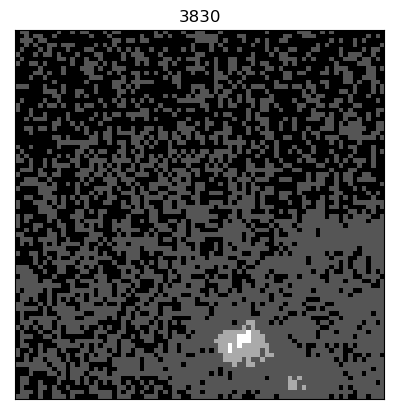

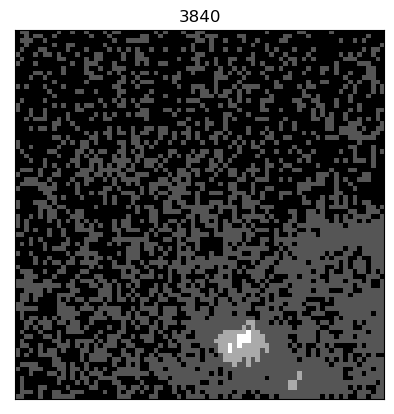

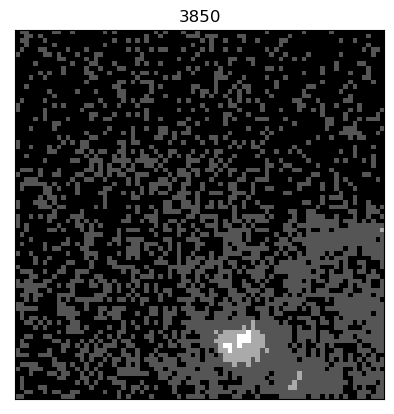

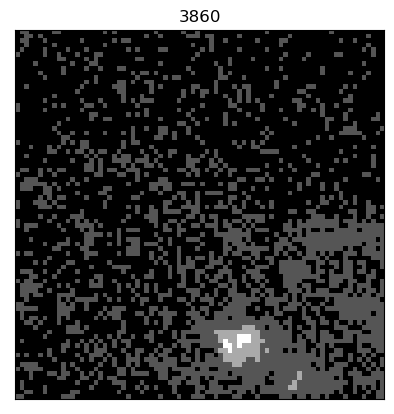

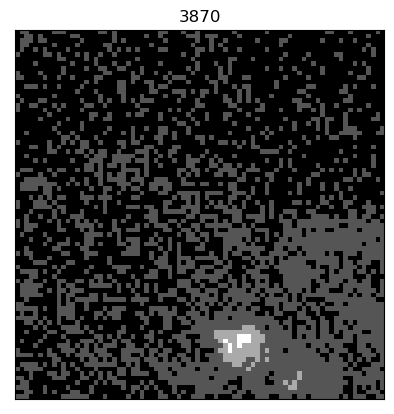

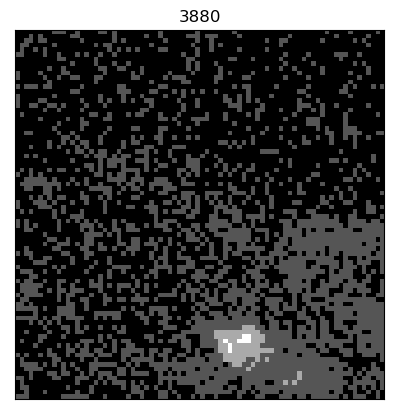

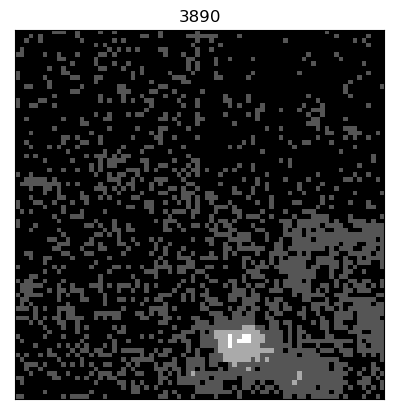

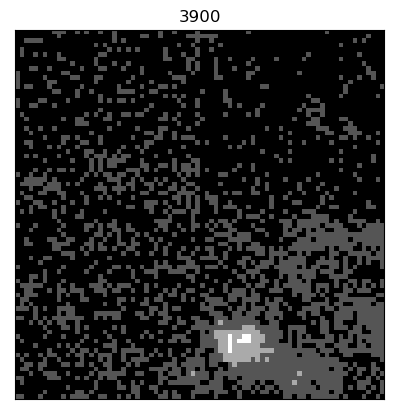

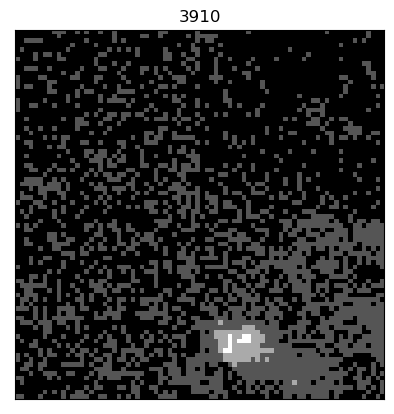

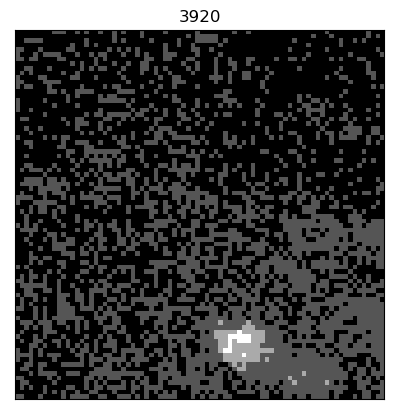

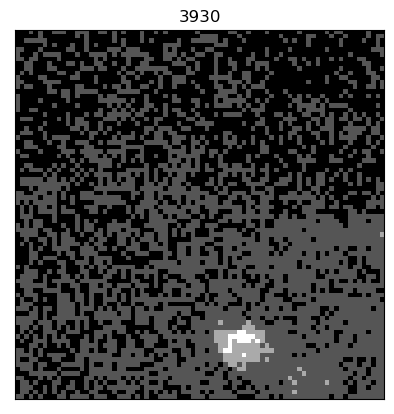

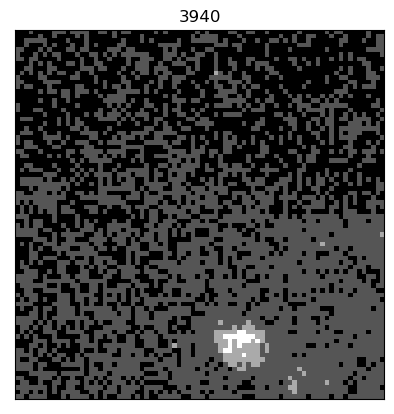

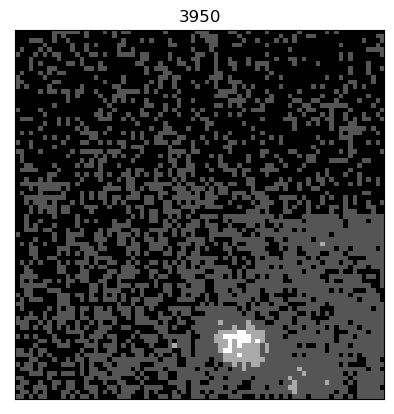

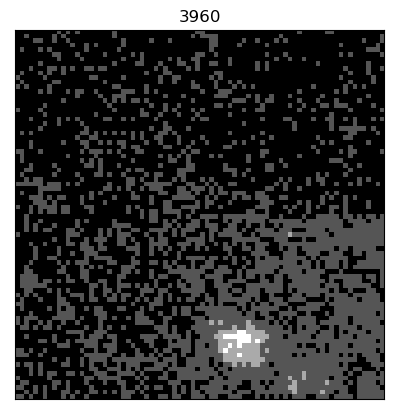

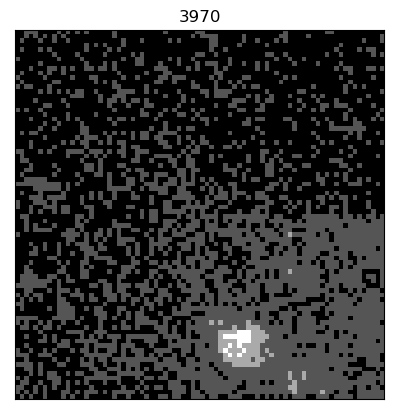

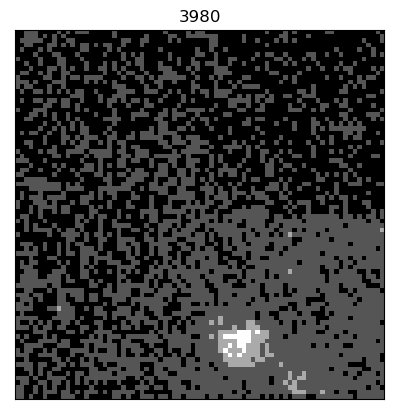

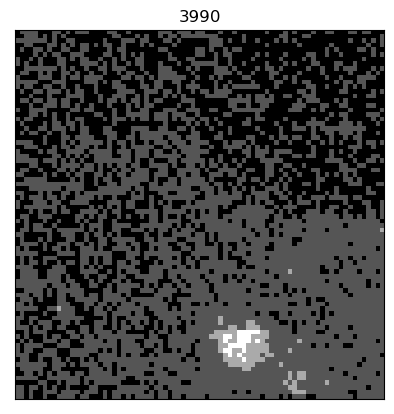

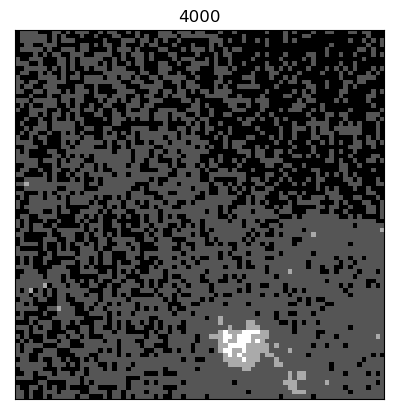

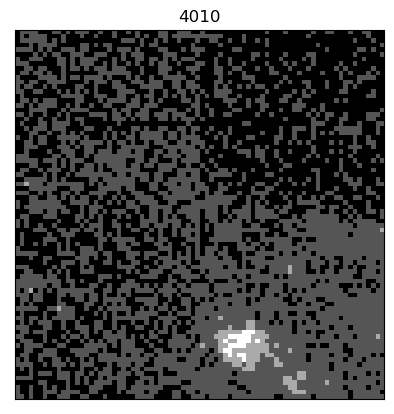

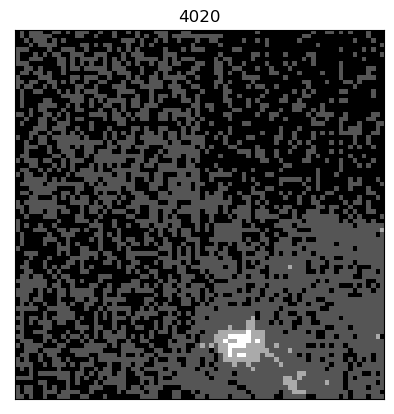

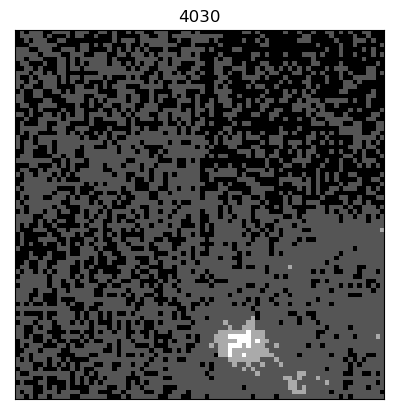

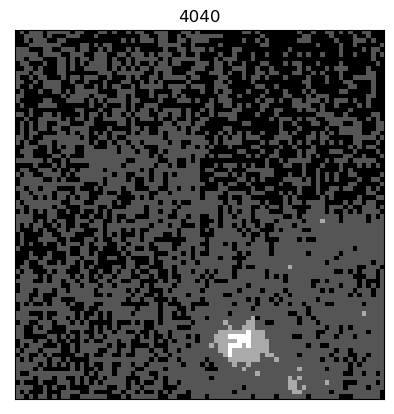

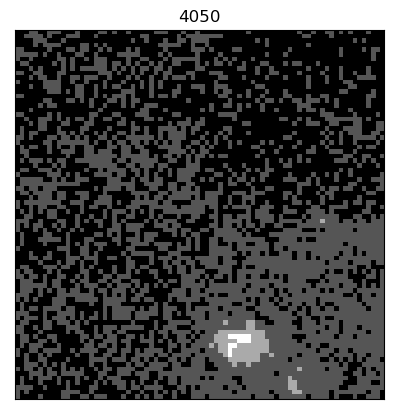

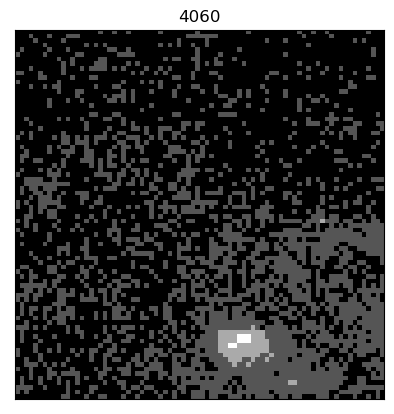

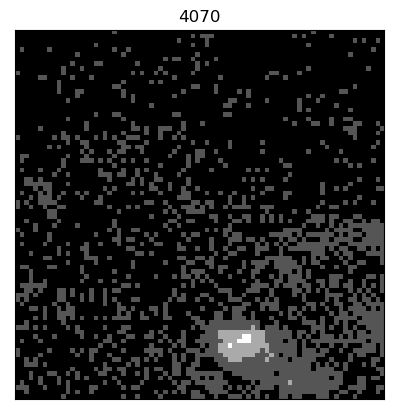

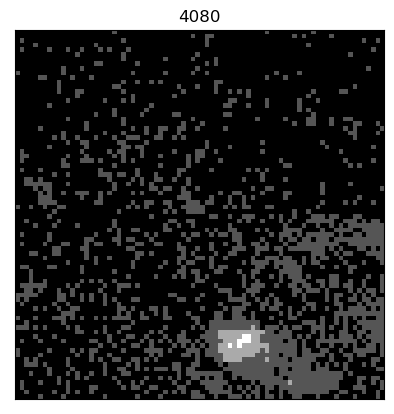

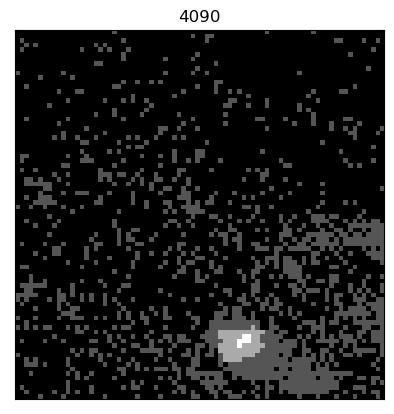

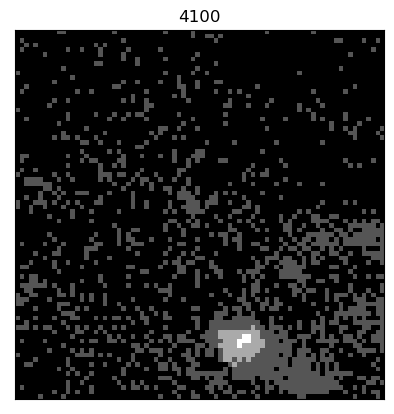

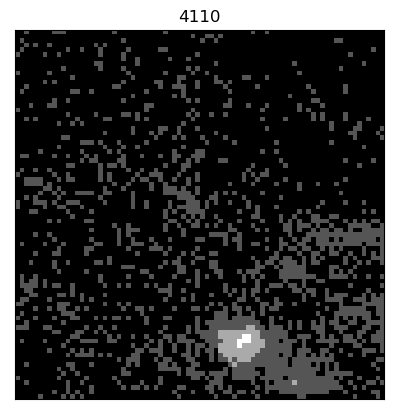

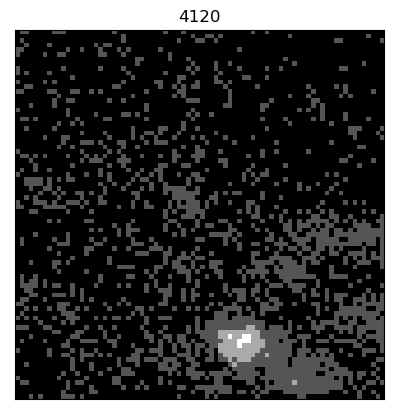

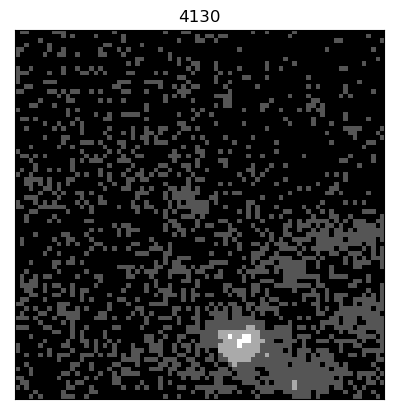

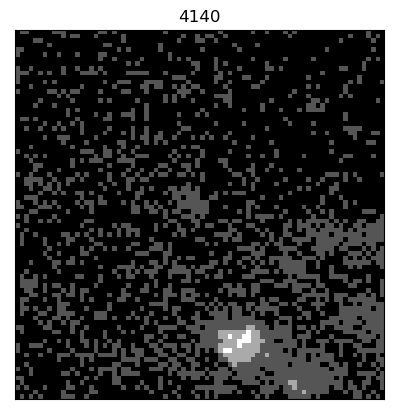

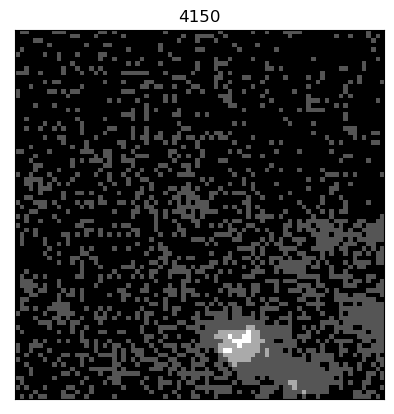

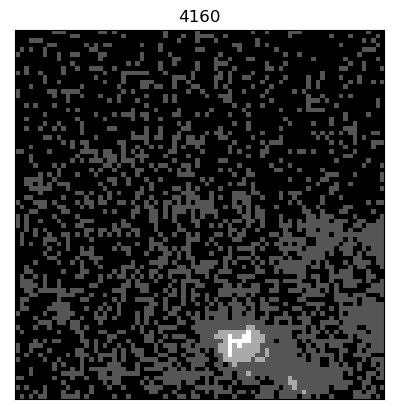

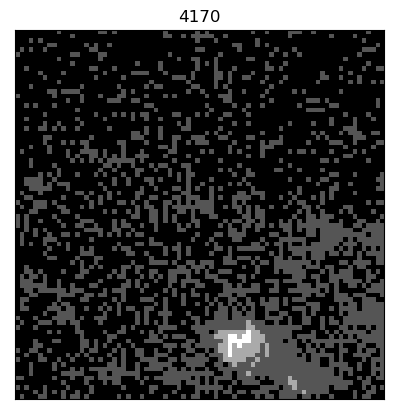

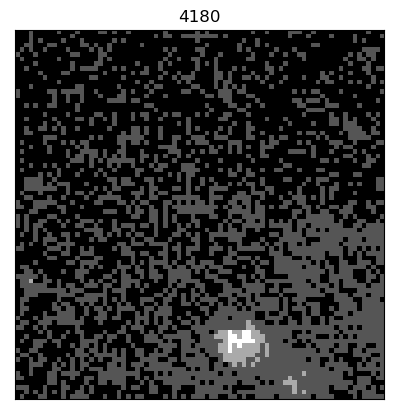

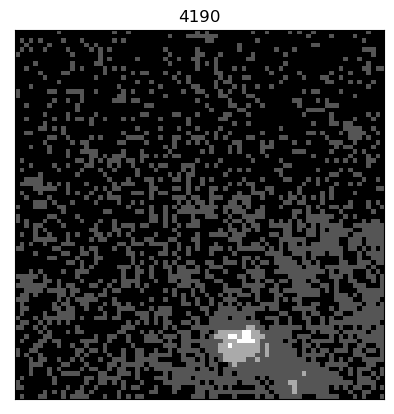

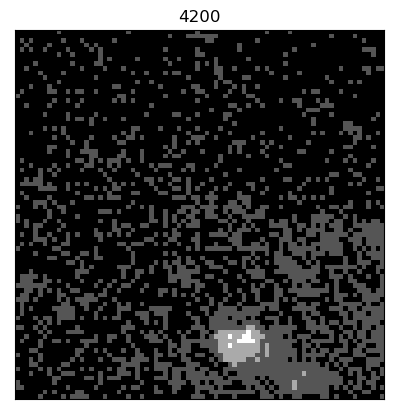

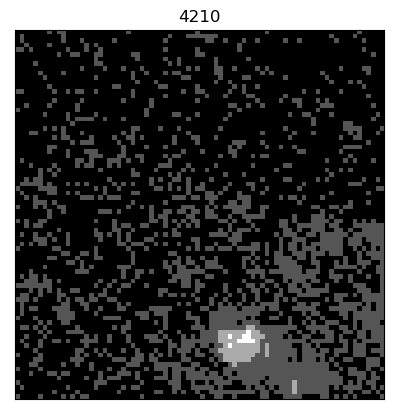

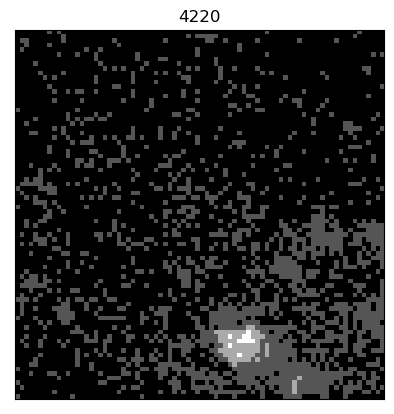

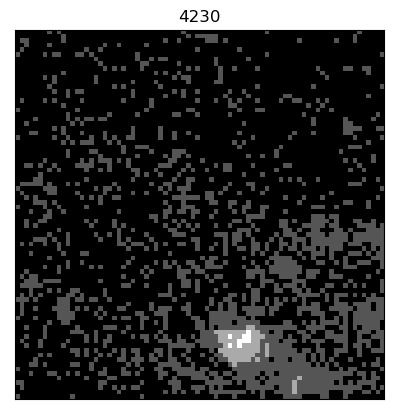

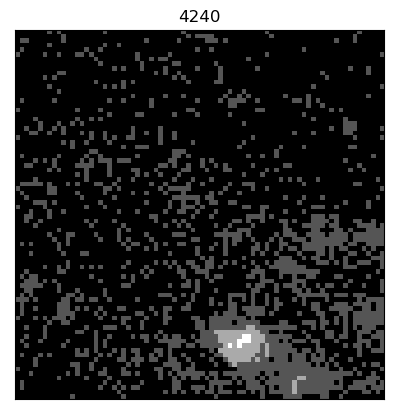

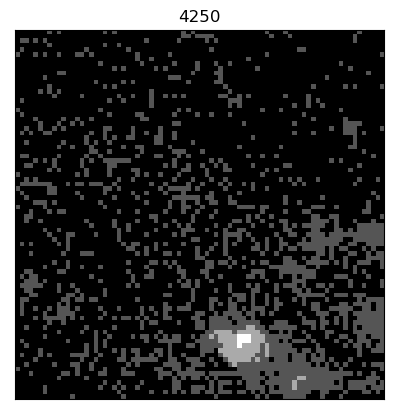

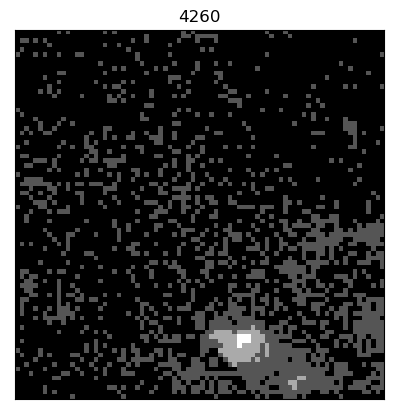

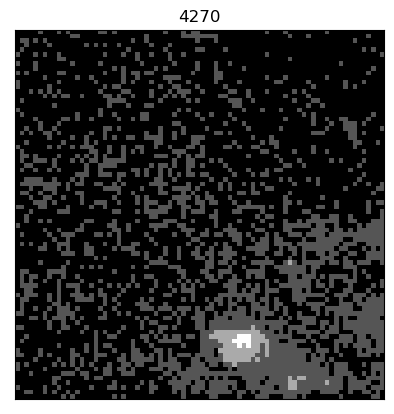

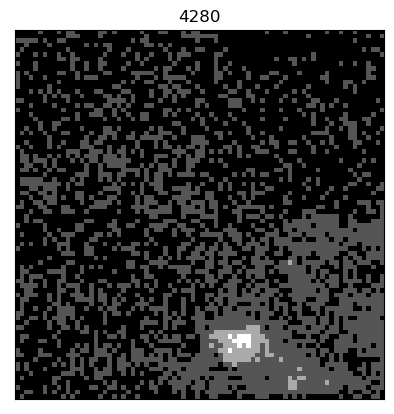

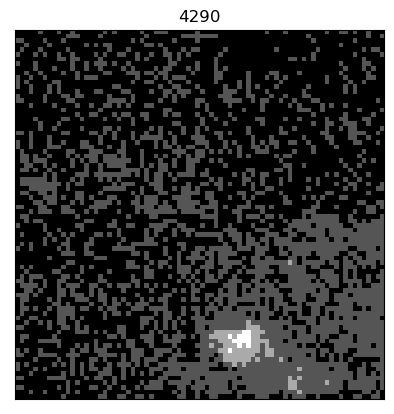

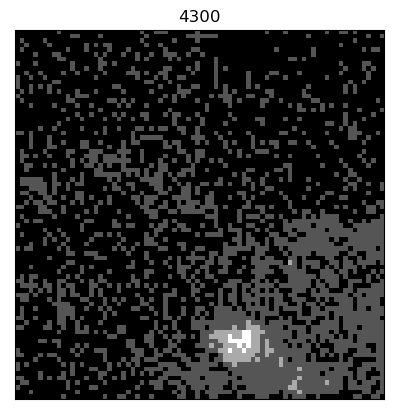

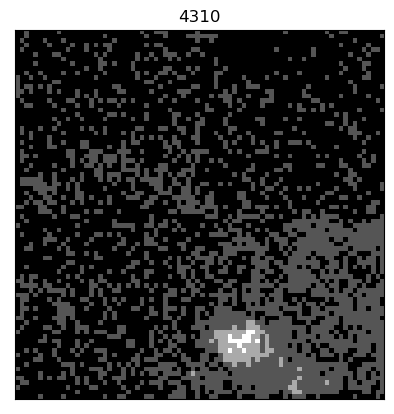

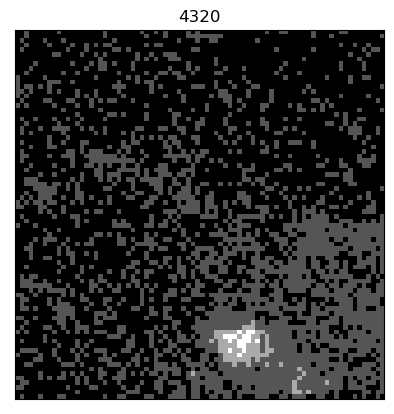

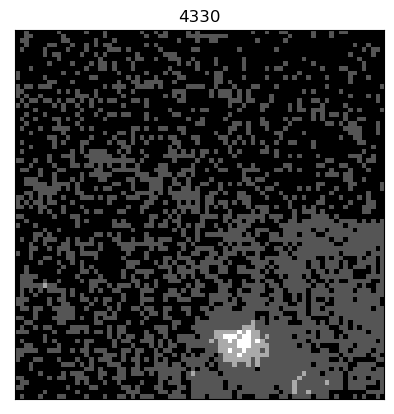

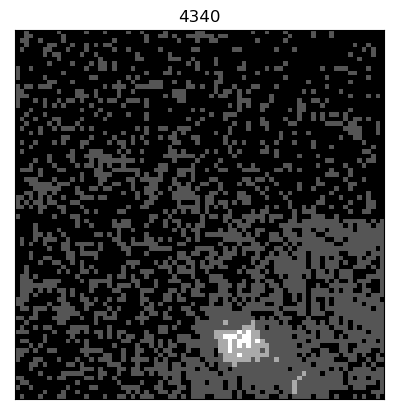

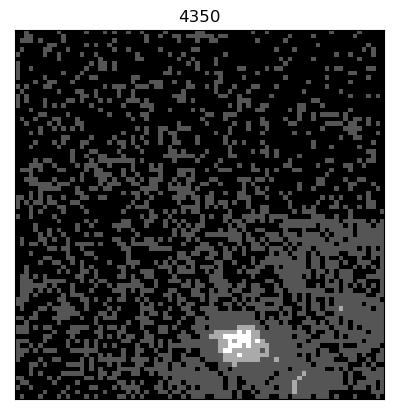

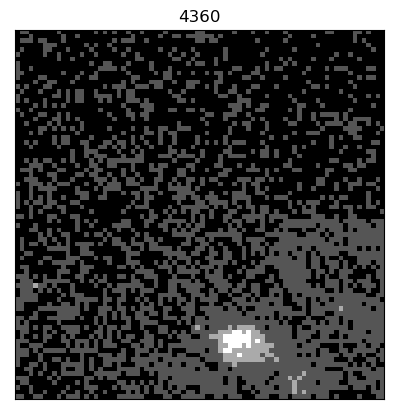

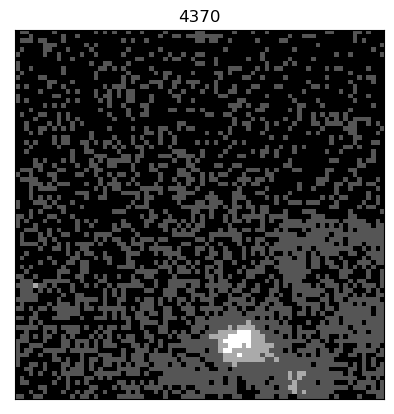

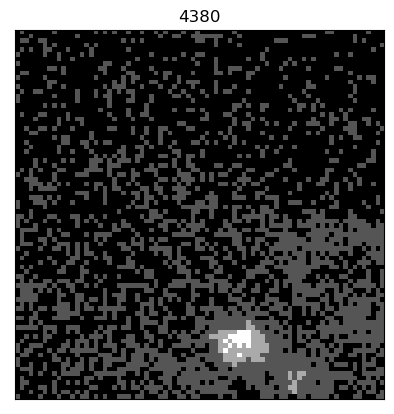

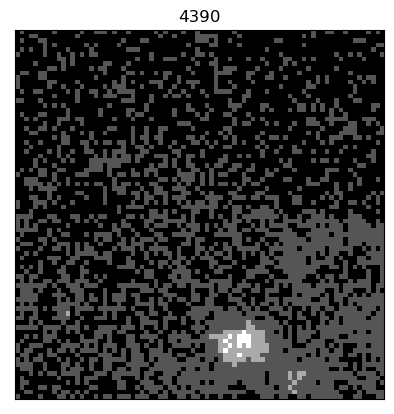

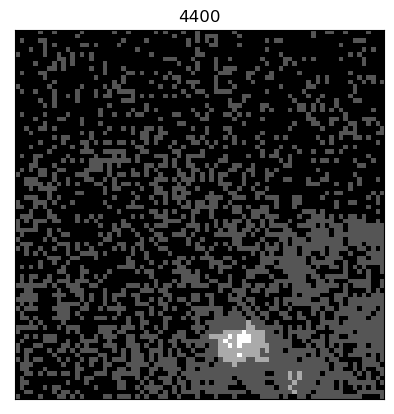

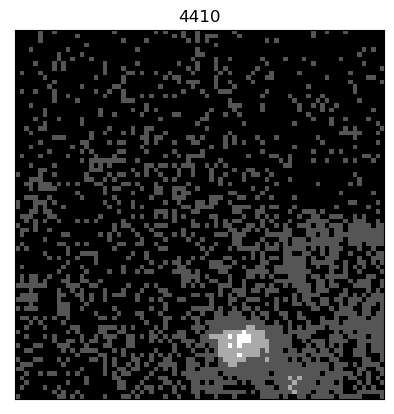

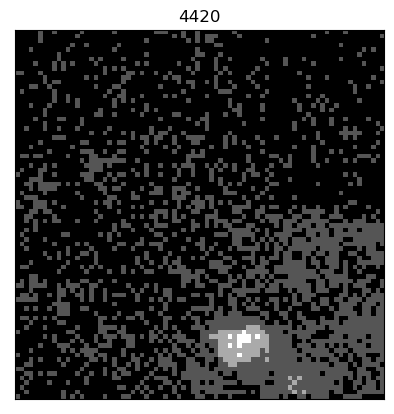

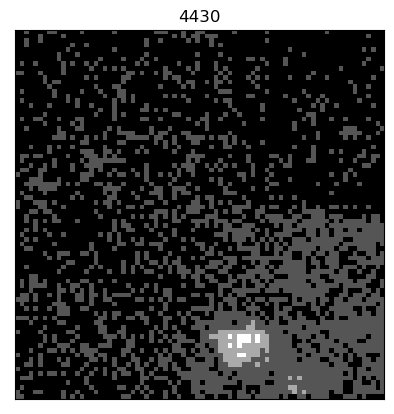

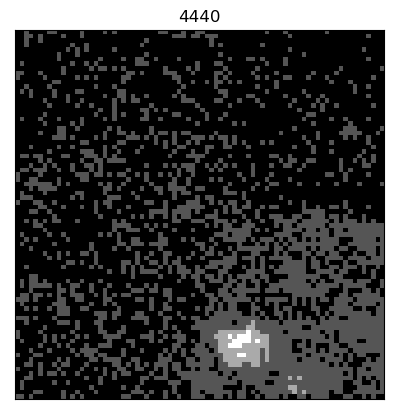

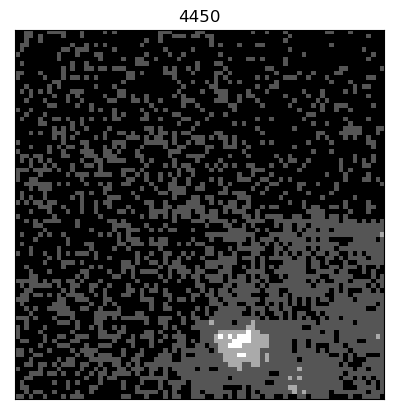

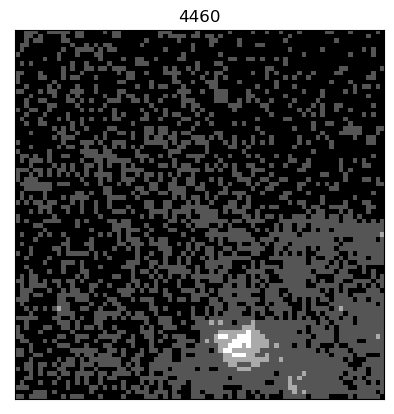

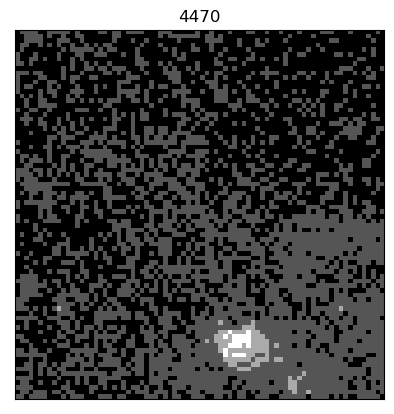

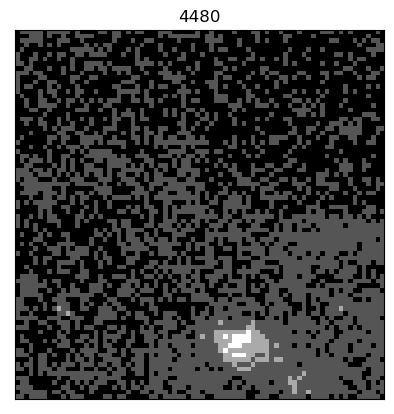

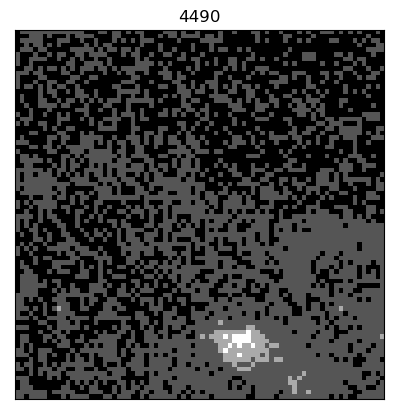

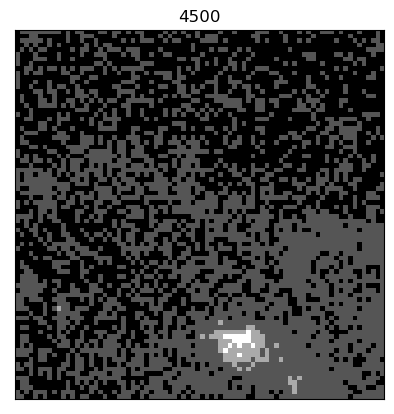

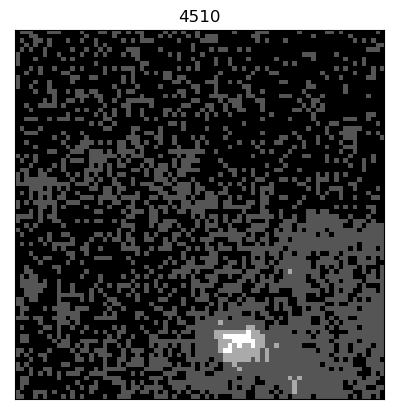

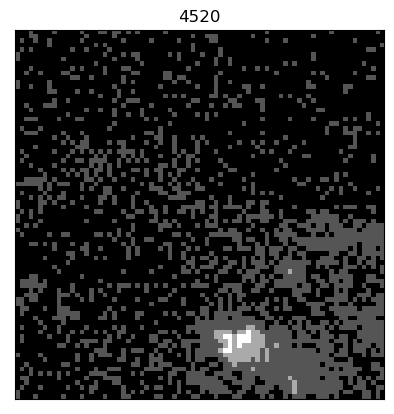

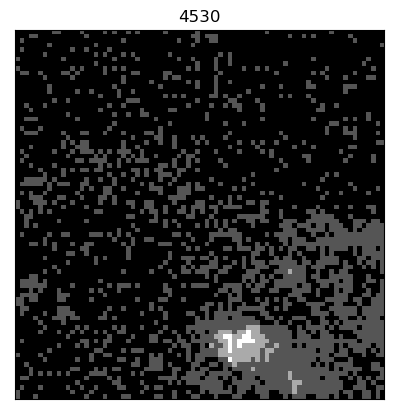

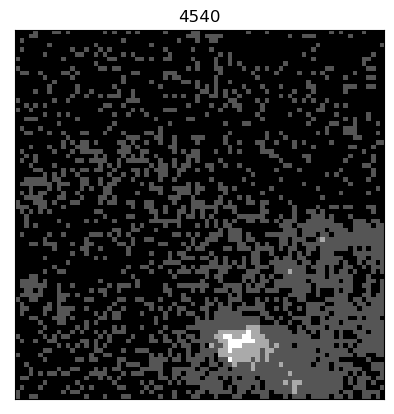

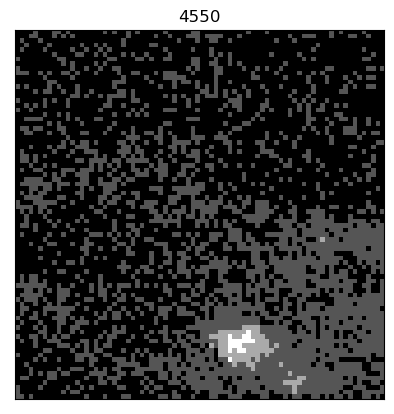

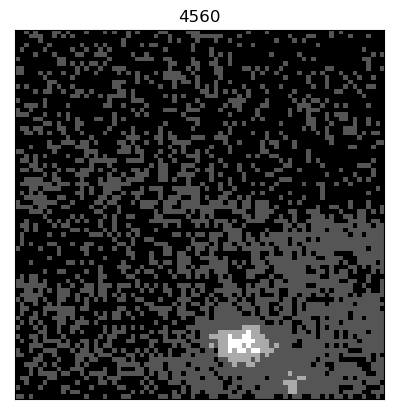

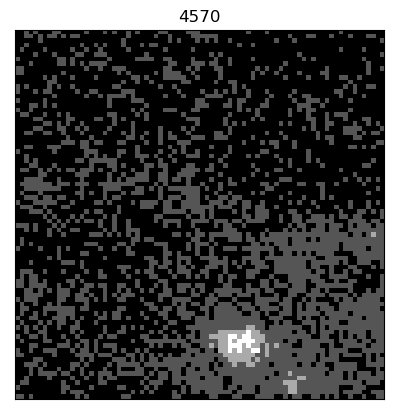

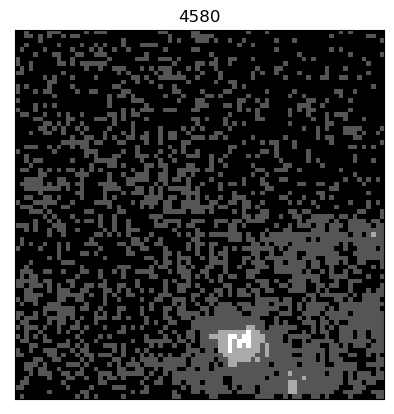

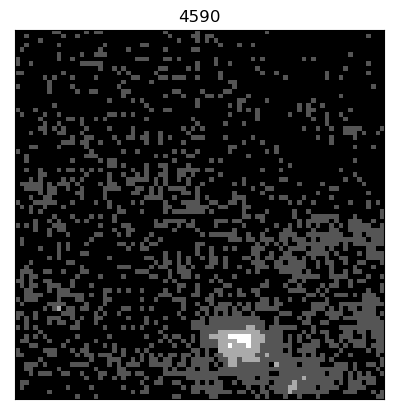

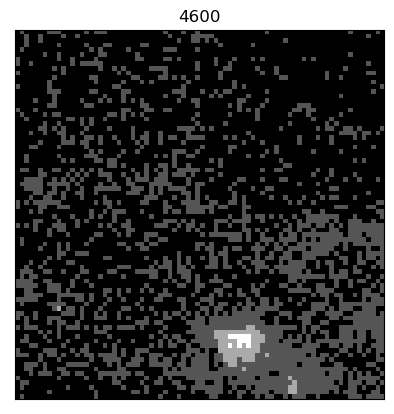

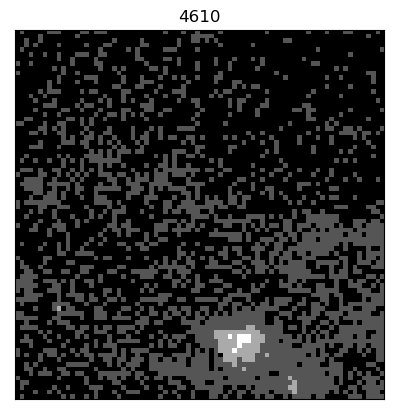

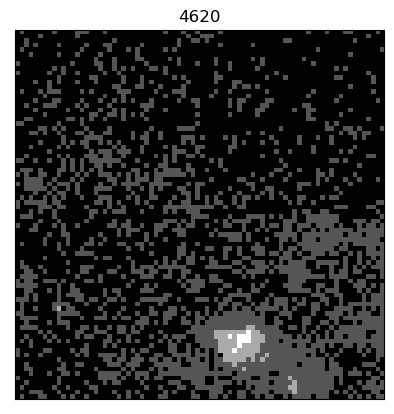

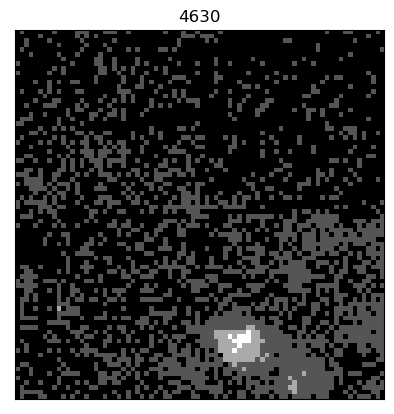

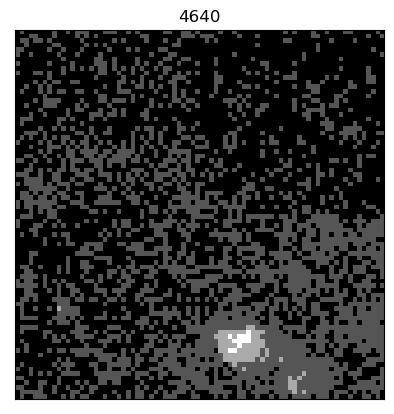

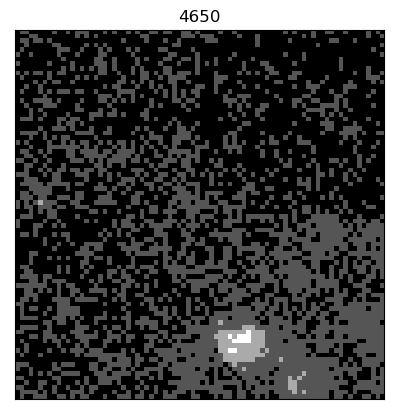

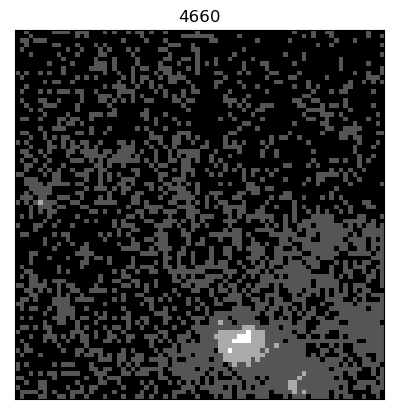

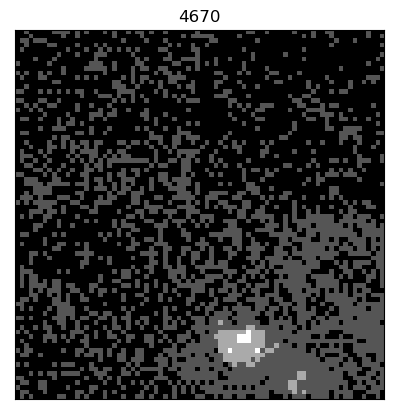

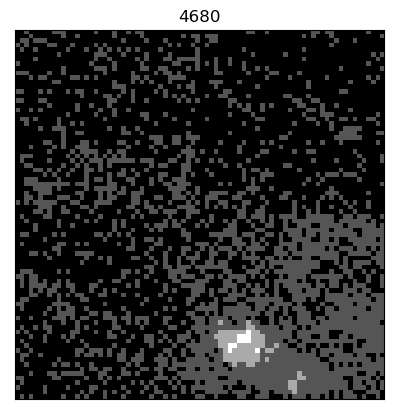

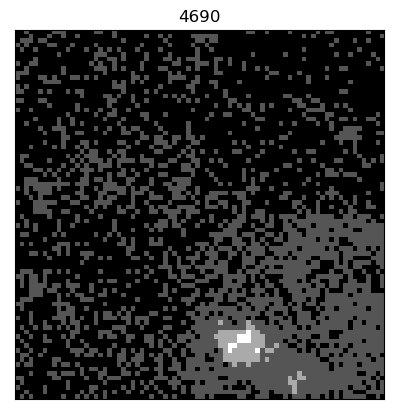

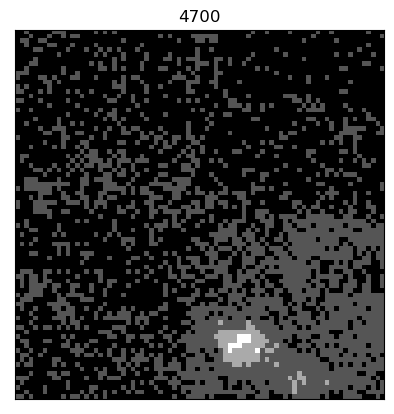

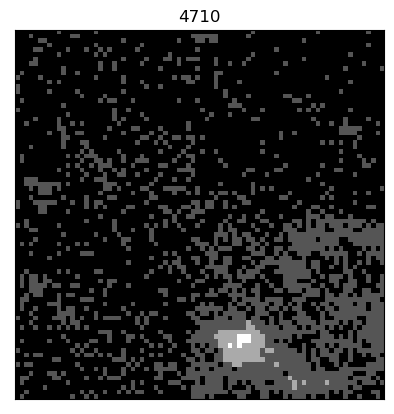

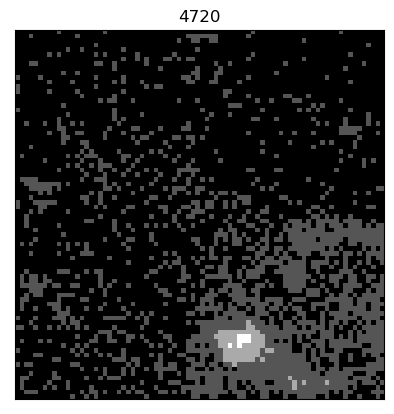

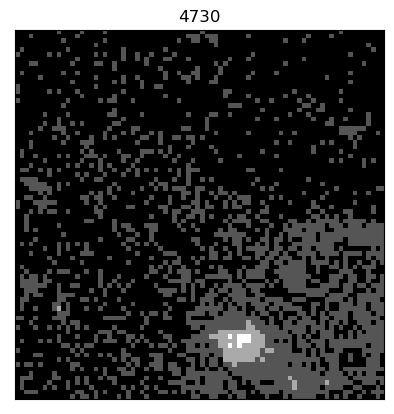

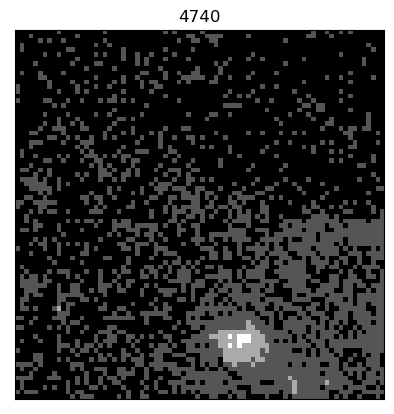

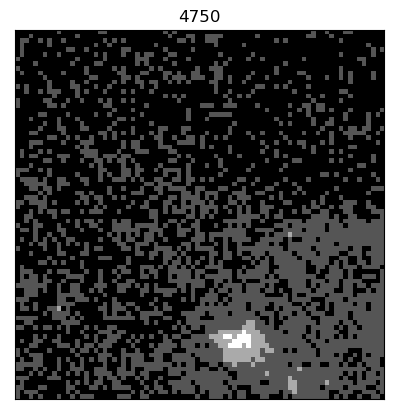

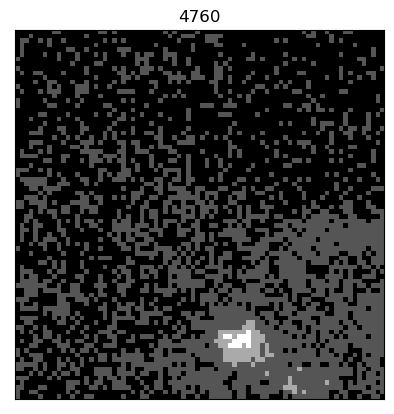

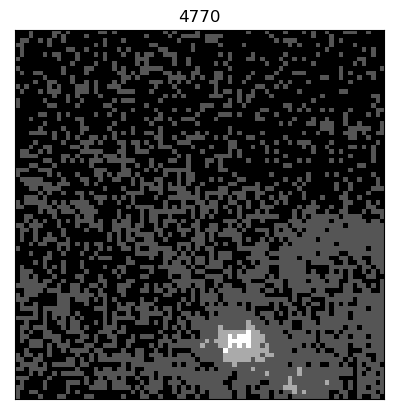

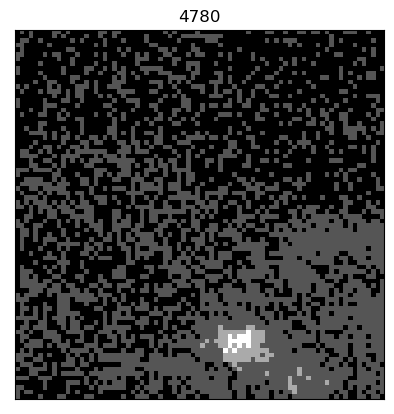

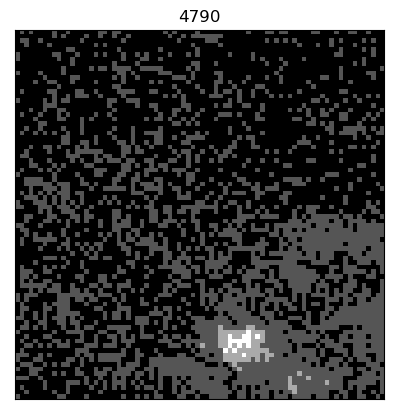

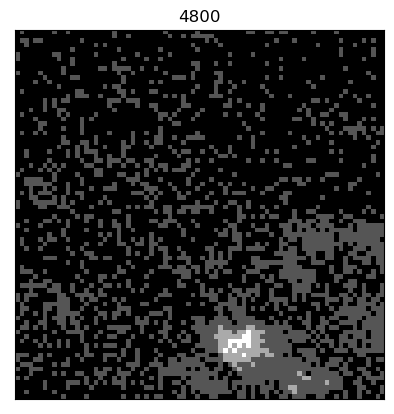

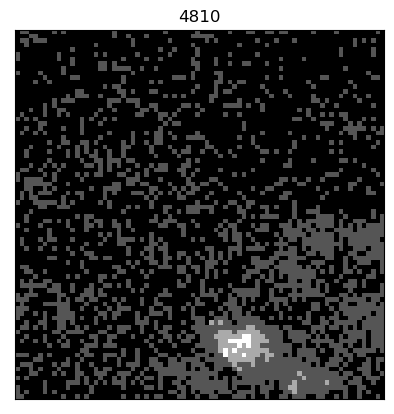

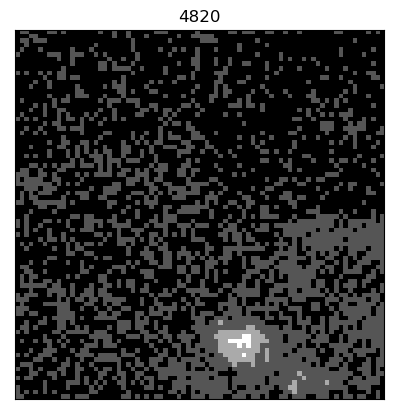

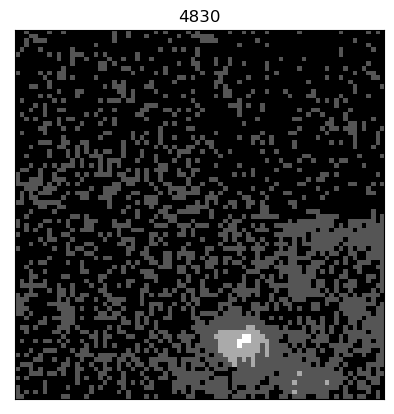

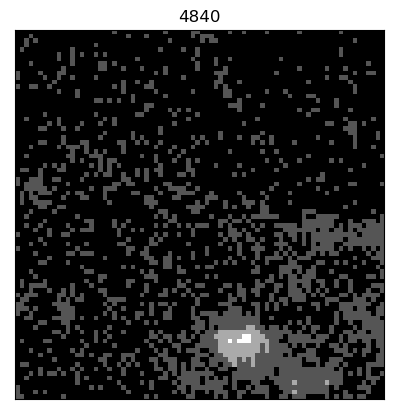

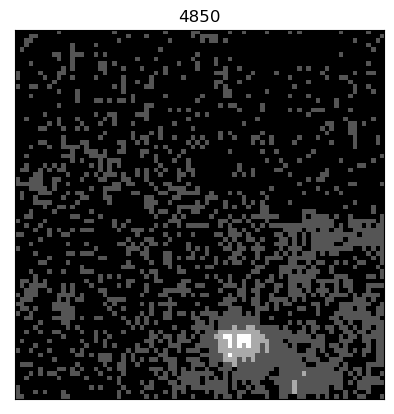

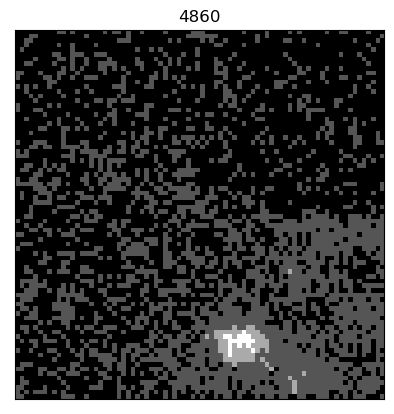

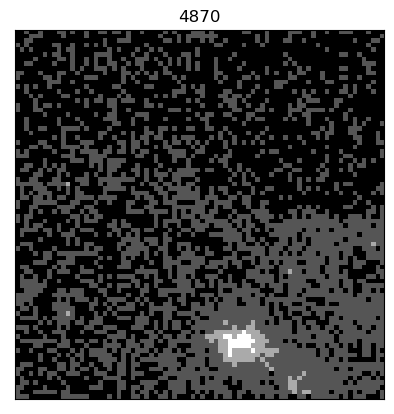

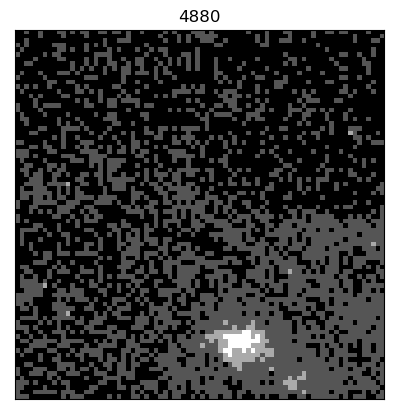

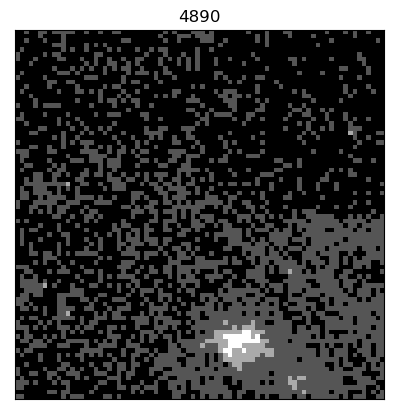

In [11]:
for frame_num in range(0, space_data3.shape[0], 10):
    plt.imshow(space_data2[frame_num, :, :], cmap='gray') # matplotlib.colors.ListedColormap(colors))
    plt.xticks([])
    plt.yticks([])
    plt.title(f'{frame_num+100}')
    plt.savefig(f'c:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\figures\\Fig3\\Frames\\{frame_num+100}.png')
    plt.show()